# HW3: Genetic Algorithm for Path Planning Problem

In [27]:
import numpy as np
from matplotlib import pyplot as plt
import time
%matplotlib inline

In [28]:
DNA_SIZE = 10            # DNA length
POP_SIZE = 100           # population size
CROSS_RATE = 0.8         # mating probability (DNA crossover)
MUTATION_RATE = 0.003    # mutation probability
N_GENERATIONS = 200
X_BOUND = [0, 5]         # x upper and lower bounds
pop = np.random.randint(2, size=(POP_SIZE, DNA_SIZE)) #A 2D array where each row represents an individual's DNA, encoded as a binary sequence.

## Goal:
Solve 100 sets of data X and find the maximum value **`F(X)`**
$$ F(x)= \sin(10x) \cdot x + \cos(2x) \cdot x $$

In [29]:
def F(x): return np.sin(10*x)*x + np.cos(2*x)*x

## HW3.1 Target Function
From x=0~5, draw the curve of this objective function

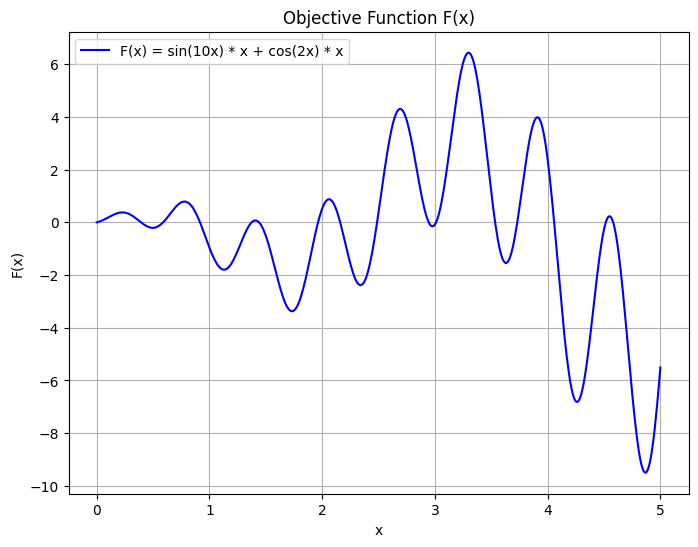

In [30]:
# TODO: draw the curve of this objective function
# Define the range of x from 0 to 5
x = np.linspace(0, 5, 500)

# Compute F(x) for the defined range of x
y = F(x)

# Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(x, y, label="F(x) = sin(10x) * x + cos(2x) * x", color='b')
plt.title("Objective Function F(x)")
plt.xlabel("x")
plt.ylabel("F(x)")
plt.legend()
plt.grid(True)
plt.show()

# Design Fitness Function
$$ fitness(pred) =\text{pred} + 10^{-3} - \min(\text{pred}) $$

This fitness function $pred + 10^{-3} - min(pred)$ is designed carefully to address common issues in algorithms and optimize the selection process. Here's a detailed explanation:

### **Explanation**:
1. **pred**: This represents the current fitness value (or prediction) of an individual in the population. The higher the fitness, the more likely the individual will be selected in a genetic algorithm.

2. **$10^{-3}$**: This small constant is added to ensure that the fitness value never becomes zero. Even when the `pred` value is very small or equal to the minimum in the population, this small constant prevents the fitness from being zero. It helps avoid numerical issues and ensures that each individual has a non-zero fitness, which is crucial in selection mechanisms that use fitness-based probabilities.

3. $- \min(\text{pred})$: Subtracting the minimum fitness value of the population helps normalize the fitness values. By shifting all fitness values so that the minimum fitness becomes close to zero, this highlights the difference between individuals. It ensures that the worst individuals are near zero fitness, making selection mechanisms more effective by promoting fitter individuals.

### **Why This Design?**

1. **Preventing Zero Fitness**: Adding a small constant ($10^{-3}$) ensures that no fitness value becomes zero or negative. This is important for algorithms that require positive fitness values, such as selection mechanisms in genetic algorithms that rely on proportional selection.

2. **Normalization**: By subtracting the minimum fitness value, the function ensures that the least fit individuals are near zero. This scaling helps selection mechanisms function more effectively, preventing the worst individuals from dominating and allowing fitter individuals to have a higher chance of selection.

3. **Fine Adjustment**: The addition of $10^{-3}$ is a small adjustment to ensure that no individual has exactly zero fitness, which is important for algorithms that require positive probabilities for selection.

### **Summary**:

This fitness function is designed to:
- Normalize fitness values by subtracting the minimum fitness.
- Ensure no individual has zero or negative fitness by adding a small constant.
- Smoothly scale fitness values to make sure selection mechanisms (like in genetic algorithms) work effectively, increasing the likelihood of selecting fitter individuals.

## You can also design other fitness functions.

## HW3.2 Fitness Function
Write the Fitness Function:
$$ \text{pred} + 10^{-3} - \min(\text{pred}) $$

In [31]:
def get_fitness(pred):
    # TODO: Write the Fitness Function and return the fitness value
    # pred is an array of predicted values (fitness values for individuals)
    return pred + 10**-3 - np.min(pred)

## HW3.3 Representation
Design a function **`translateDNA(pop)`** to convert binary-encoded DNA (gene sequences) into a real number, used in genetic algorithms to map binary genes to a value within a specified range.

### **Input**:
- **`pop`**: A 2D array where each row represents an individual's DNA, encoded as a binary sequence.

### **Output**:
- A 1D array of real values, where the binary DNA has been converted to real numbers and scaled according to `X_BOUND[1]`.

### **Explanation**:
- The function converts the binary DNA representation into a real number by treating the binary sequence as a number in base-2, normalizing it by dividing by the maximum possible value, and scaling it to fit within the specified bounds (`X_BOUND[1]`).

In [32]:
def translateDNA(pop):
    # pop is a 2D array where each row is a binary-encoded individual
    # Convert binary DNA (base 2) to decimal
    pop_decimal = pop.dot(2 ** np.arange(DNA_SIZE)[::-1])

    # Normalize the decimal value by dividing by the maximum possible value
    # Maximum possible value is 2^DNA_SIZE - 1
    max_value = 2 ** DNA_SIZE - 1
    normalized_value = pop_decimal / max_value

    # Scale the normalized value to the desired range [X_BOUND[0], X_BOUND[1]]
    real_value = X_BOUND[0] + normalized_value * (X_BOUND[1] - X_BOUND[0])

    return real_value

# HW3.4 Selection
Write a function **`select(pop, fitness)`** to implement a natural selection process in a genetic algorithm. It selects individuals from the population (pop) based on their fitness values (fitness), where fitter individuals have a higher probability of being selected for the next generation.

Tip: You can normalize fitness into a probability distribution using `p = fitness / fitness.sum()`, ensuring that the sum of all individuals equals 1. The higher the fitness of an individual, the greater its chance of being selected, but every individual still has a chance of being chosen.
### **Input**:
1. **`pop`**: A 2D array representing the population, where each row is an individual's genetic sequence (DNA).
2. **`fitness`**: A 1D array representing the fitness values of the individuals in the population.

### **Output**:
- **`pop[idx]`**: A 2D array representing the selected population for the next generation, with individuals chosen based on their fitness values.

In [33]:
def select(pop, fitness):    # nature selection wrt pop's fitness
    # TODO: Write the select Function and return a 2D array representing the selected population for the next generation
    # Normalize the fitness values to probabilities
    probabilities = fitness / fitness.sum()

    # Randomly select individuals based on their fitness probabilities
    # We use np.random.choice with the population size and probabilities
    idx = np.random.choice(np.arange(POP_SIZE), size=POP_SIZE, replace=True, p=probabilities)

    # Return the selected population based on the selected indices
    return pop[idx]

## HW3.5 Crossover
Write a function **`crossover(parent, pop)`** to implement the crossover (mating) process in a genetic algorithm. During crossover, two individuals exchange some of their genetic material to produce a new individual (child).
### **Input**:
1. **`parent`**: A 1D array representing an individual's genetic sequence (DNA).
2. **`pop`**: A 2D array representing the population, where each row is an individual.

### **Output**:
- **`parent`**: A 1D array, either modified (after crossover) or unmodified (if no crossover occurs).


In [34]:
def crossover(parent, pop):
    # TODO: Write the crossover Function and return a 1D array of parent
    if np.random.rand() < CROSS_RATE:  # With probability CROSS_RATE, perform crossover
        # Randomly select another individual from the population
        i = np.random.randint(0, POP_SIZE, size=1)
        crossover_point = np.random.randint(0, DNA_SIZE)  # Random crossover point
        # Crossover: exchange the genetic material from the crossover point
        parent[crossover_point:] = pop[i, crossover_point:]

    return parent

## HW3.6 Mutation
Write a function **`mutate()`** to perform a mutation operation in a genetic algorithm, which introduces small random changes in an individual's genetic sequence (DNA). Mutation helps maintain genetic diversity within the population.
### **Input**:
1. **`child`**: A 1D array representing an individual's genetic sequence (DNA), where each element is typically a binary value (0 or 1).

### **Output**:
- **`child`**: The modified genetic sequence after mutation, where certain genes may have flipped from 0 to 1 or from 1 to 0 based on the mutation rate.

### **Explanation**:
- The function iterates through each gene in the `child` DNA sequence. For each gene, with a probability determined by `MUTATION_RATE`, the gene may undergo mutation, flipping from 0 to 1 or from 1 to 0. This introduces genetic diversity into the population.


In [35]:
def mutate(child):
    # TODO: Write the mutation Function and return the child
    for point in range(DNA_SIZE):
        if np.random.rand() < MUTATION_RATE:  # With probability MUTATION_RATE, perform mutation
            # Flip the gene: if it's 0, change to 1; if it's 1, change to 0
            child[point] = 1 if child[point] == 0 else 0
    return child

## HW3.7 GA Function
Write a function GA() that implements a basic genetic algorithm (GA) that evolves a population over many generations to optimize the function F() based on the function you wrote above.
### **Input**:

1. **`N_GENERATIONS`**: An integer representing the number of generations (iterations) the genetic algorithm will run.
2. **`pop`**: A 2D array where each row represents an individual's DNA sequence encoded in binary (the initial population).

### **Output**:
- **`performance`**: A list that records the sum of fitness values (`F_values.sum()`) for each generation. This allows the user to analyze how the overall fitness of the population evolves across generations. Additionally, for each generation, a scatter plot is generated to visually represent the solutions' progression.
- **`time_per_iteration`**: A list used to record the computation time for each generation.

In [50]:
performance = []
time_per_iteration = []

def GA(N_GENERATIONS, pop):
    # TODO: Write the GA Function that evolves a population over many generations to optimize the function F() based on the function you wrote above.

    for generation in range(N_GENERATIONS):
        start_time = time.time()  # 計時開始

        # Step 1: 將二進制DNA轉換為實數
        real_values = translateDNA(pop)

        # Step 2: 計算每個個體的目標函數值
        F_values = F(real_values)

        # Step 3: 計算每個個體的適應度
        fitness = get_fitness(F_values)

        # Step 4: 記錄這一代的總適應度
        performance.append(F_values.sum())

        # Step 5: 自然選擇，選出下一代的種群
        pop = select(pop, fitness)

        # Step 6: 進行交叉和突變
        pop_copy = pop.copy()
        for parent in pop:
            child = crossover(parent, pop_copy)
            child = mutate(child)
            parent[:] = child  # 更新父代為變異後的子代

        # Step 7: 記錄每代的計算時間
        end_time = time.time()
        time_per_iteration.append(end_time - start_time)

        # 打印當前代的資訊
        print(f"Generation: {generation}")
        print(f"Max F_values: {F_values.max()}")
        print(f"Time for Generation {generation}: {time_per_iteration[-1]:.4f} seconds")

        # 繪製進度的散點圖（可選）
        if generation % 1 == 0:  # 每10代進行一次繪圖
            plt.scatter(real_values, F_values, c='red', alpha=0.5)
            plt.title(f"Generation {generation}")
            plt.xlabel("Real Values")
            plt.ylabel("F(x)")
            plt.show()

    return performance, time_per_iteration


Generation: 0
Max F_values: 6.40262357270129
Time for Generation 0: 0.0061 seconds


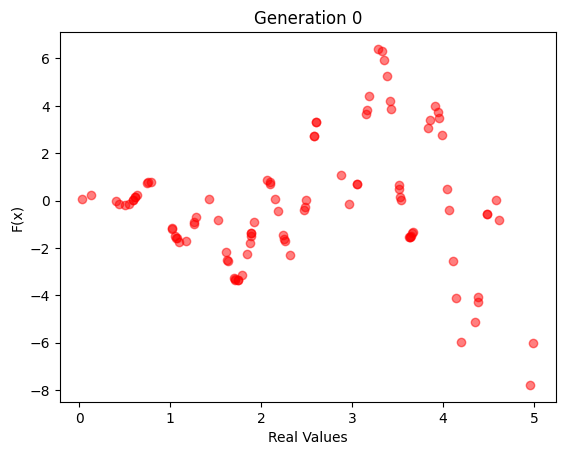

Generation: 1
Max F_values: 6.421816483484863
Time for Generation 1: 0.0057 seconds


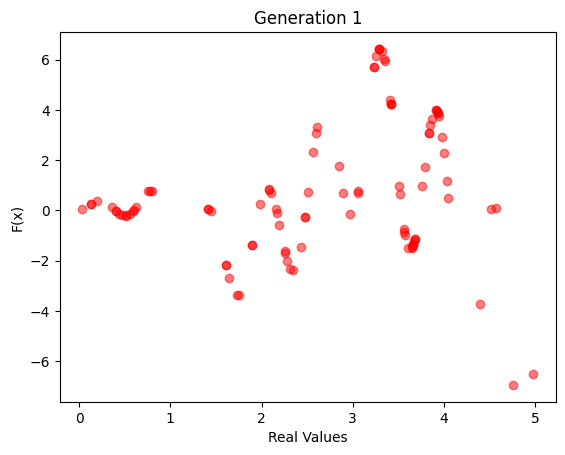

Generation: 2
Max F_values: 6.435822320543684
Time for Generation 2: 0.0038 seconds


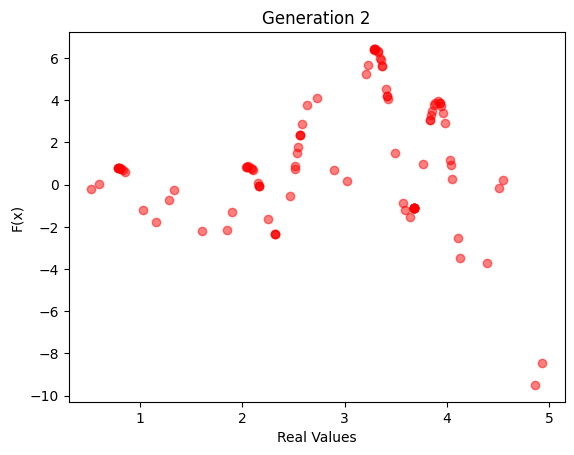

Generation: 3
Max F_values: 6.435822320543684
Time for Generation 3: 0.0041 seconds


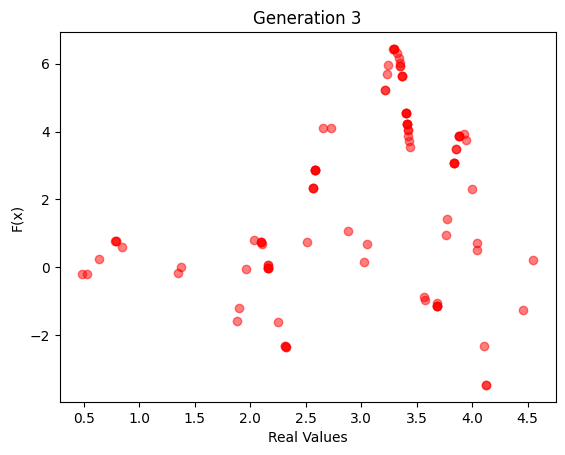

Generation: 4
Max F_values: 6.421816483484863
Time for Generation 4: 0.0035 seconds


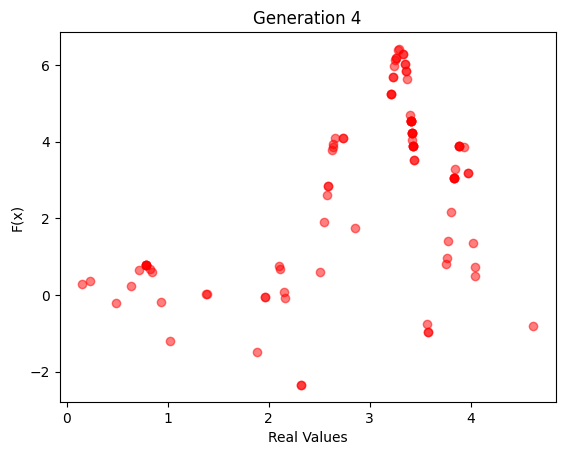

Generation: 5
Max F_values: 6.435822320543684
Time for Generation 5: 0.0036 seconds


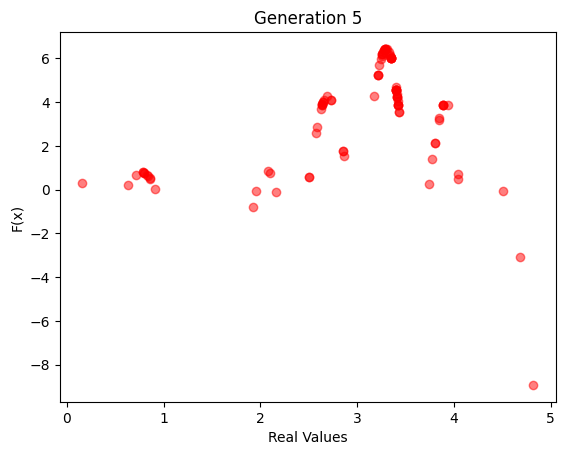

Generation: 6
Max F_values: 6.421816483484863
Time for Generation 6: 0.0034 seconds


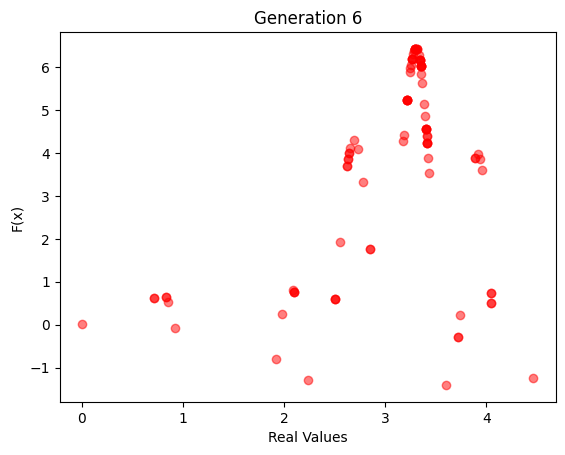

Generation: 7
Max F_values: 6.432903326858257
Time for Generation 7: 0.0036 seconds


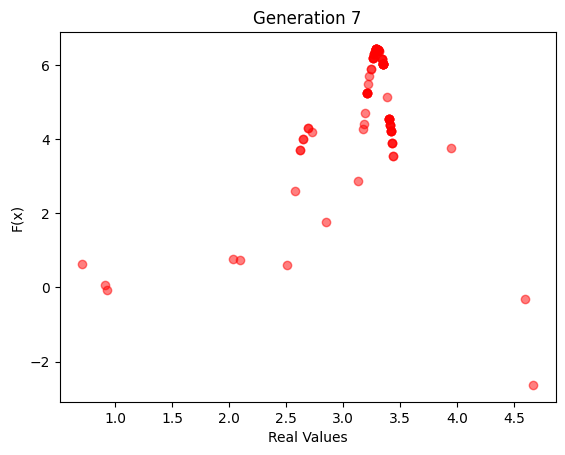

Generation: 8
Max F_values: 6.432903326858257
Time for Generation 8: 0.0103 seconds


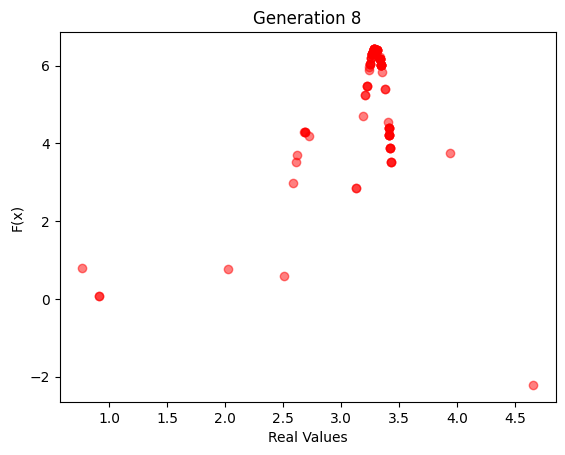

Generation: 9
Max F_values: 6.435822320543684
Time for Generation 9: 0.0046 seconds


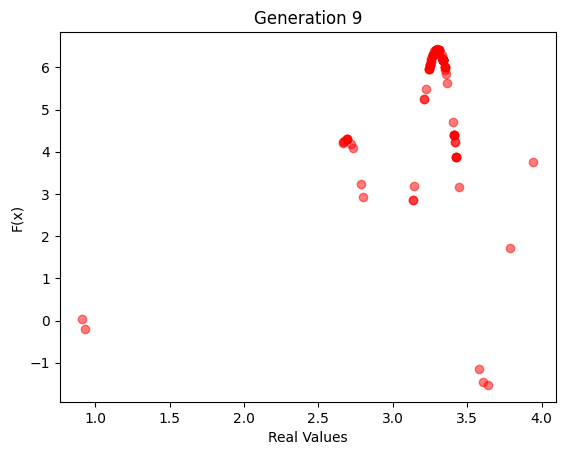

Generation: 10
Max F_values: 6.435822320543684
Time for Generation 10: 0.0039 seconds


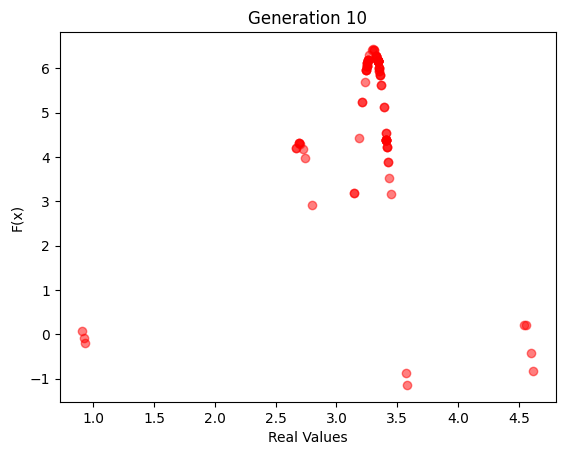

Generation: 11
Max F_values: 6.435822320543684
Time for Generation 11: 0.0043 seconds


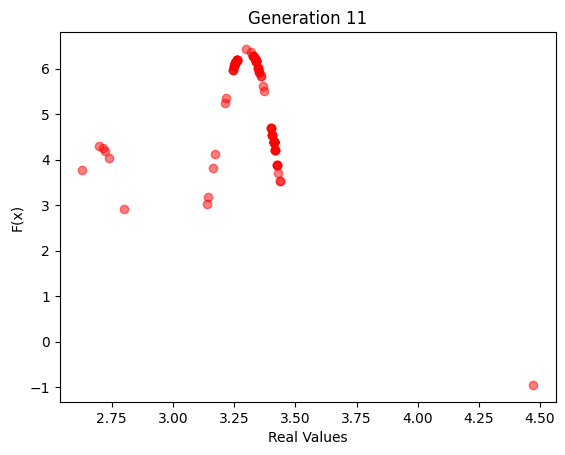

Generation: 12
Max F_values: 6.435822320543684
Time for Generation 12: 0.0041 seconds


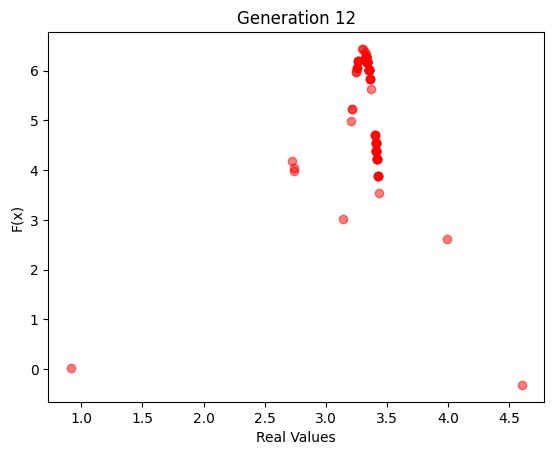

Generation: 13
Max F_values: 6.435822320543684
Time for Generation 13: 0.0056 seconds


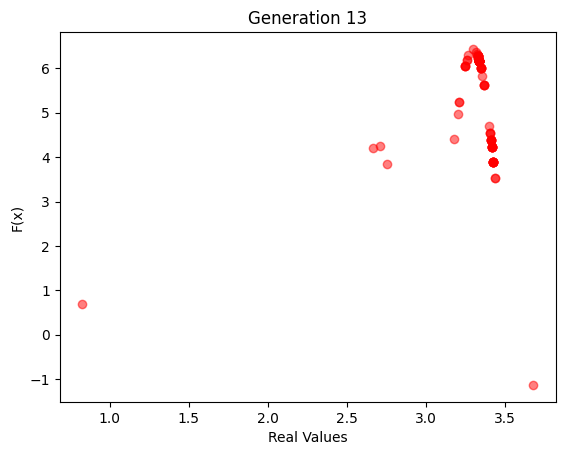

Generation: 14
Max F_values: 6.435822320543684
Time for Generation 14: 0.0068 seconds


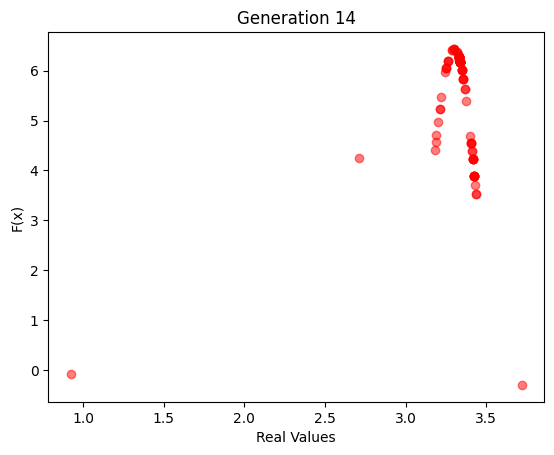

Generation: 15
Max F_values: 6.435822320543684
Time for Generation 15: 0.0050 seconds


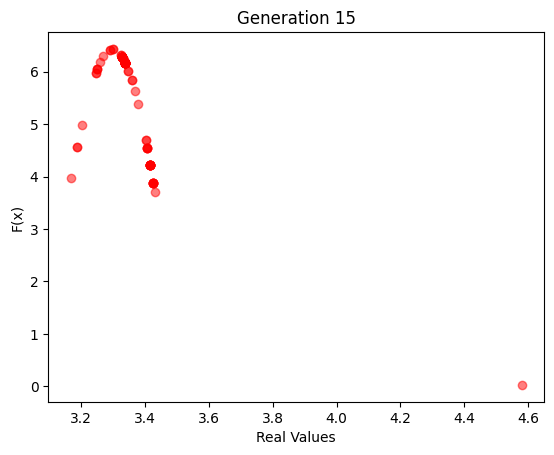

Generation: 16
Max F_values: 6.421816483484863
Time for Generation 16: 0.0050 seconds


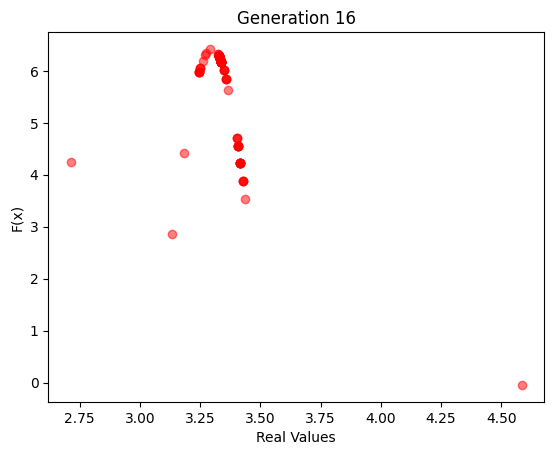

Generation: 17
Max F_values: 6.421816483484863
Time for Generation 17: 0.0088 seconds


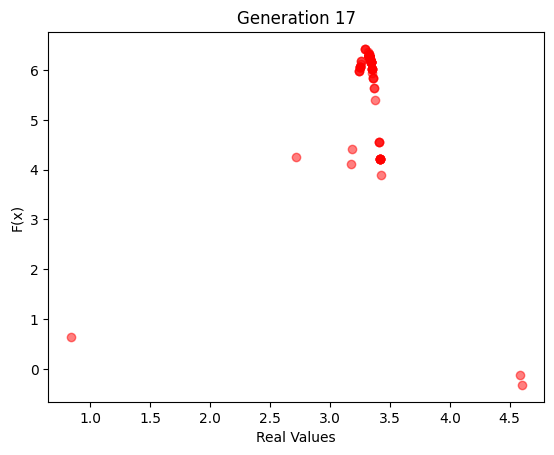

Generation: 18
Max F_values: 6.421816483484863
Time for Generation 18: 0.0044 seconds


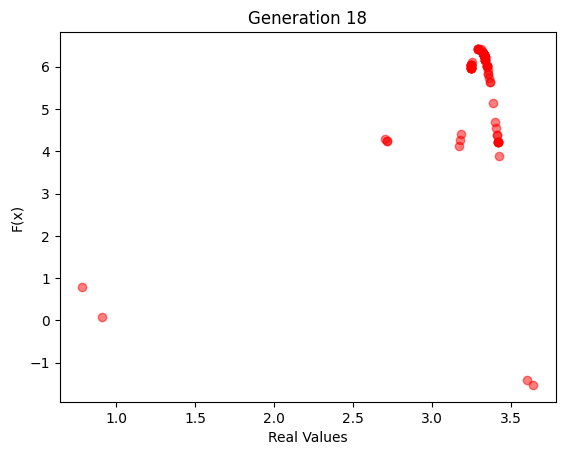

Generation: 19
Max F_values: 6.432903326858257
Time for Generation 19: 0.0045 seconds


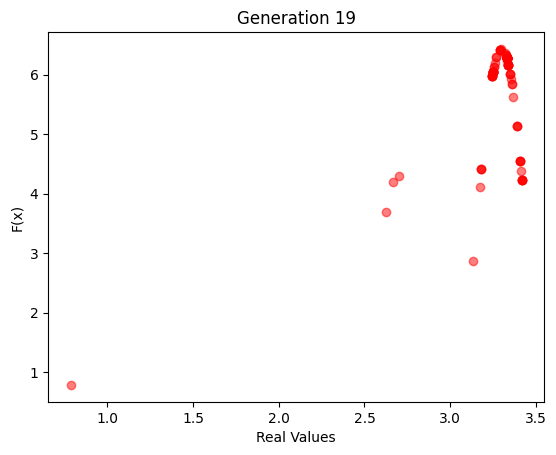

Generation: 20
Max F_values: 6.432903326858257
Time for Generation 20: 0.0060 seconds


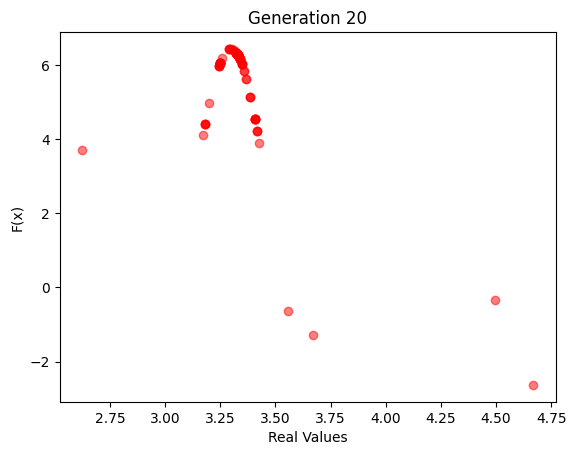

Generation: 21
Max F_values: 6.432903326858257
Time for Generation 21: 0.0038 seconds


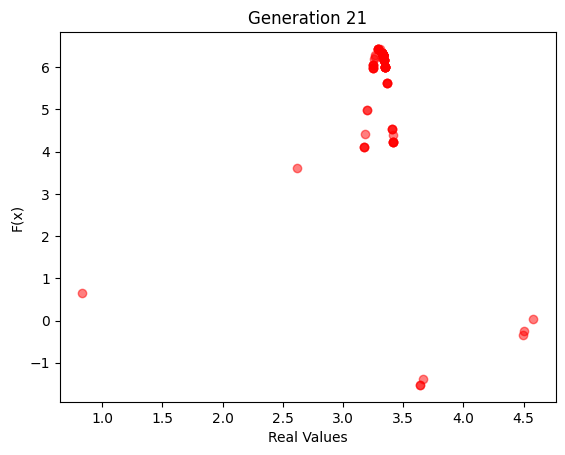

Generation: 22
Max F_values: 6.432903326858257
Time for Generation 22: 0.0044 seconds


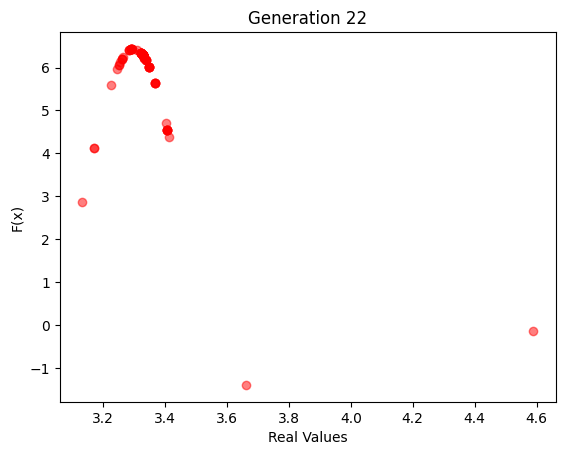

Generation: 23
Max F_values: 6.432903326858257
Time for Generation 23: 0.0048 seconds


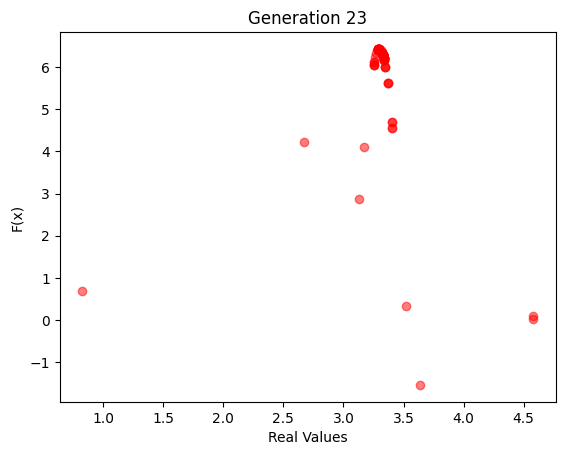

Generation: 24
Max F_values: 6.435822320543684
Time for Generation 24: 0.0044 seconds


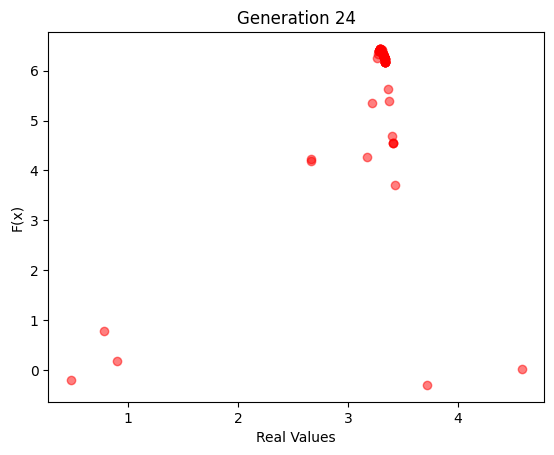

Generation: 25
Max F_values: 6.435822320543684
Time for Generation 25: 0.0044 seconds


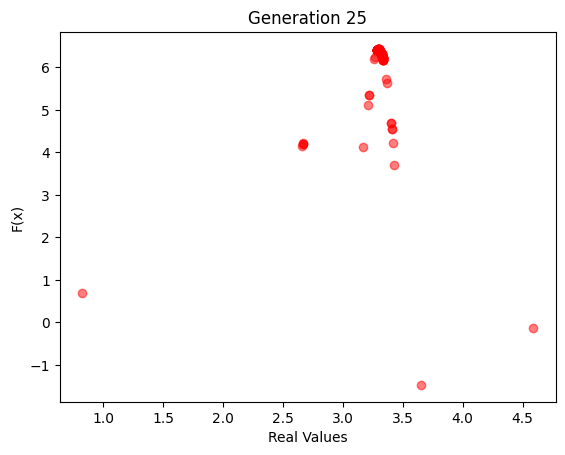

Generation: 26
Max F_values: 6.435822320543684
Time for Generation 26: 0.0049 seconds


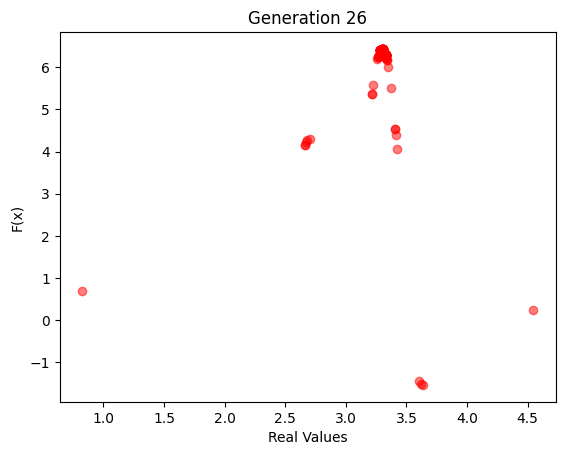

Generation: 27
Max F_values: 6.435822320543684
Time for Generation 27: 0.0053 seconds


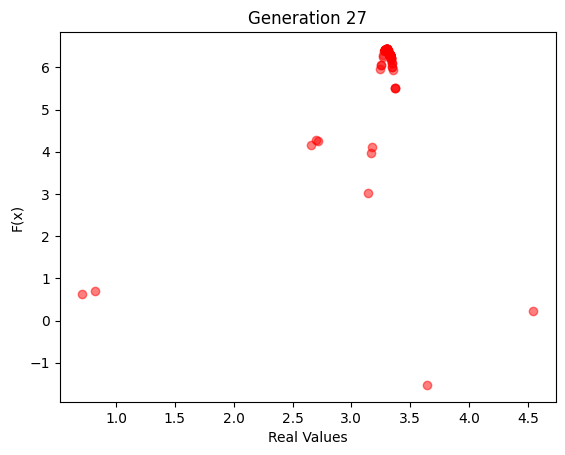

Generation: 28
Max F_values: 6.435822320543684
Time for Generation 28: 0.0047 seconds


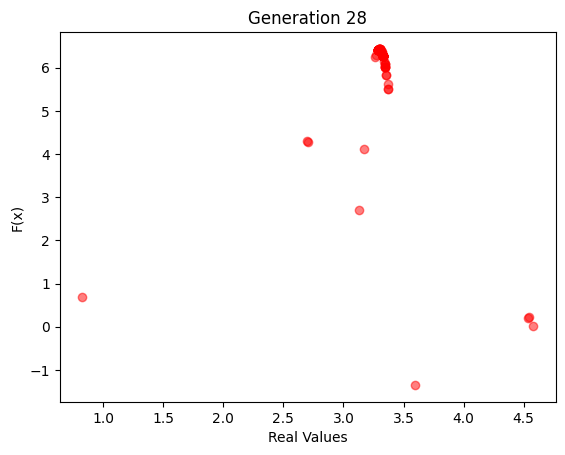

Generation: 29
Max F_values: 6.432903326858257
Time for Generation 29: 0.0058 seconds


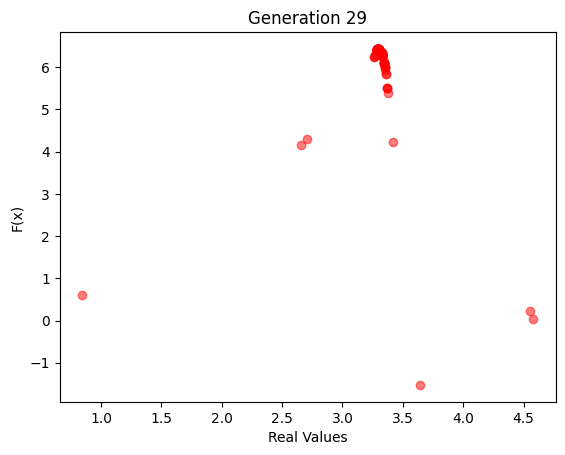

Generation: 30
Max F_values: 6.432903326858257
Time for Generation 30: 0.0058 seconds


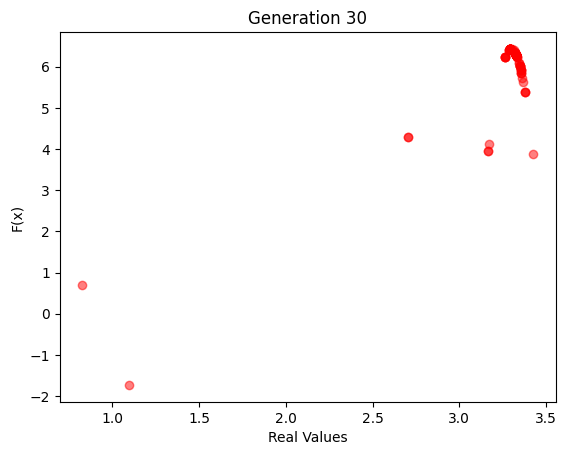

Generation: 31
Max F_values: 6.432903326858257
Time for Generation 31: 0.0051 seconds


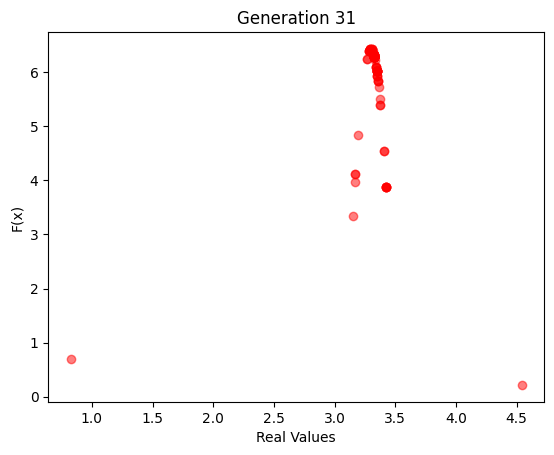

Generation: 32
Max F_values: 6.430530388062344
Time for Generation 32: 0.0048 seconds


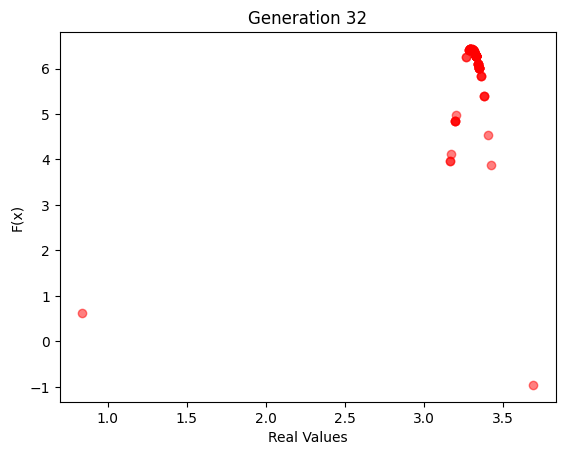

Generation: 33
Max F_values: 6.430530388062344
Time for Generation 33: 0.0043 seconds


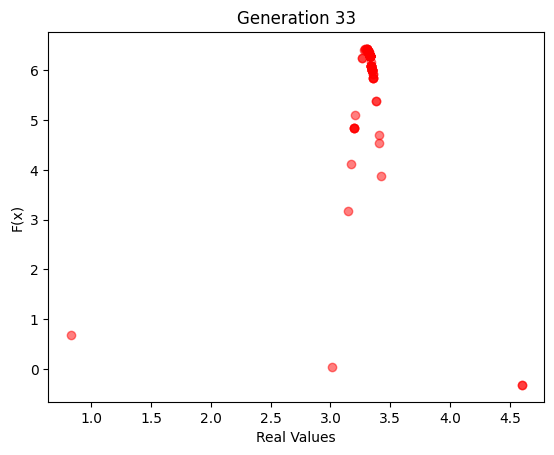

Generation: 34
Max F_values: 6.435822320543684
Time for Generation 34: 0.0042 seconds


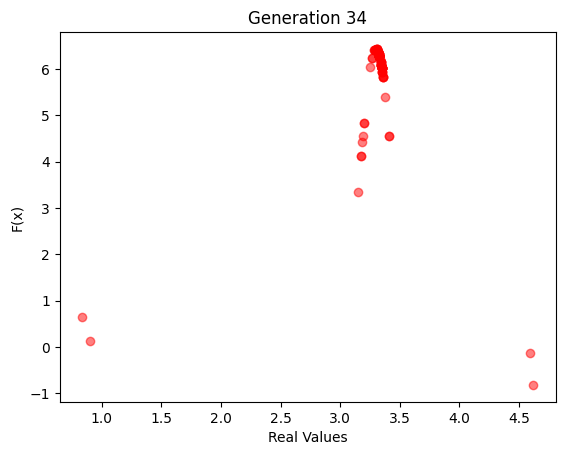

Generation: 35
Max F_values: 6.435822320543684
Time for Generation 35: 0.0040 seconds


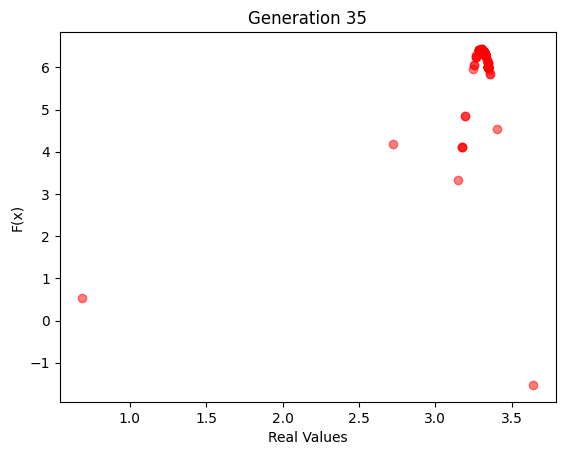

Generation: 36
Max F_values: 6.435822320543684
Time for Generation 36: 0.0049 seconds


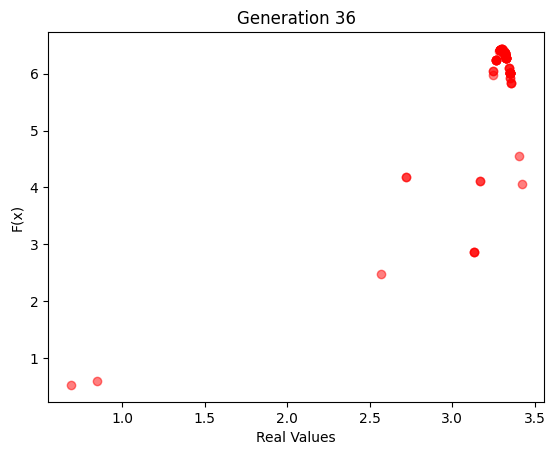

Generation: 37
Max F_values: 6.430530388062344
Time for Generation 37: 0.0044 seconds


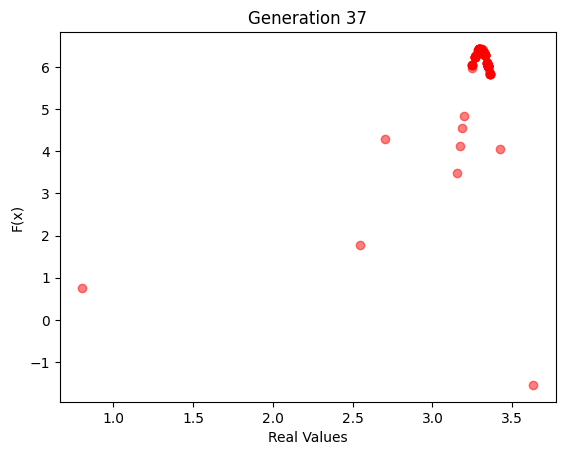

Generation: 38
Max F_values: 6.430530388062344
Time for Generation 38: 0.0048 seconds


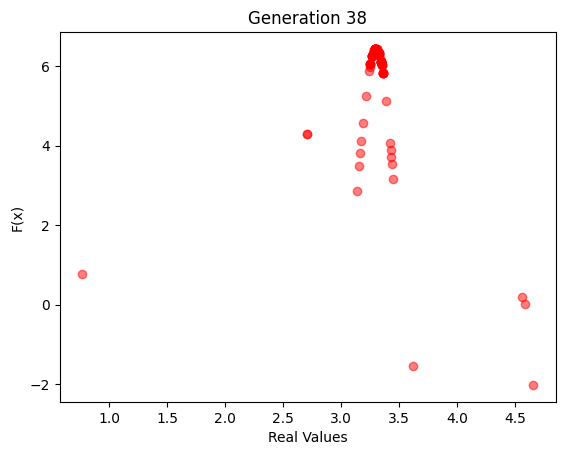

Generation: 39
Max F_values: 6.435822320543684
Time for Generation 39: 0.0042 seconds


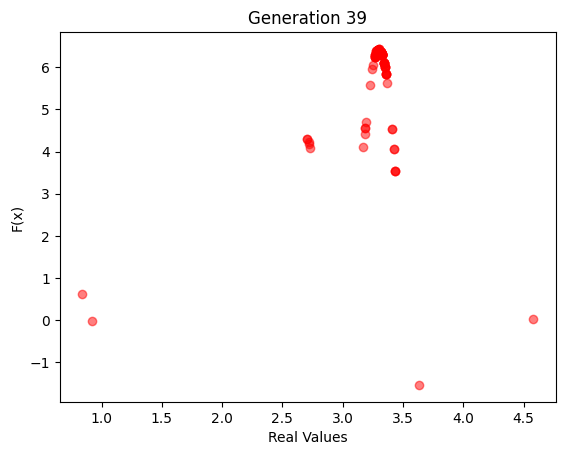

Generation: 40
Max F_values: 6.435822320543684
Time for Generation 40: 0.0043 seconds


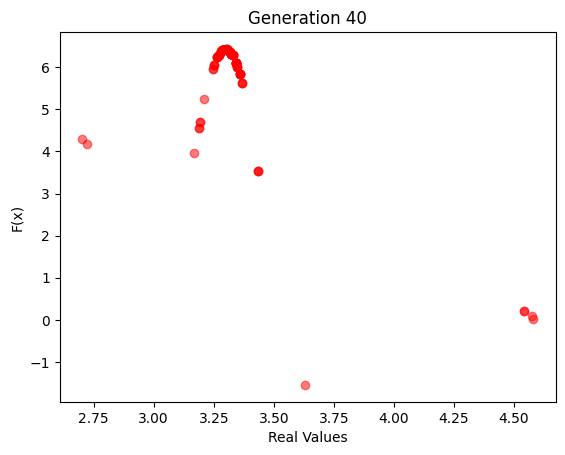

Generation: 41
Max F_values: 6.435822320543684
Time for Generation 41: 0.0050 seconds


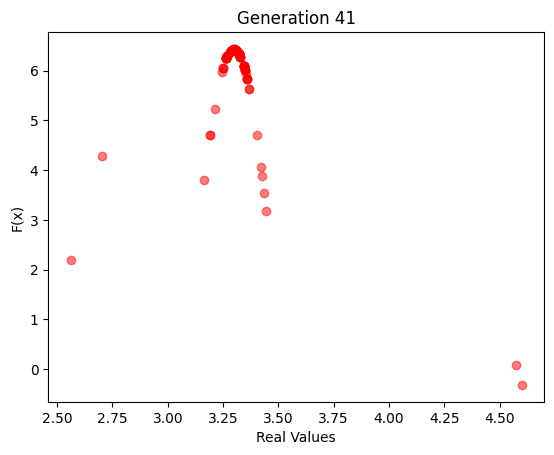

Generation: 42
Max F_values: 6.435822320543684
Time for Generation 42: 0.0042 seconds


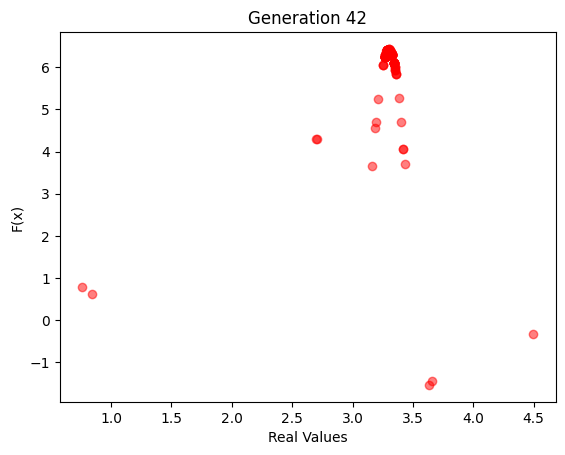

Generation: 43
Max F_values: 6.432903326858257
Time for Generation 43: 0.0054 seconds


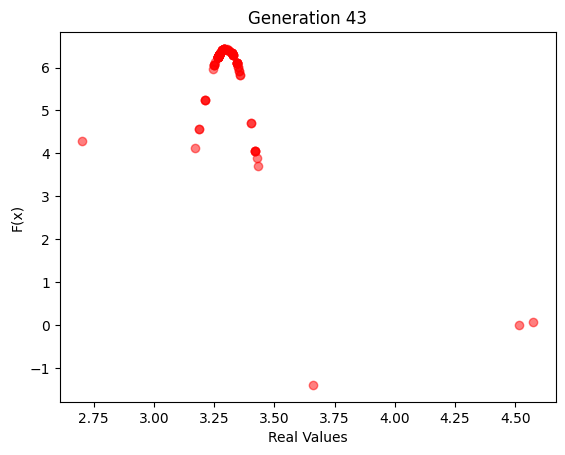

Generation: 44
Max F_values: 6.432903326858257
Time for Generation 44: 0.0037 seconds


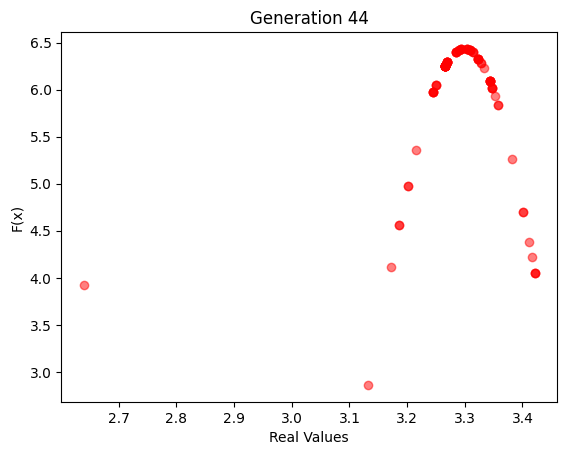

Generation: 45
Max F_values: 6.432903326858257
Time for Generation 45: 0.0048 seconds


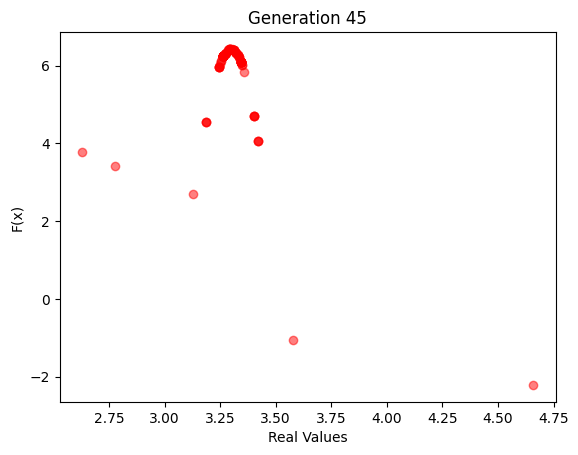

Generation: 46
Max F_values: 6.432903326858257
Time for Generation 46: 0.0056 seconds


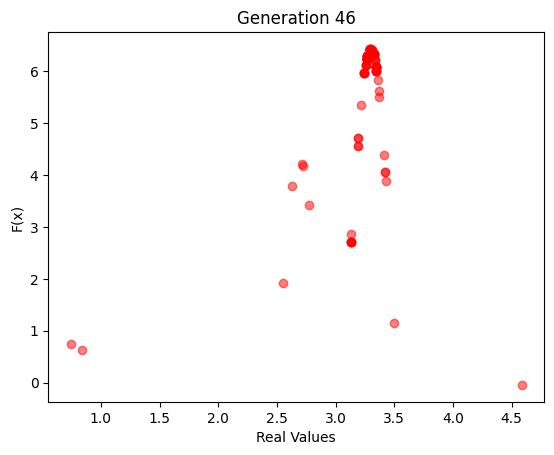

Generation: 47
Max F_values: 6.432903326858257
Time for Generation 47: 0.0041 seconds


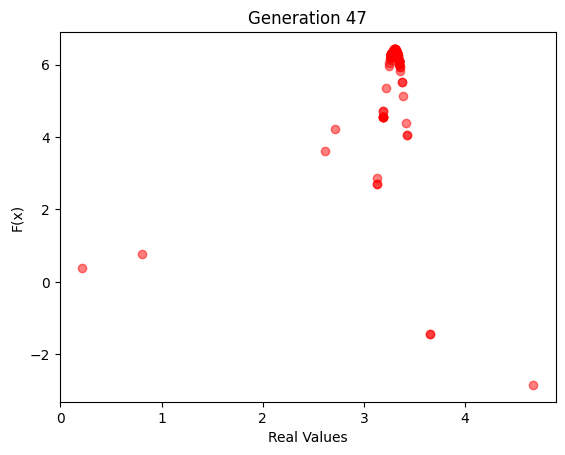

Generation: 48
Max F_values: 6.430530388062344
Time for Generation 48: 0.0036 seconds


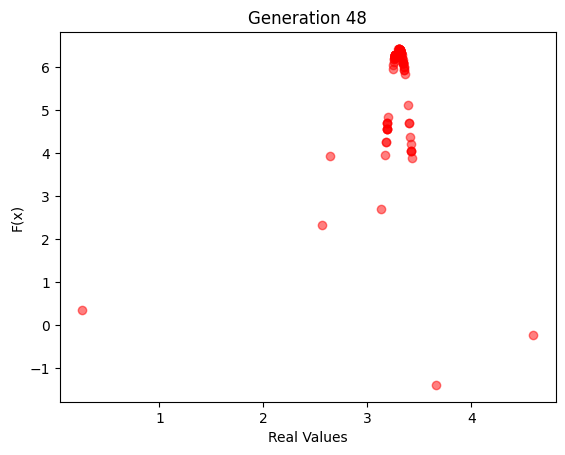

Generation: 49
Max F_values: 6.430530388062344
Time for Generation 49: 0.0037 seconds


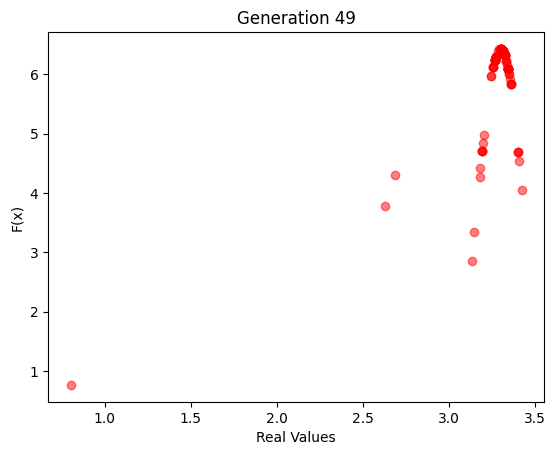

Generation: 50
Max F_values: 6.430530388062344
Time for Generation 50: 0.0038 seconds


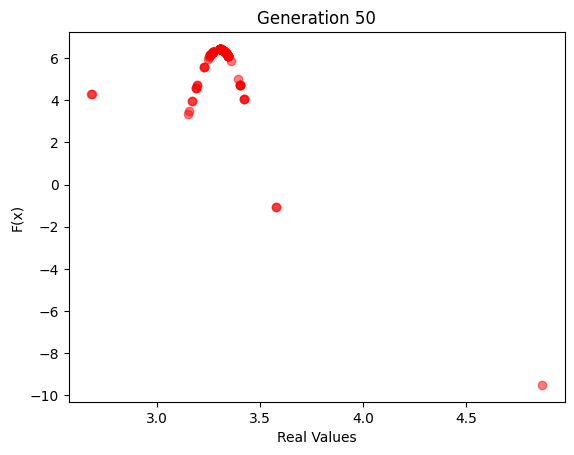

Generation: 51
Max F_values: 6.432903326858257
Time for Generation 51: 0.0036 seconds


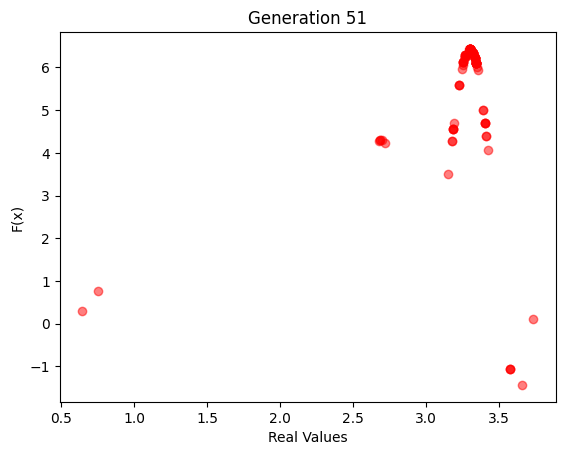

Generation: 52
Max F_values: 6.432903326858257
Time for Generation 52: 0.0034 seconds


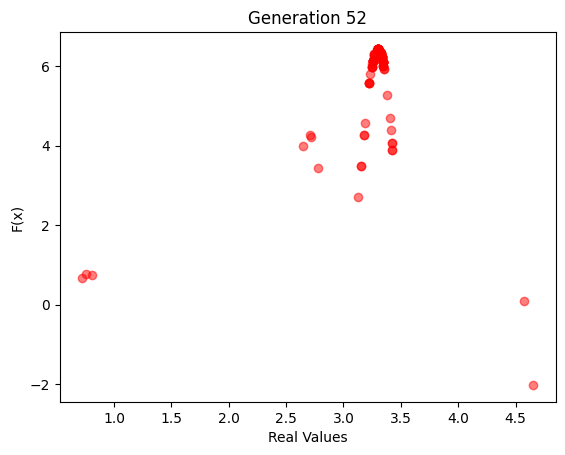

Generation: 53
Max F_values: 6.432903326858257
Time for Generation 53: 0.0037 seconds


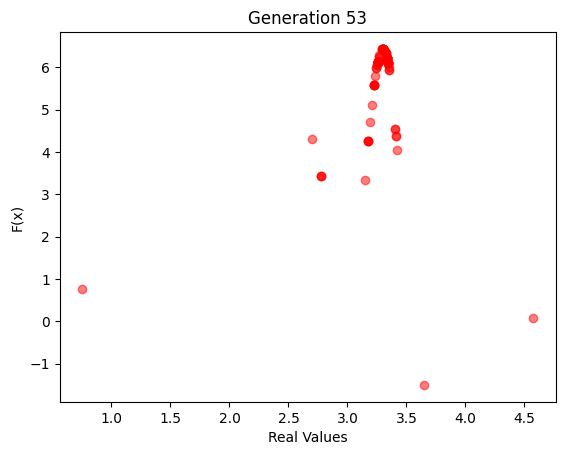

Generation: 54
Max F_values: 6.432903326858257
Time for Generation 54: 0.0046 seconds


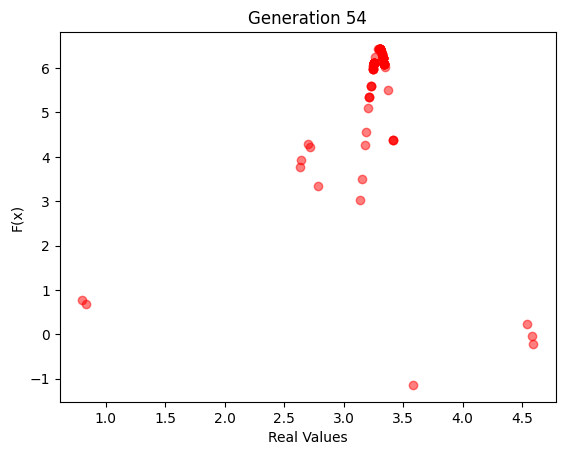

Generation: 55
Max F_values: 6.435822320543684
Time for Generation 55: 0.0040 seconds


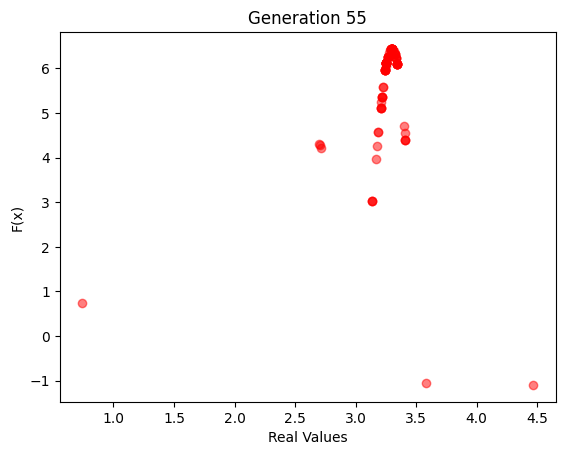

Generation: 56
Max F_values: 6.435822320543684
Time for Generation 56: 0.0035 seconds


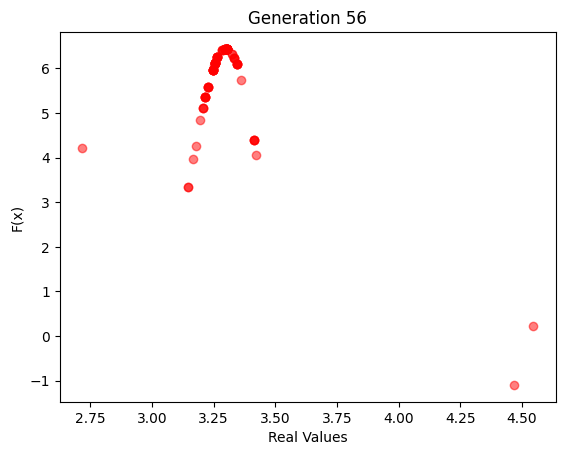

Generation: 57
Max F_values: 6.432903326858257
Time for Generation 57: 0.0053 seconds


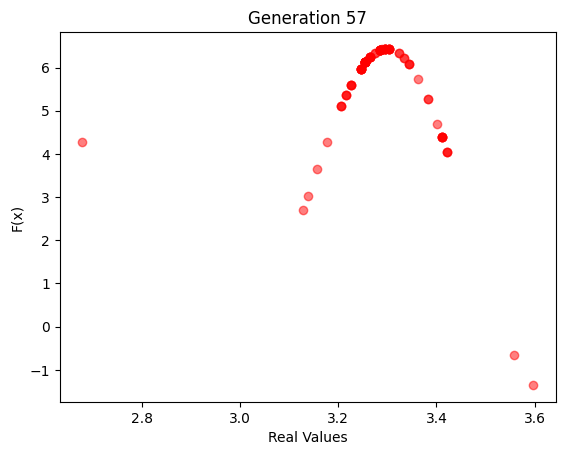

Generation: 58
Max F_values: 6.432903326858257
Time for Generation 58: 0.0047 seconds


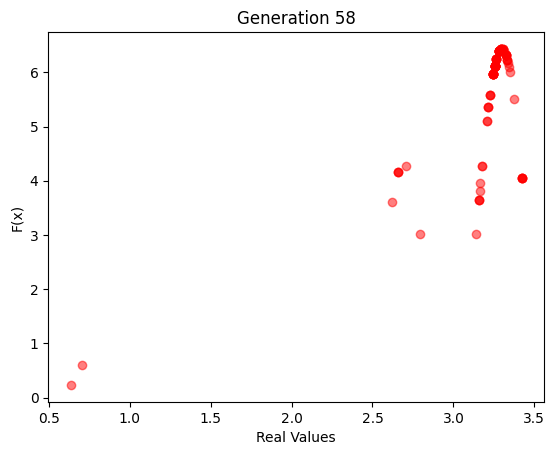

Generation: 59
Max F_values: 6.432903326858257
Time for Generation 59: 0.0046 seconds


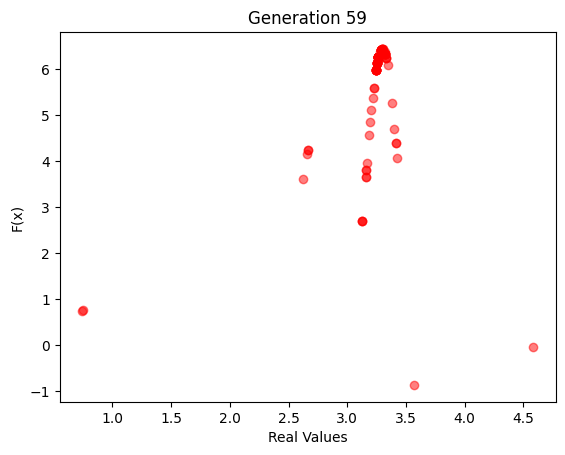

Generation: 60
Max F_values: 6.435822320543684
Time for Generation 60: 0.0040 seconds


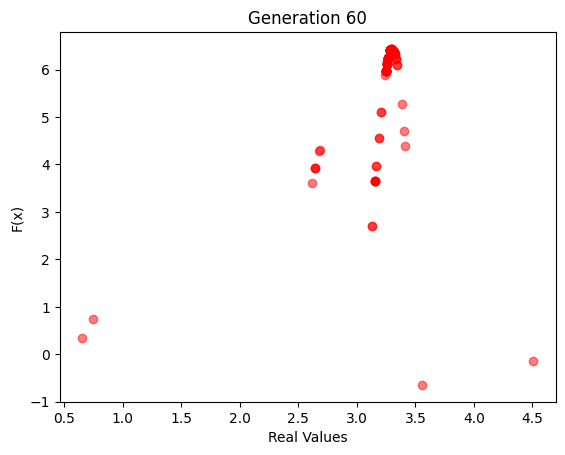

Generation: 61
Max F_values: 6.432903326858257
Time for Generation 61: 0.0080 seconds


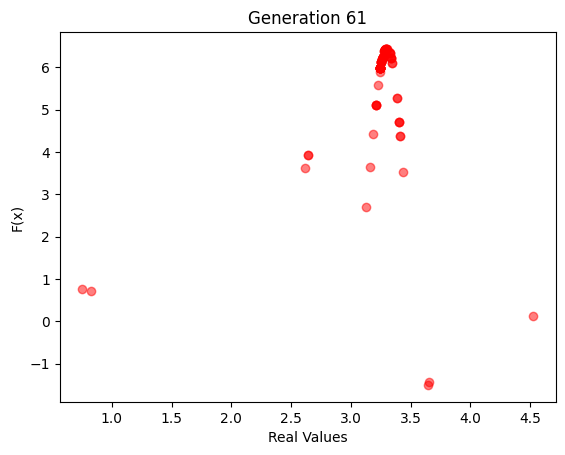

Generation: 62
Max F_values: 6.432903326858257
Time for Generation 62: 0.0041 seconds


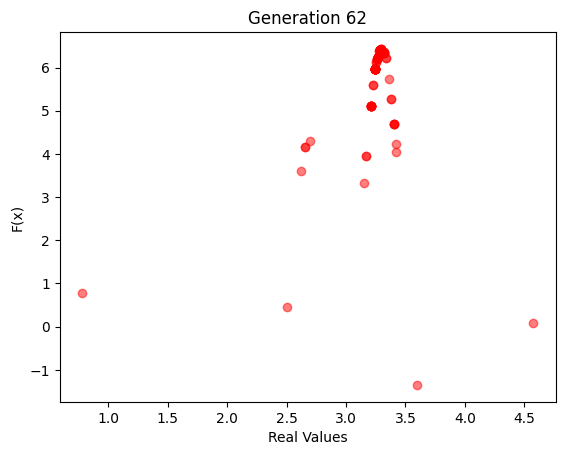

Generation: 63
Max F_values: 6.435822320543684
Time for Generation 63: 0.0055 seconds


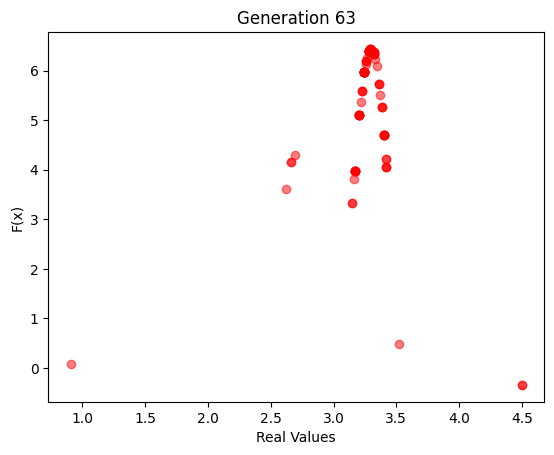

Generation: 64
Max F_values: 6.432903326858257
Time for Generation 64: 0.0074 seconds


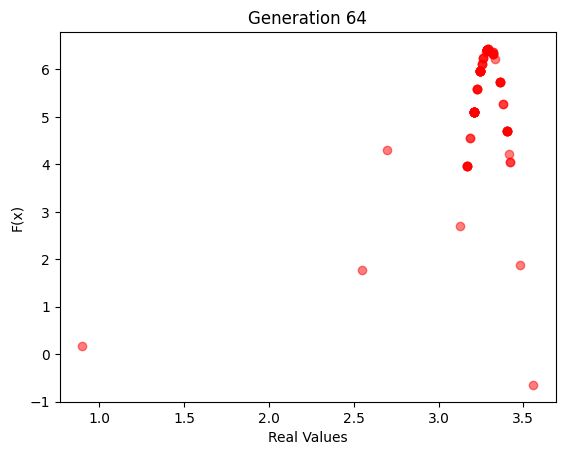

Generation: 65
Max F_values: 6.430530388062344
Time for Generation 65: 0.0044 seconds


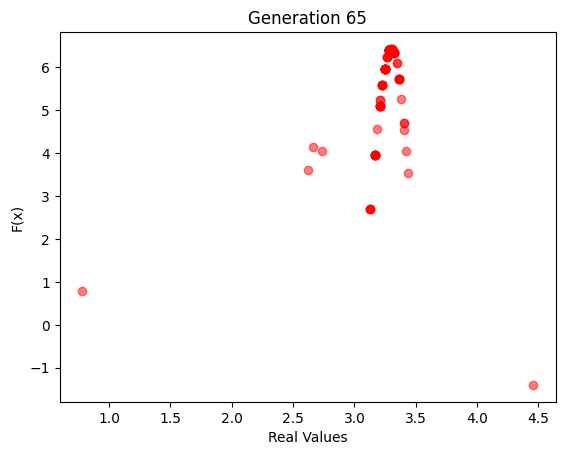

Generation: 66
Max F_values: 6.430530388062344
Time for Generation 66: 0.0041 seconds


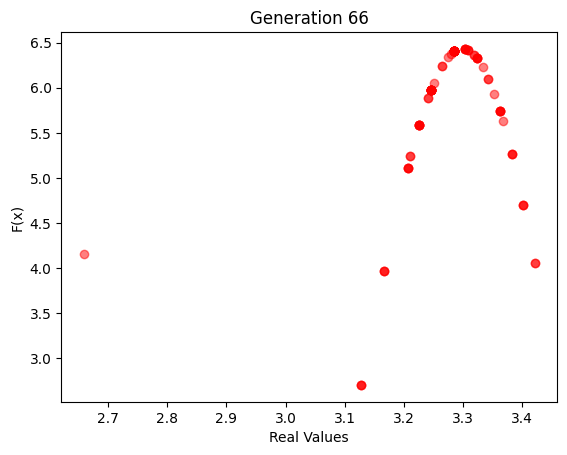

Generation: 67
Max F_values: 6.430530388062344
Time for Generation 67: 0.0065 seconds


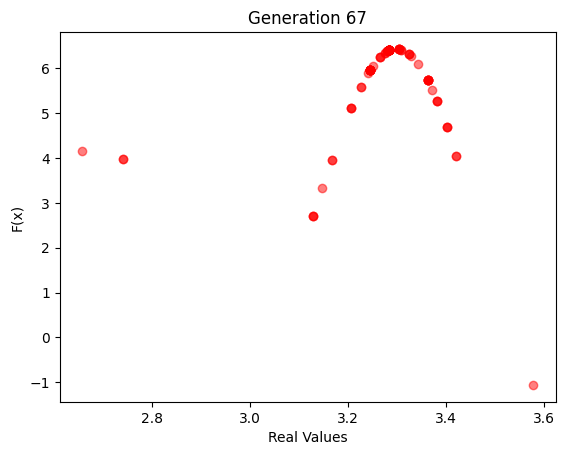

Generation: 68
Max F_values: 6.430530388062344
Time for Generation 68: 0.0035 seconds


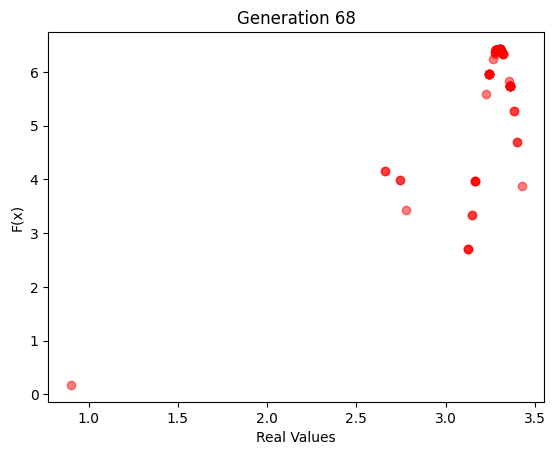

Generation: 69
Max F_values: 6.430530388062344
Time for Generation 69: 0.0052 seconds


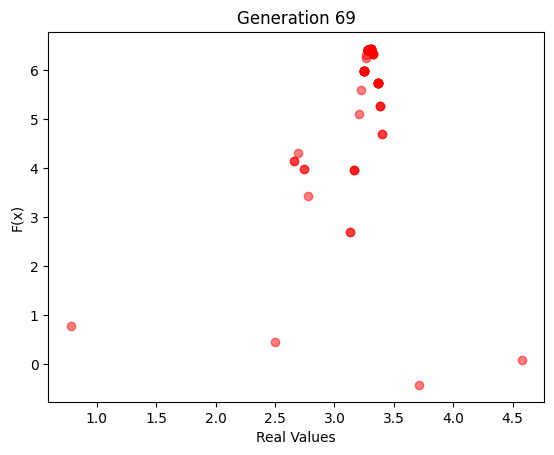

Generation: 70
Max F_values: 6.430530388062344
Time for Generation 70: 0.0049 seconds


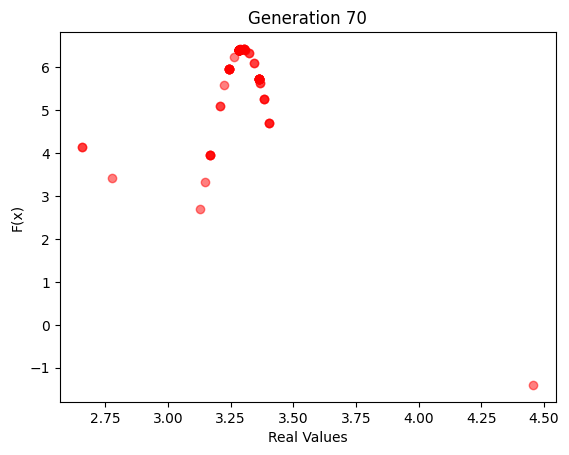

Generation: 71
Max F_values: 6.430530388062344
Time for Generation 71: 0.0038 seconds


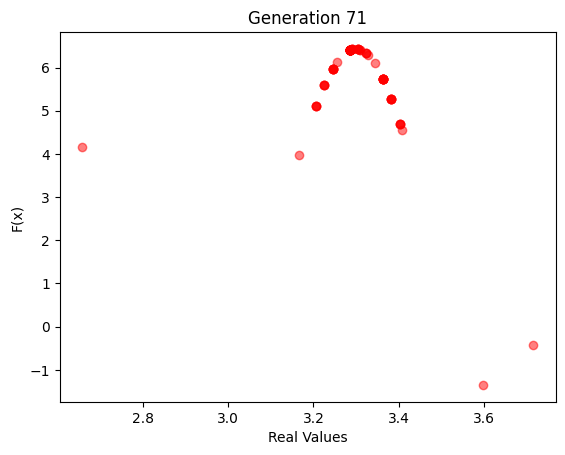

Generation: 72
Max F_values: 6.432903326858257
Time for Generation 72: 0.0042 seconds


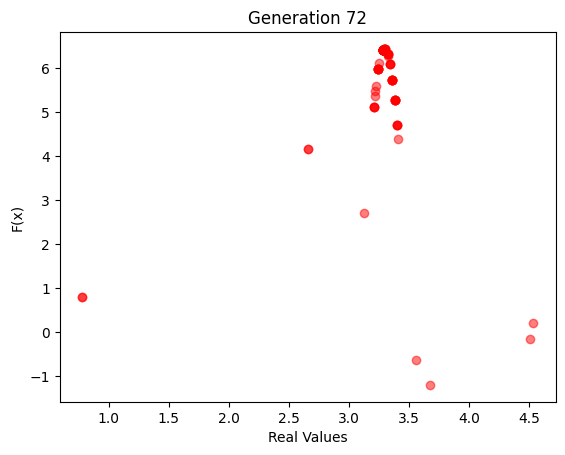

Generation: 73
Max F_values: 6.435822320543684
Time for Generation 73: 0.0042 seconds


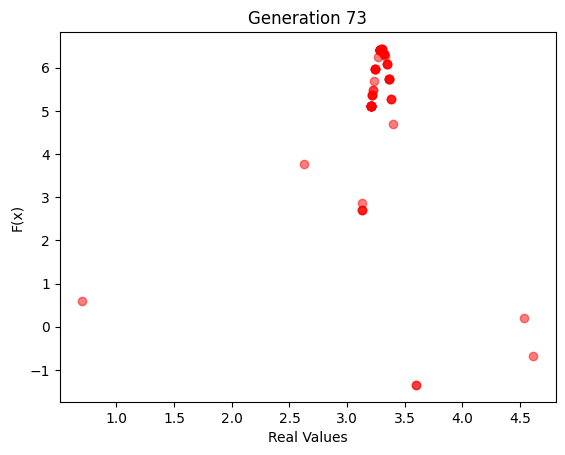

Generation: 74
Max F_values: 6.435822320543684
Time for Generation 74: 0.0045 seconds


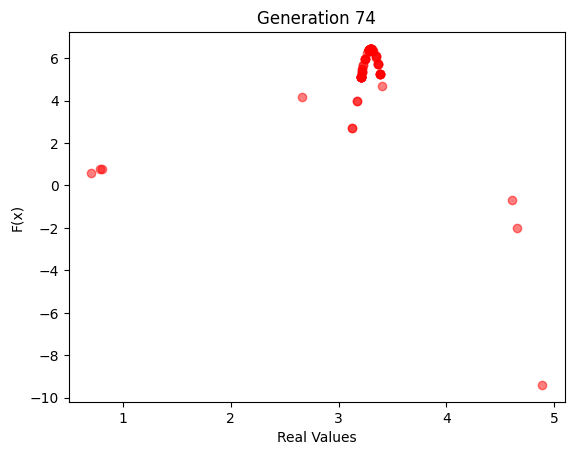

Generation: 75
Max F_values: 6.432903326858257
Time for Generation 75: 0.0041 seconds


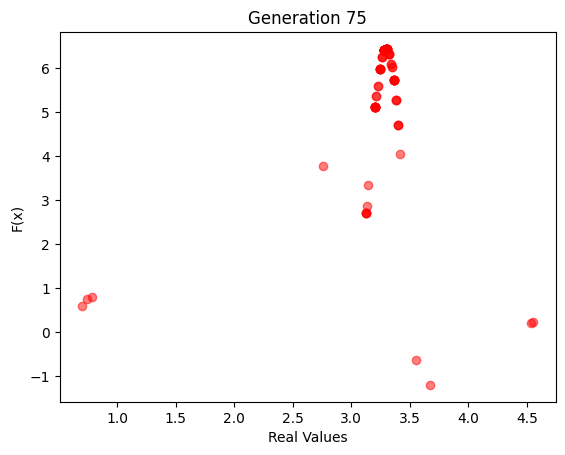

Generation: 76
Max F_values: 6.432903326858257
Time for Generation 76: 0.0053 seconds


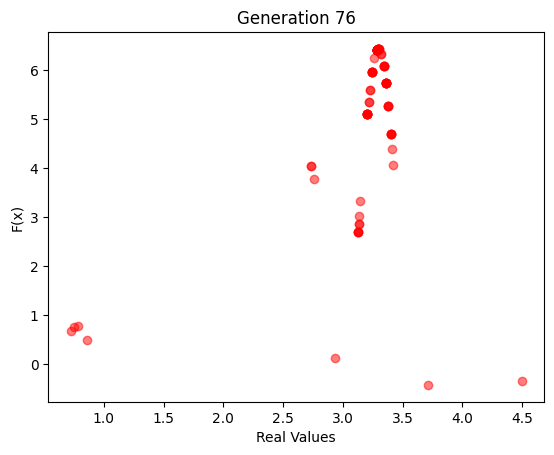

Generation: 77
Max F_values: 6.432903326858257
Time for Generation 77: 0.0052 seconds


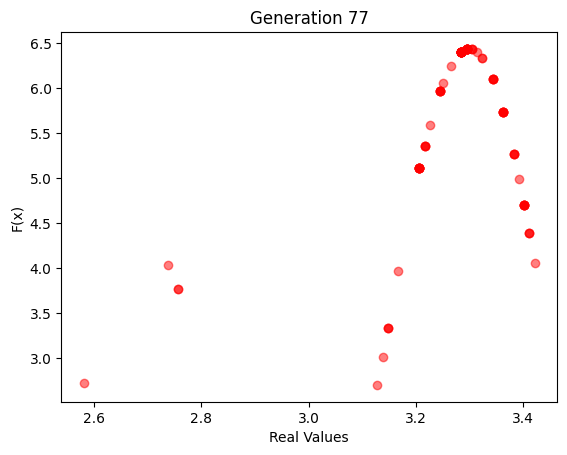

Generation: 78
Max F_values: 6.432903326858257
Time for Generation 78: 0.0046 seconds


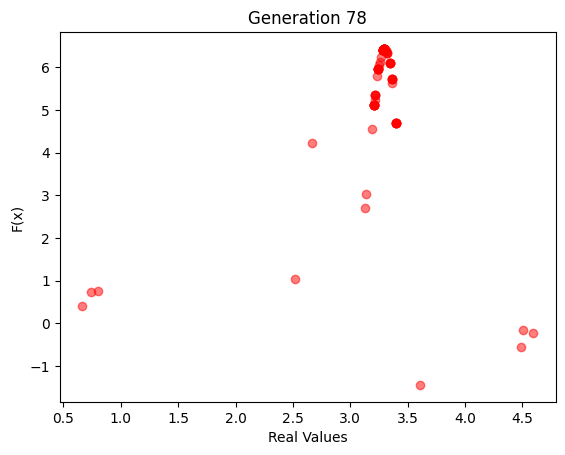

Generation: 79
Max F_values: 6.432903326858257
Time for Generation 79: 0.0054 seconds


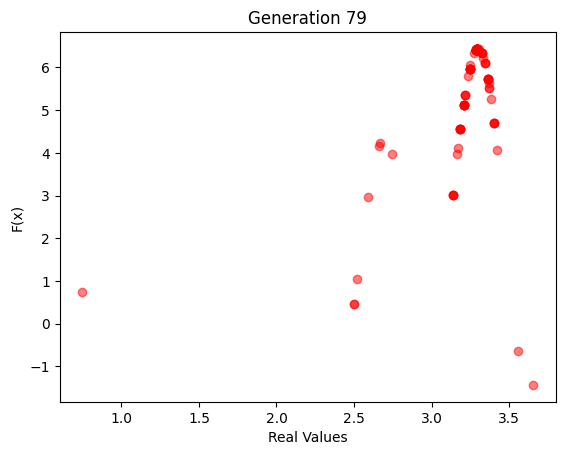

Generation: 80
Max F_values: 6.435822320543684
Time for Generation 80: 0.0055 seconds


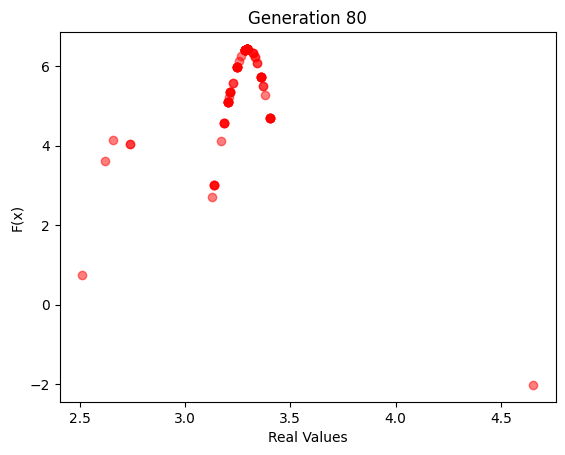

Generation: 81
Max F_values: 6.435822320543684
Time for Generation 81: 0.0035 seconds


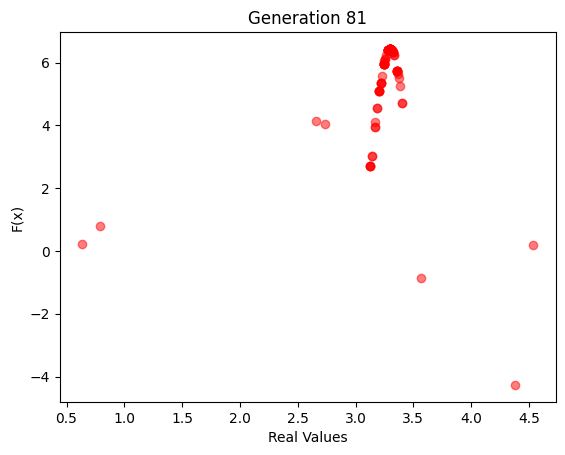

Generation: 82
Max F_values: 6.435822320543684
Time for Generation 82: 0.0105 seconds


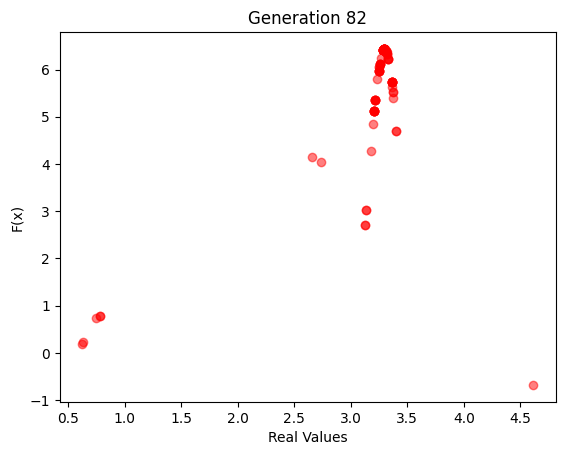

Generation: 83
Max F_values: 6.435822320543684
Time for Generation 83: 0.0042 seconds


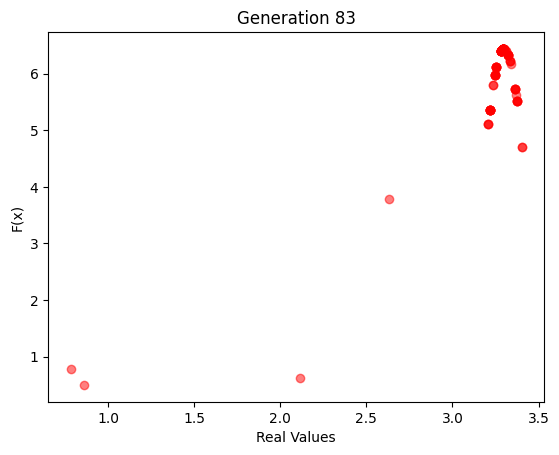

Generation: 84
Max F_values: 6.435822320543684
Time for Generation 84: 0.0040 seconds


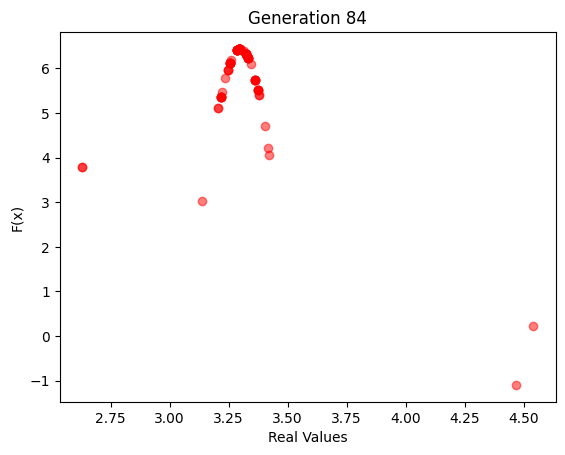

Generation: 85
Max F_values: 6.435822320543684
Time for Generation 85: 0.0045 seconds


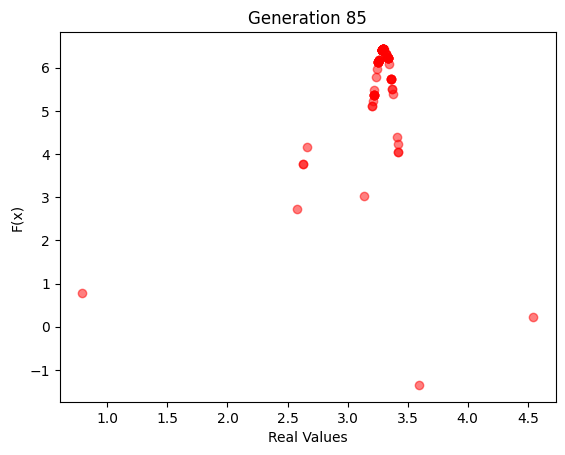

Generation: 86
Max F_values: 6.435822320543684
Time for Generation 86: 0.0045 seconds


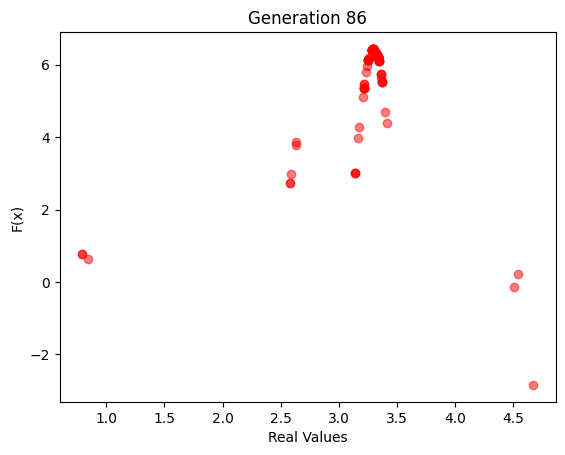

Generation: 87
Max F_values: 6.435822320543684
Time for Generation 87: 0.0042 seconds


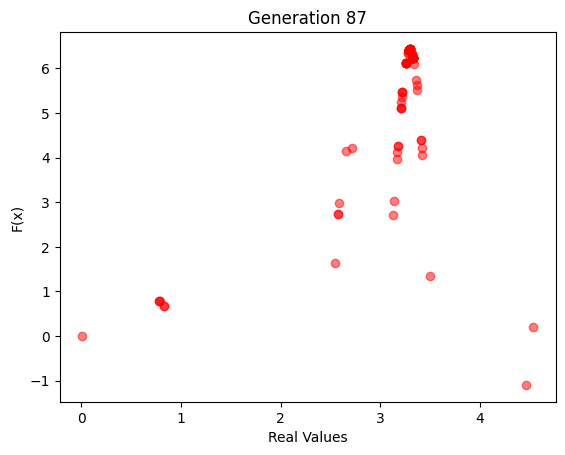

Generation: 88
Max F_values: 6.435822320543684
Time for Generation 88: 0.0063 seconds


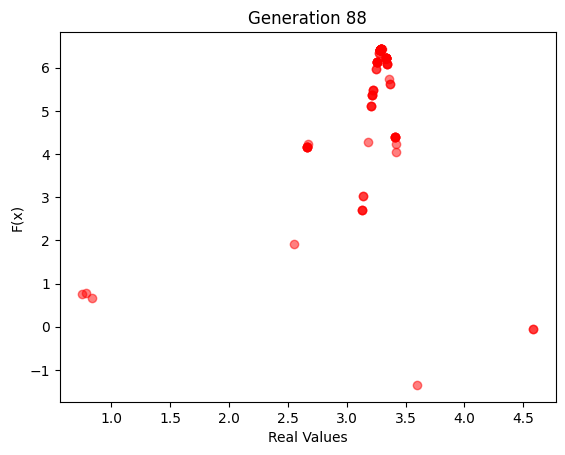

Generation: 89
Max F_values: 6.435822320543684
Time for Generation 89: 0.0052 seconds


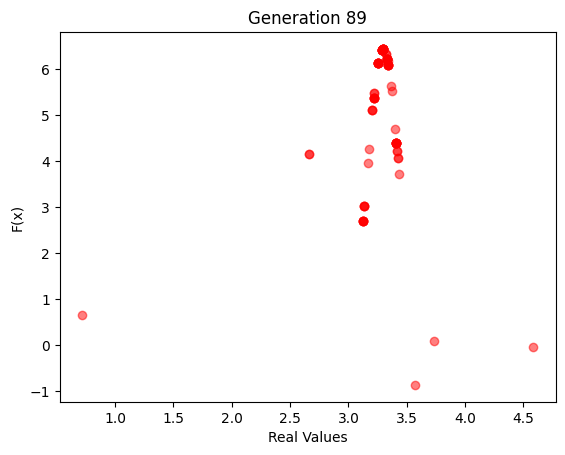

Generation: 90
Max F_values: 6.435822320543684
Time for Generation 90: 0.0055 seconds


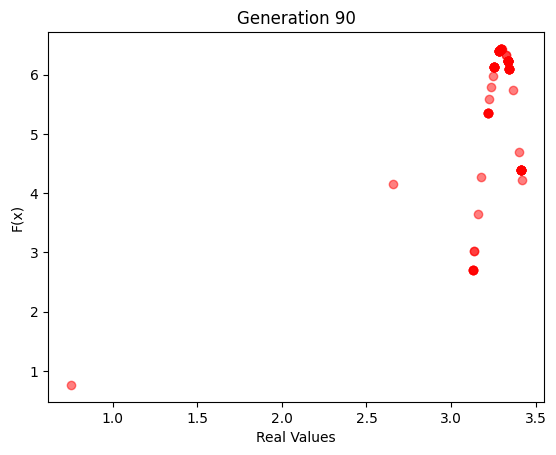

Generation: 91
Max F_values: 6.432903326858257
Time for Generation 91: 0.0043 seconds


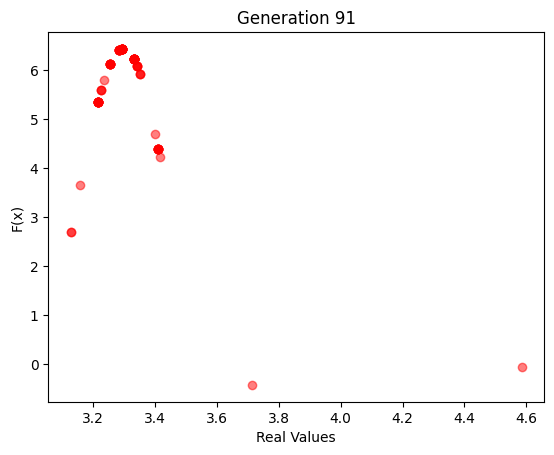

Generation: 92
Max F_values: 6.432903326858257
Time for Generation 92: 0.0053 seconds


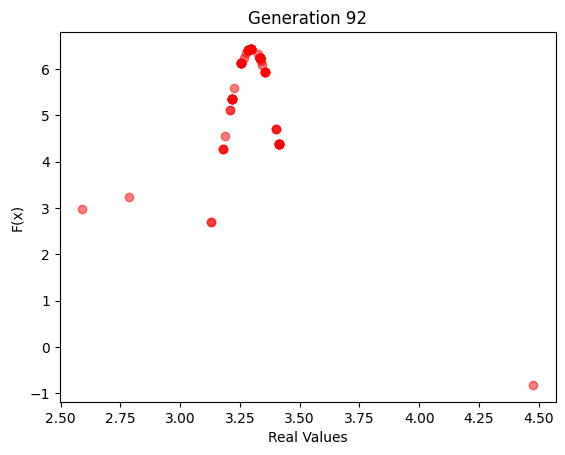

Generation: 93
Max F_values: 6.432903326858257
Time for Generation 93: 0.0038 seconds


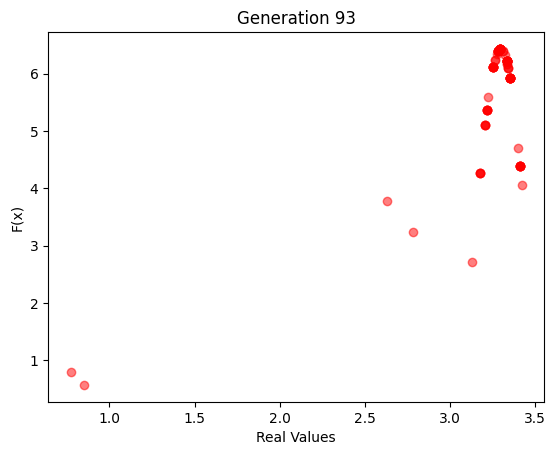

Generation: 94
Max F_values: 6.432903326858257
Time for Generation 94: 0.0036 seconds


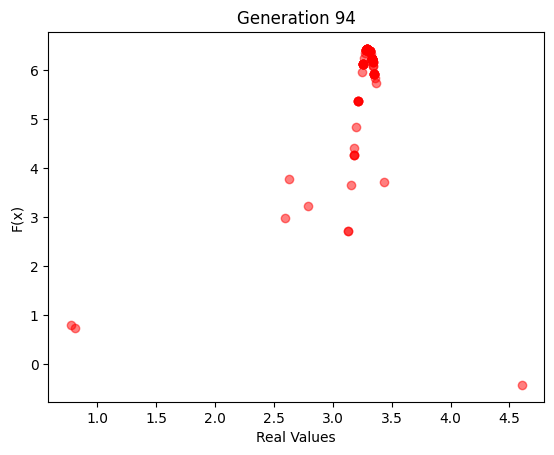

Generation: 95
Max F_values: 6.432903326858257
Time for Generation 95: 0.0037 seconds


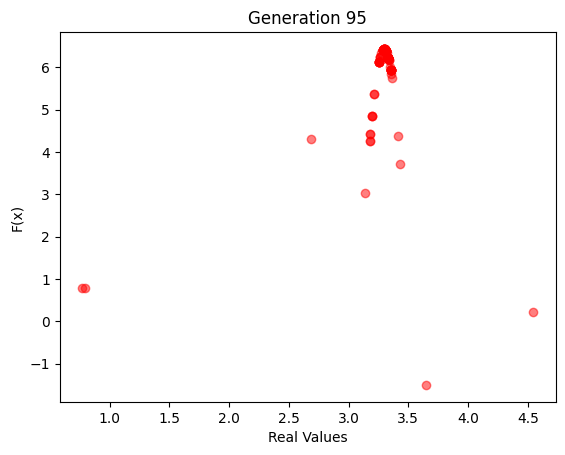

Generation: 96
Max F_values: 6.432903326858257
Time for Generation 96: 0.0111 seconds


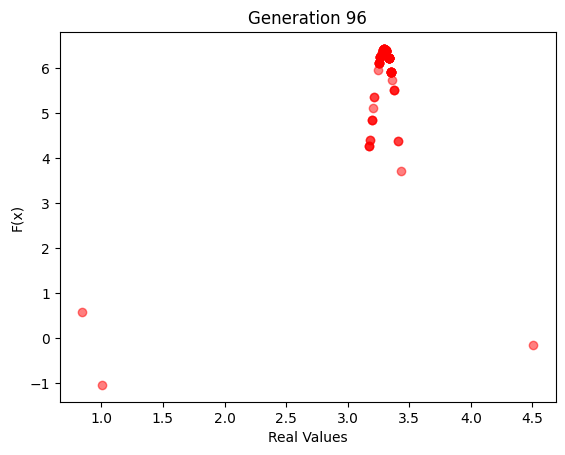

Generation: 97
Max F_values: 6.432903326858257
Time for Generation 97: 0.0035 seconds


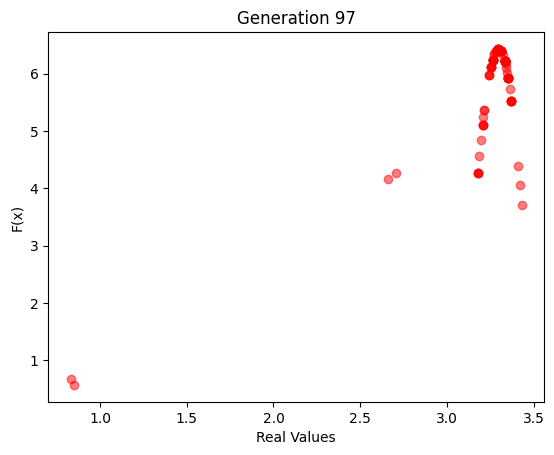

Generation: 98
Max F_values: 6.432903326858257
Time for Generation 98: 0.0036 seconds


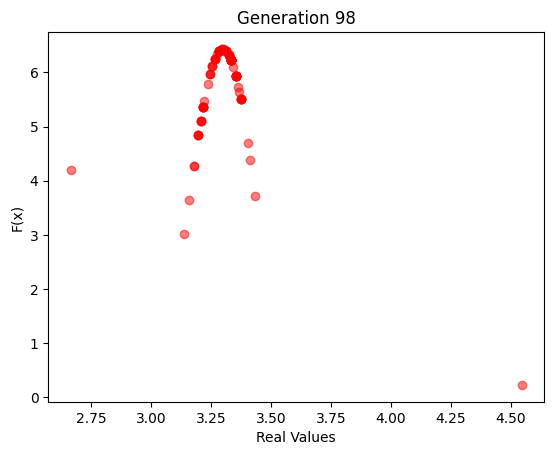

Generation: 99
Max F_values: 6.432903326858257
Time for Generation 99: 0.0036 seconds


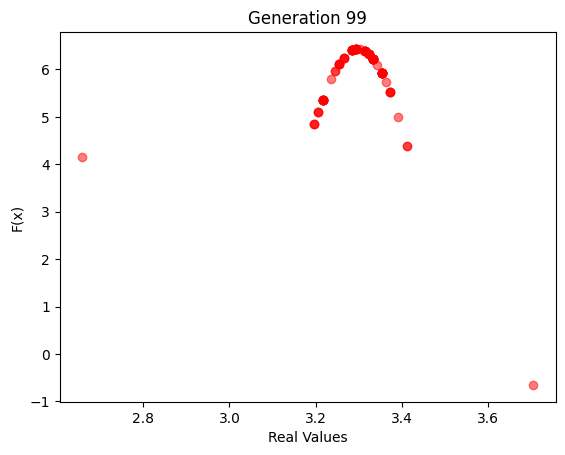

Generation: 100
Max F_values: 6.432903326858257
Time for Generation 100: 0.0039 seconds


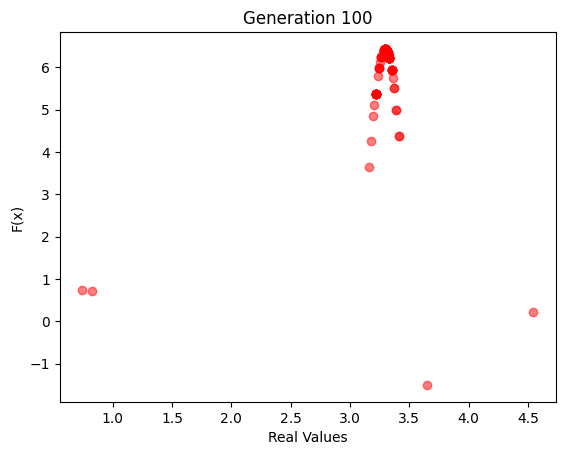

Generation: 101
Max F_values: 6.432903326858257
Time for Generation 101: 0.0041 seconds


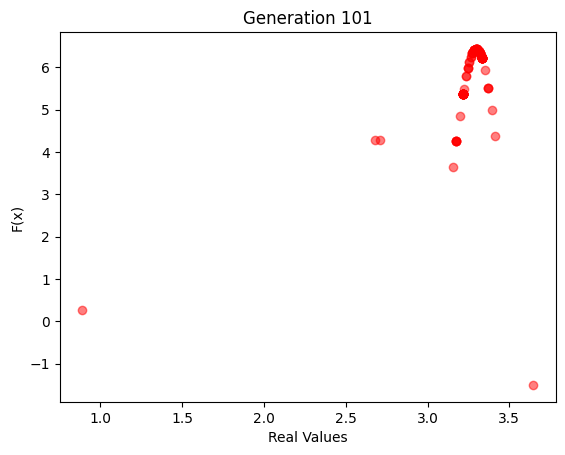

Generation: 102
Max F_values: 6.432903326858257
Time for Generation 102: 0.0050 seconds


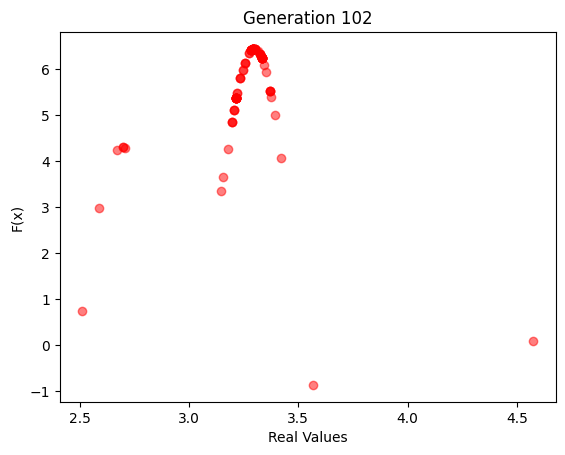

Generation: 103
Max F_values: 6.432903326858257
Time for Generation 103: 0.0059 seconds


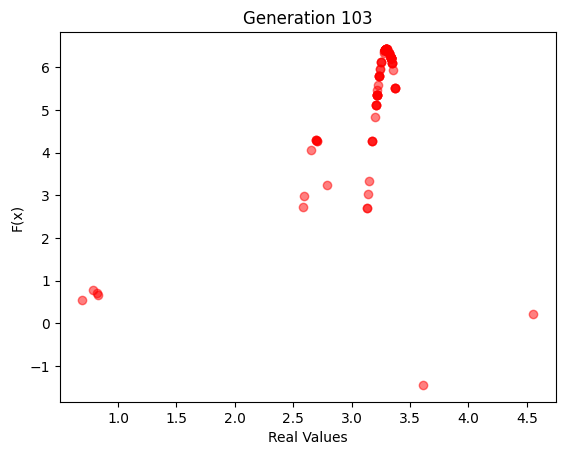

Generation: 104
Max F_values: 6.432903326858257
Time for Generation 104: 0.0040 seconds


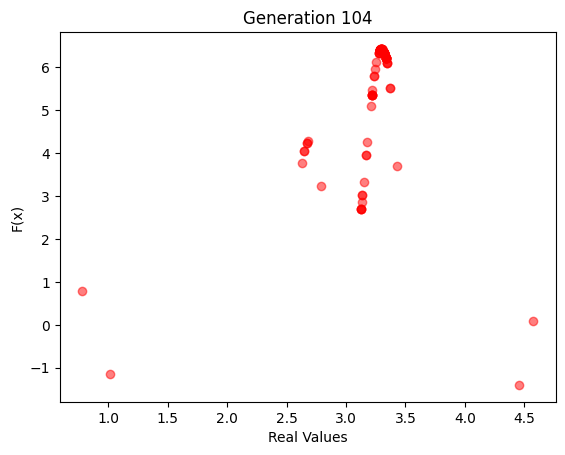

Generation: 105
Max F_values: 6.432903326858257
Time for Generation 105: 0.0058 seconds


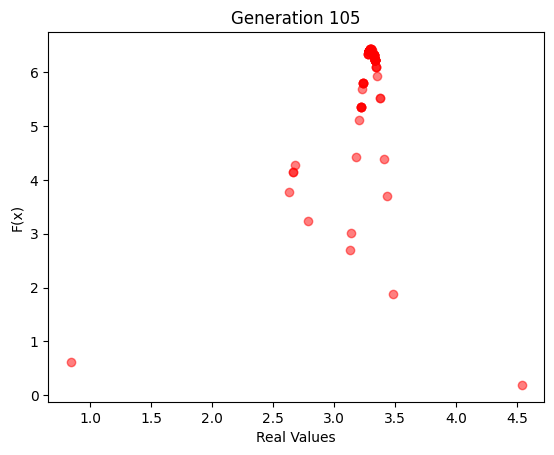

Generation: 106
Max F_values: 6.435822320543684
Time for Generation 106: 0.0044 seconds


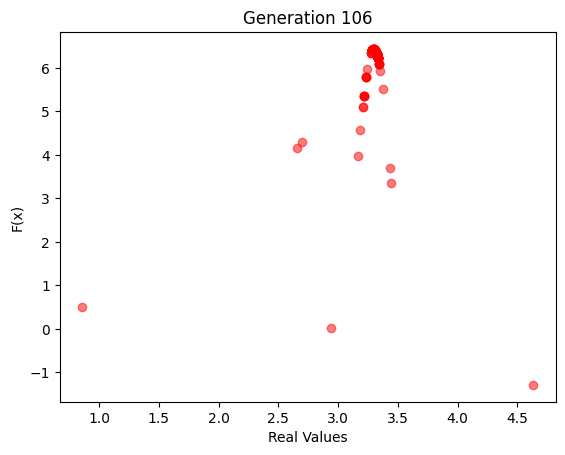

Generation: 107
Max F_values: 6.435822320543684
Time for Generation 107: 0.0049 seconds


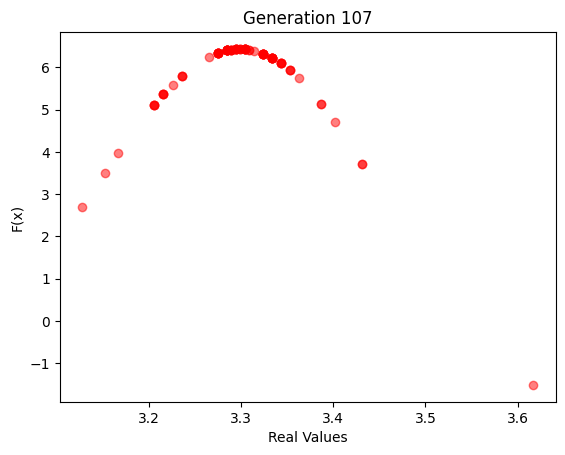

Generation: 108
Max F_values: 6.435822320543684
Time for Generation 108: 0.0041 seconds


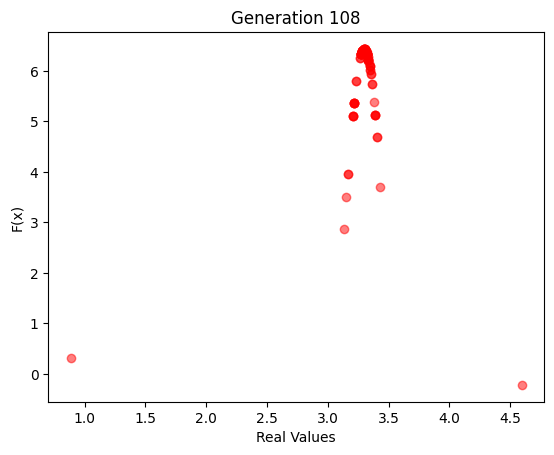

Generation: 109
Max F_values: 6.435822320543684
Time for Generation 109: 0.0042 seconds


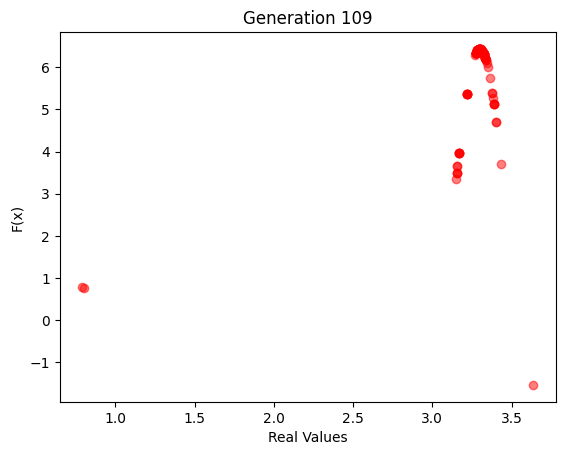

Generation: 110
Max F_values: 6.435822320543684
Time for Generation 110: 0.0052 seconds


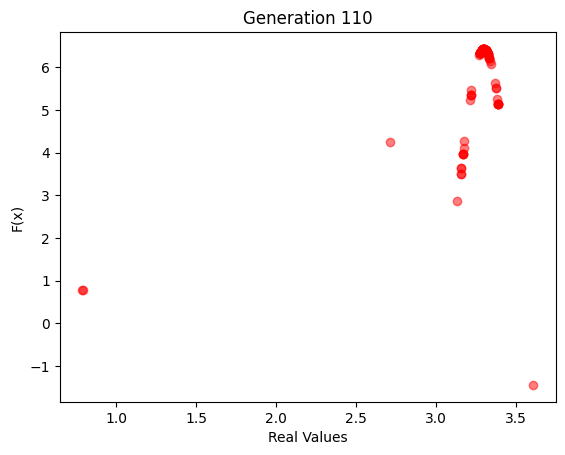

Generation: 111
Max F_values: 6.435822320543684
Time for Generation 111: 0.0037 seconds


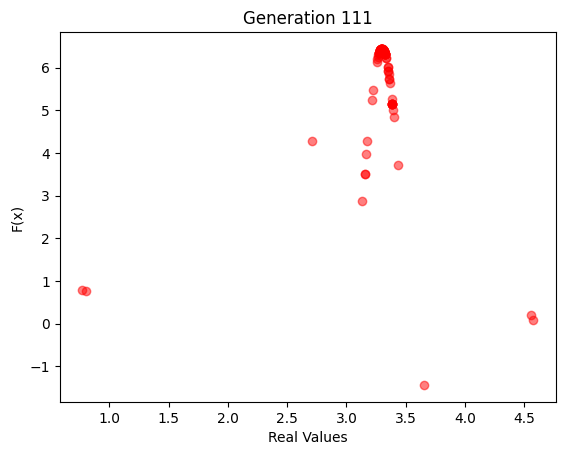

Generation: 112
Max F_values: 6.435822320543684
Time for Generation 112: 0.0061 seconds


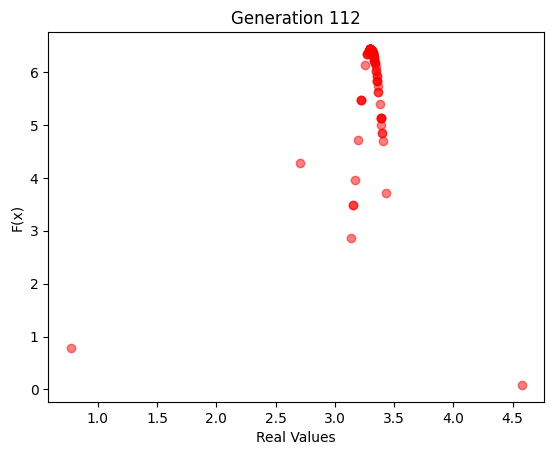

Generation: 113
Max F_values: 6.435822320543684
Time for Generation 113: 0.0064 seconds


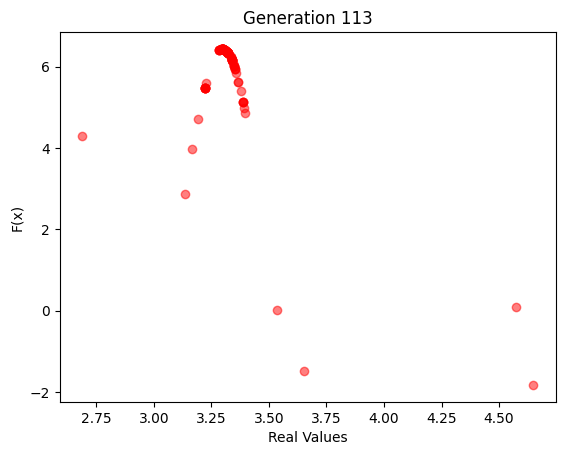

Generation: 114
Max F_values: 6.435822320543684
Time for Generation 114: 0.0049 seconds


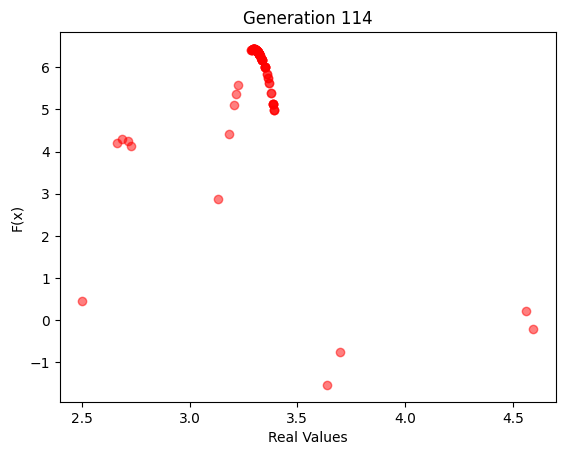

Generation: 115
Max F_values: 6.435822320543684
Time for Generation 115: 0.0059 seconds


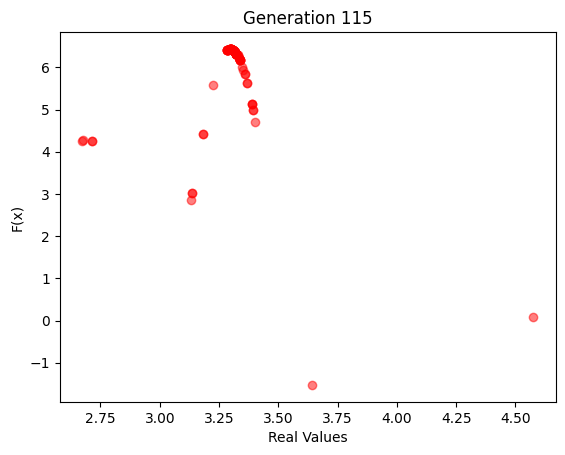

Generation: 116
Max F_values: 6.435822320543684
Time for Generation 116: 0.0049 seconds


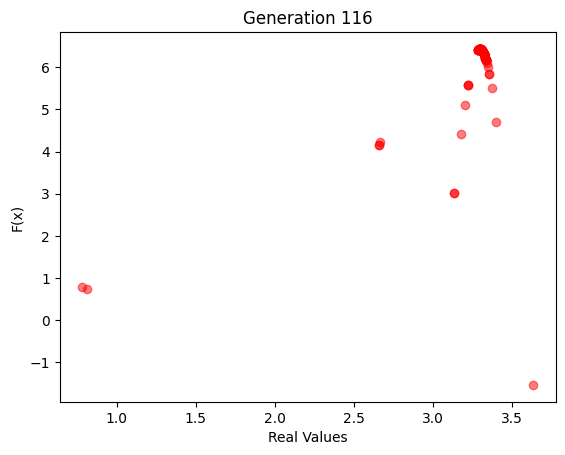

Generation: 117
Max F_values: 6.435822320543684
Time for Generation 117: 0.0045 seconds


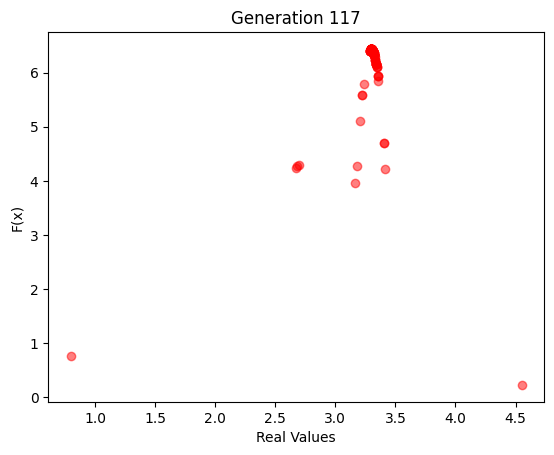

Generation: 118
Max F_values: 6.435822320543684
Time for Generation 118: 0.0057 seconds


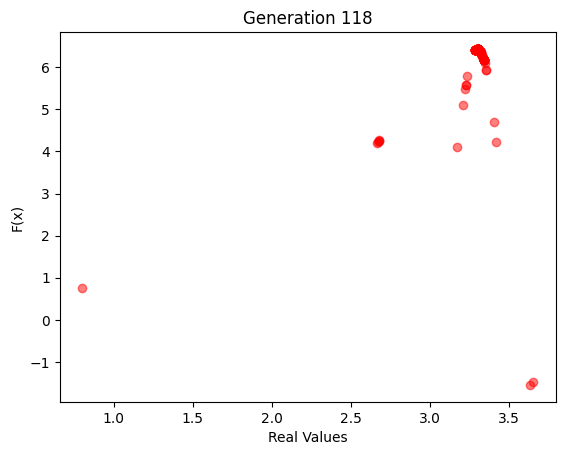

Generation: 119
Max F_values: 6.435822320543684
Time for Generation 119: 0.0042 seconds


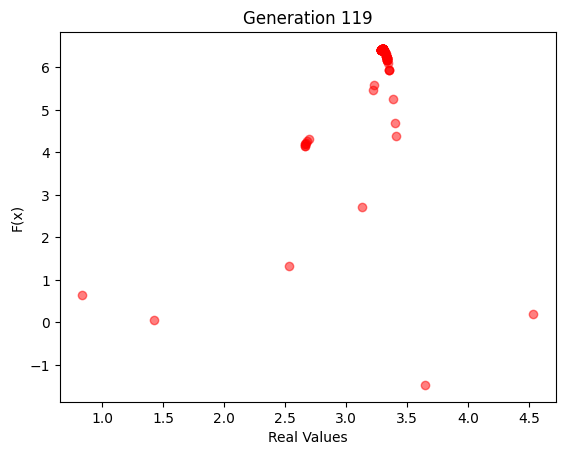

Generation: 120
Max F_values: 6.435822320543684
Time for Generation 120: 0.0045 seconds


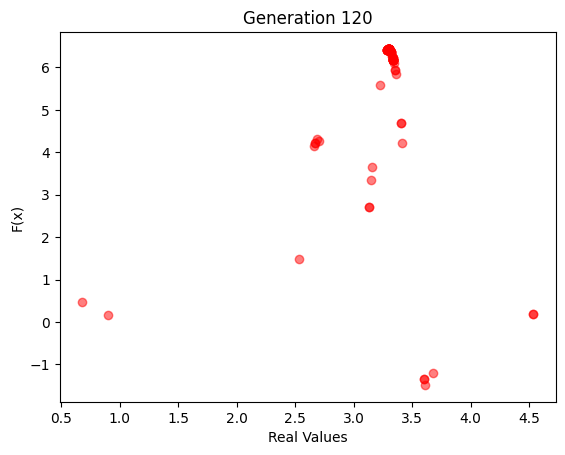

Generation: 121
Max F_values: 6.435822320543684
Time for Generation 121: 0.0051 seconds


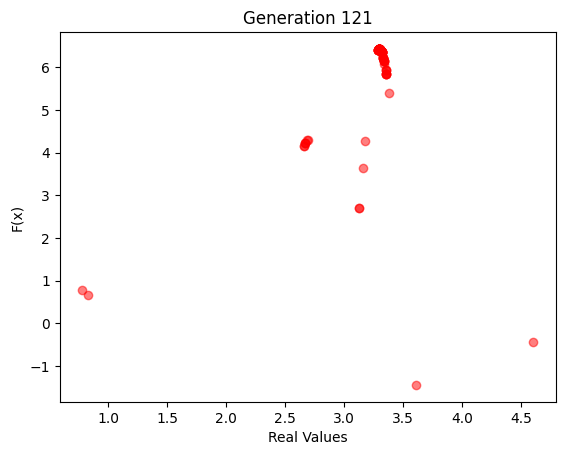

Generation: 122
Max F_values: 6.435822320543684
Time for Generation 122: 0.0059 seconds


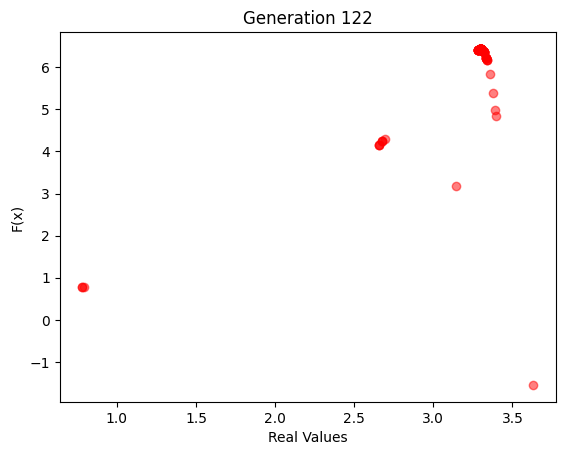

Generation: 123
Max F_values: 6.435822320543684
Time for Generation 123: 0.0047 seconds


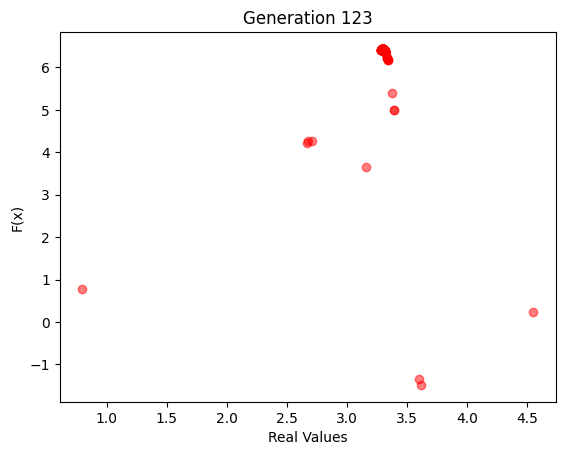

Generation: 124
Max F_values: 6.435822320543684
Time for Generation 124: 0.0047 seconds


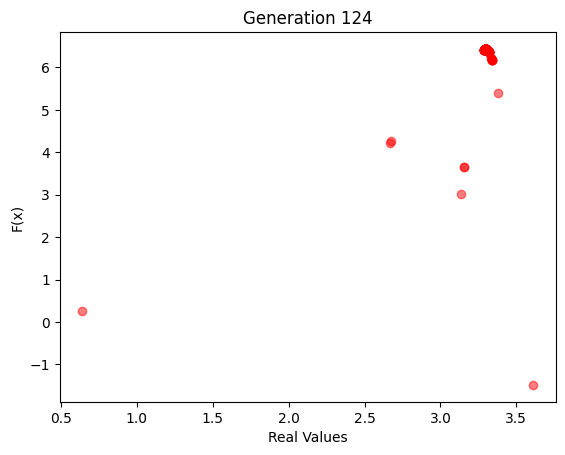

Generation: 125
Max F_values: 6.435822320543684
Time for Generation 125: 0.0059 seconds


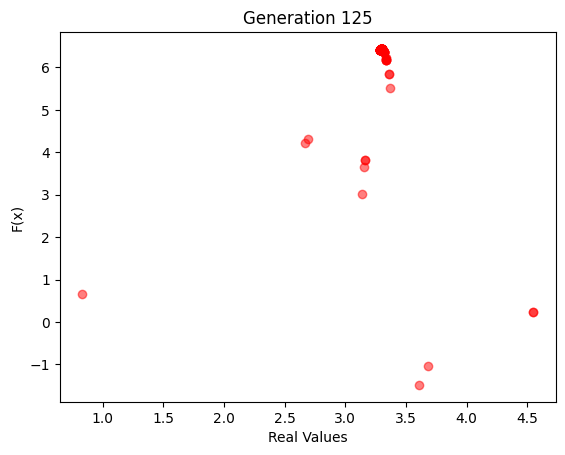

Generation: 126
Max F_values: 6.435822320543684
Time for Generation 126: 0.0048 seconds


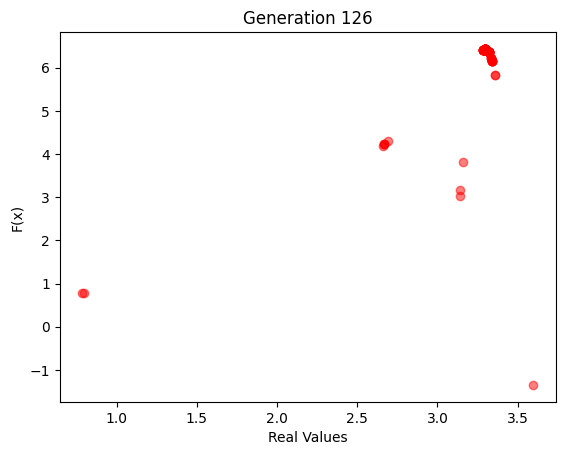

Generation: 127
Max F_values: 6.435822320543684
Time for Generation 127: 0.0052 seconds


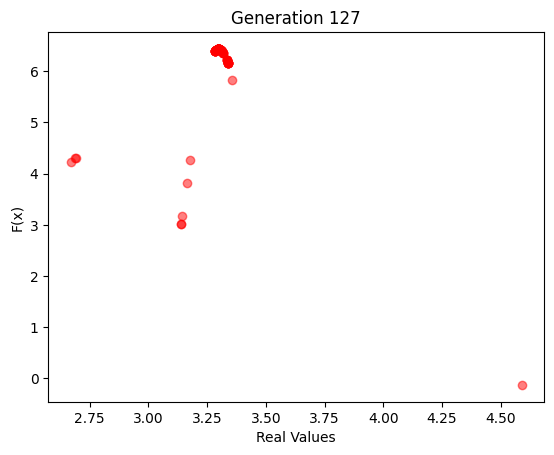

Generation: 128
Max F_values: 6.435822320543684
Time for Generation 128: 0.0061 seconds


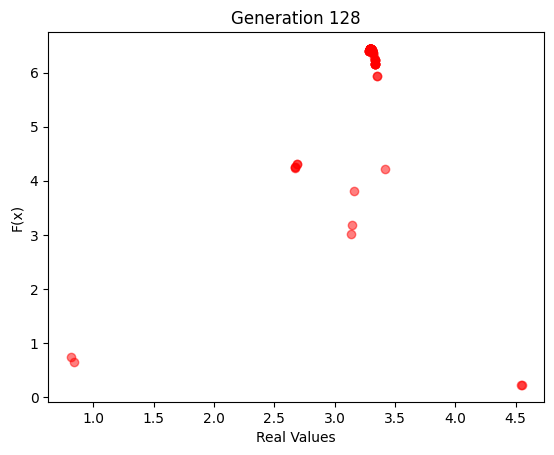

Generation: 129
Max F_values: 6.435822320543684
Time for Generation 129: 0.0044 seconds


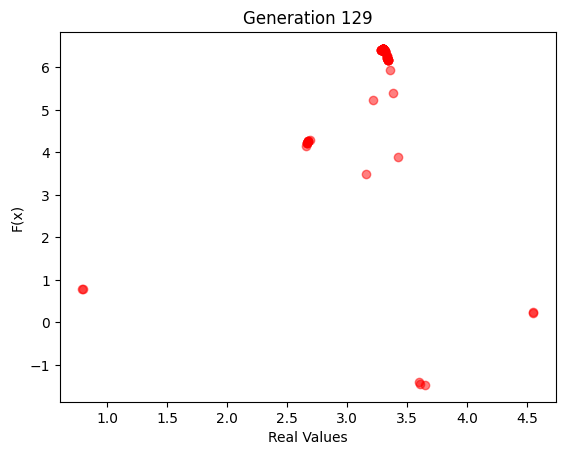

Generation: 130
Max F_values: 6.435822320543684
Time for Generation 130: 0.0053 seconds


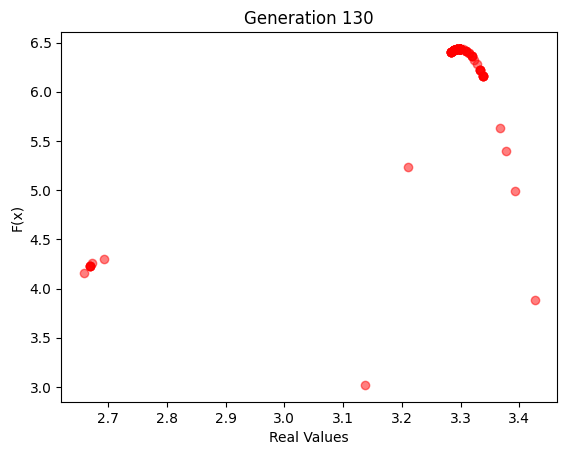

Generation: 131
Max F_values: 6.435822320543684
Time for Generation 131: 0.0057 seconds


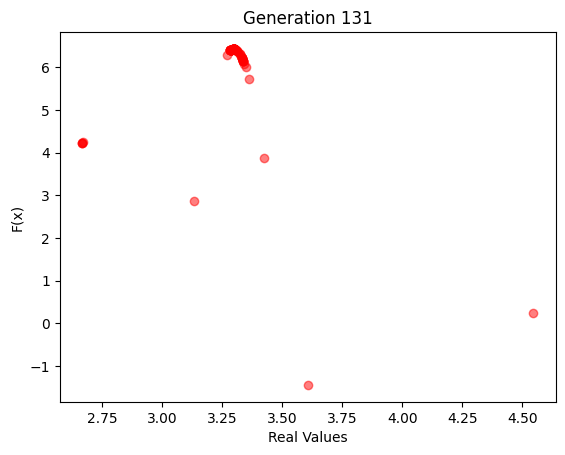

Generation: 132
Max F_values: 6.435822320543684
Time for Generation 132: 0.0053 seconds


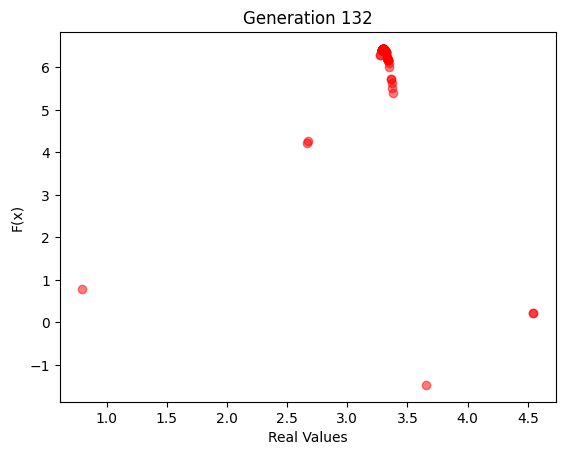

Generation: 133
Max F_values: 6.435822320543684
Time for Generation 133: 0.0043 seconds


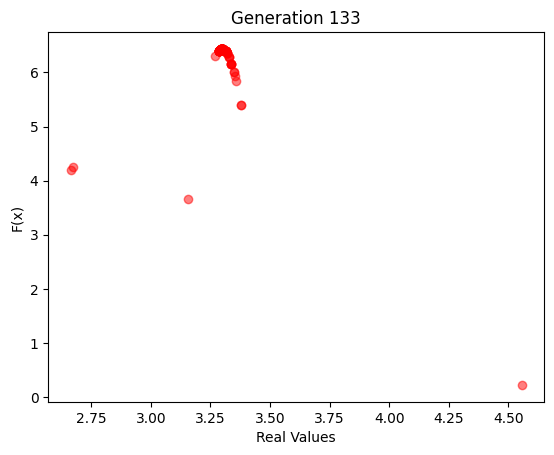

Generation: 134
Max F_values: 6.435822320543684
Time for Generation 134: 0.0046 seconds


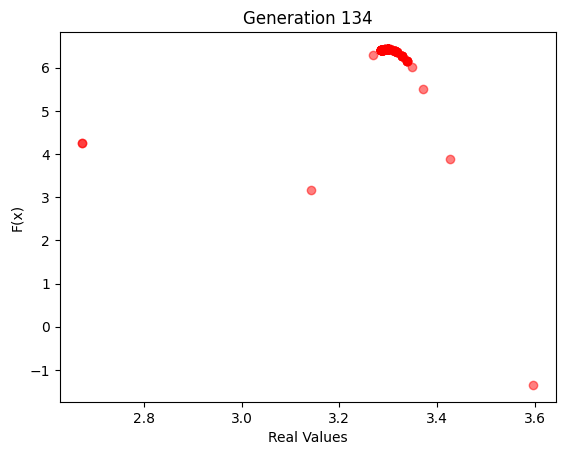

Generation: 135
Max F_values: 6.435822320543684
Time for Generation 135: 0.0048 seconds


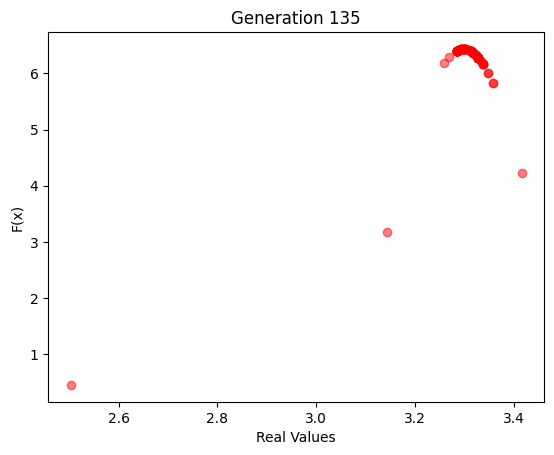

Generation: 136
Max F_values: 6.435822320543684
Time for Generation 136: 0.0074 seconds


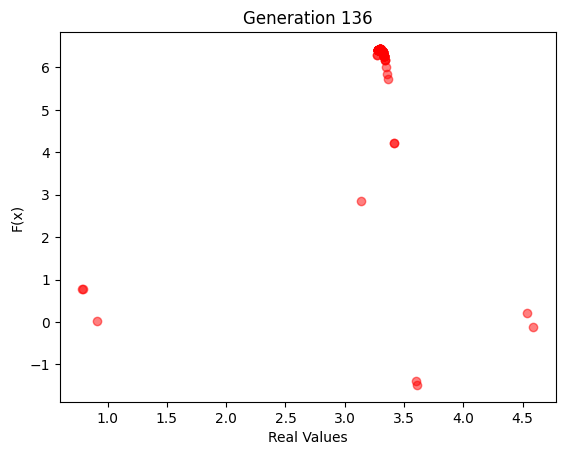

Generation: 137
Max F_values: 6.435822320543684
Time for Generation 137: 0.0036 seconds


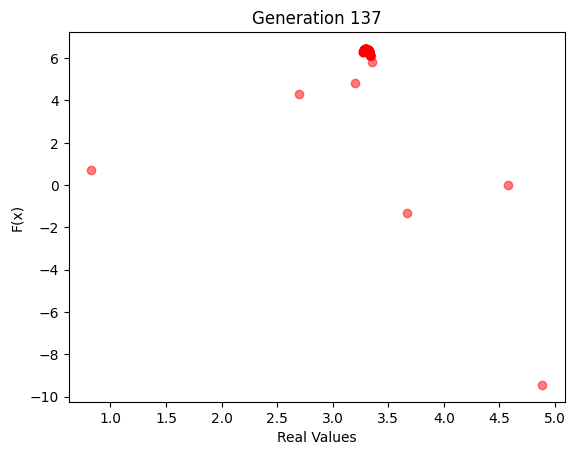

Generation: 138
Max F_values: 6.435822320543684
Time for Generation 138: 0.0038 seconds


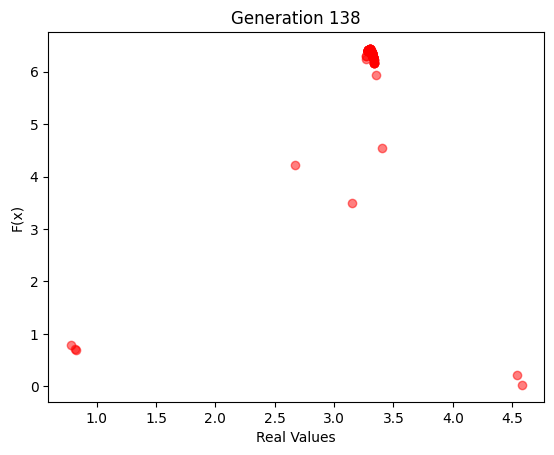

Generation: 139
Max F_values: 6.435822320543684
Time for Generation 139: 0.0038 seconds


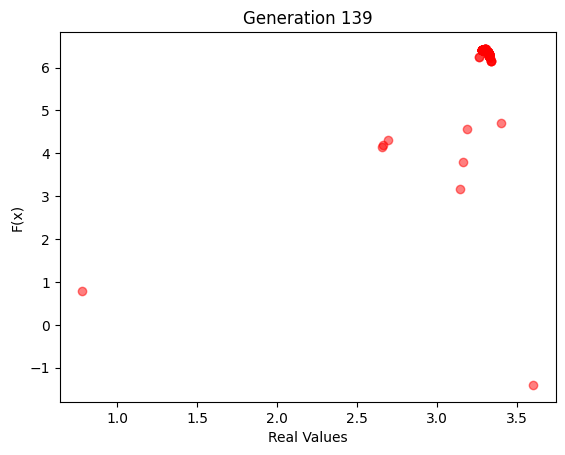

Generation: 140
Max F_values: 6.435822320543684
Time for Generation 140: 0.0038 seconds


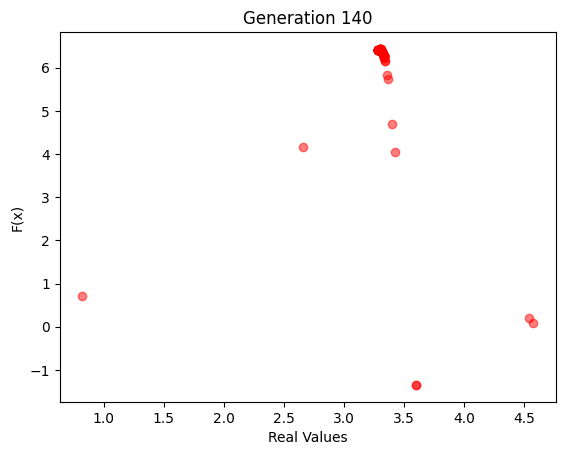

Generation: 141
Max F_values: 6.435822320543684
Time for Generation 141: 0.0036 seconds


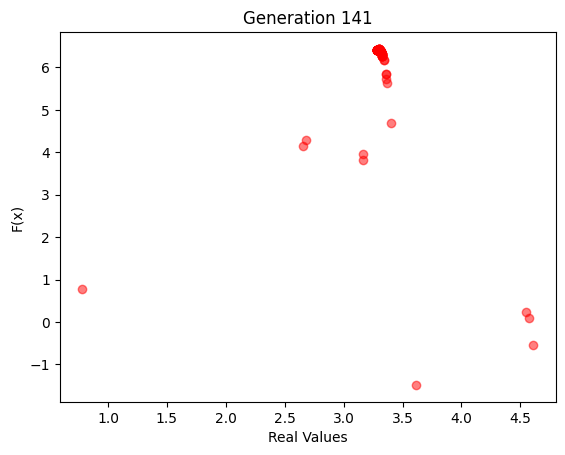

Generation: 142
Max F_values: 6.435822320543684
Time for Generation 142: 0.0050 seconds


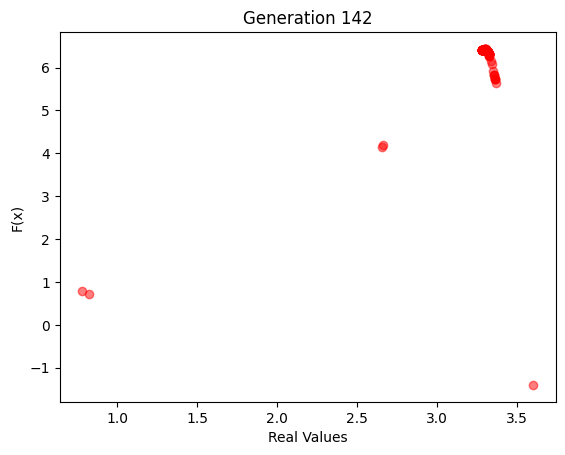

Generation: 143
Max F_values: 6.435822320543684
Time for Generation 143: 0.0074 seconds


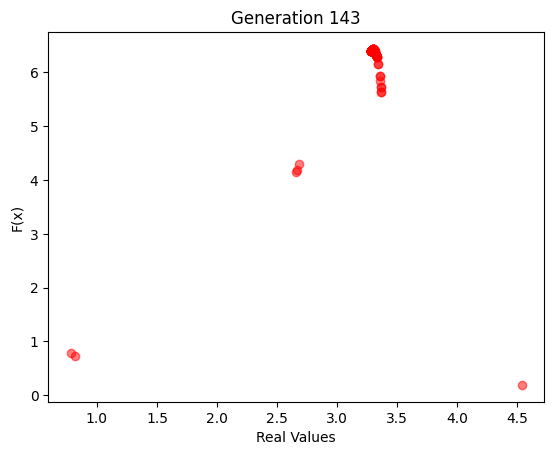

Generation: 144
Max F_values: 6.435822320543684
Time for Generation 144: 0.0040 seconds


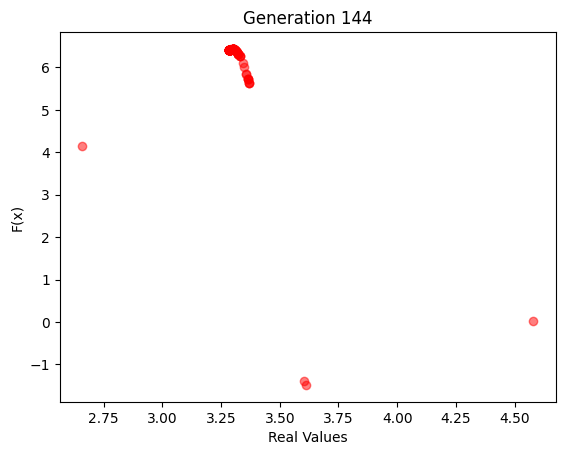

Generation: 145
Max F_values: 6.435822320543684
Time for Generation 145: 0.0038 seconds


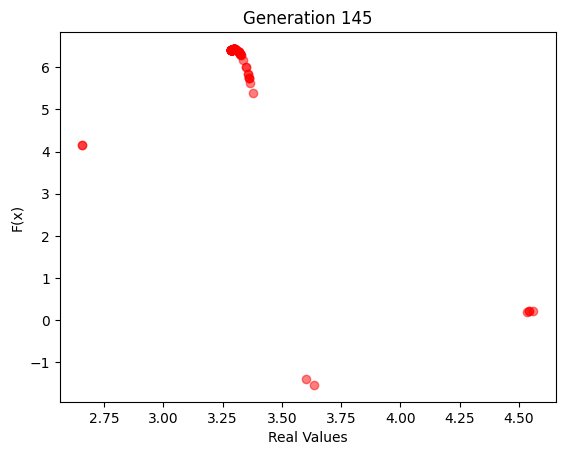

Generation: 146
Max F_values: 6.435822320543684
Time for Generation 146: 0.0045 seconds


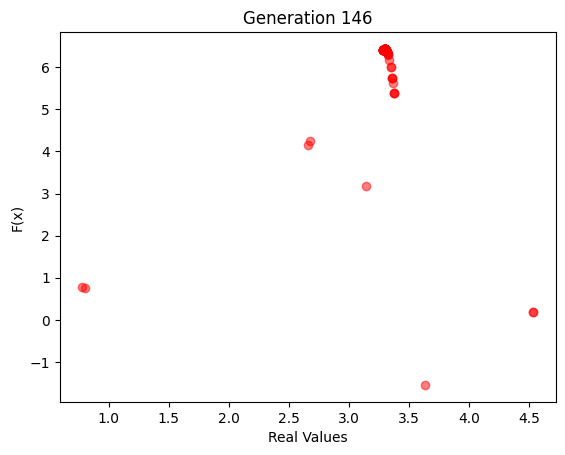

Generation: 147
Max F_values: 6.435822320543684
Time for Generation 147: 0.0045 seconds


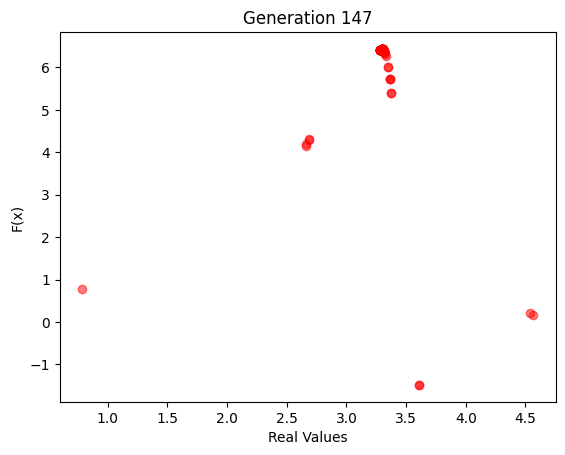

Generation: 148
Max F_values: 6.435822320543684
Time for Generation 148: 0.0057 seconds


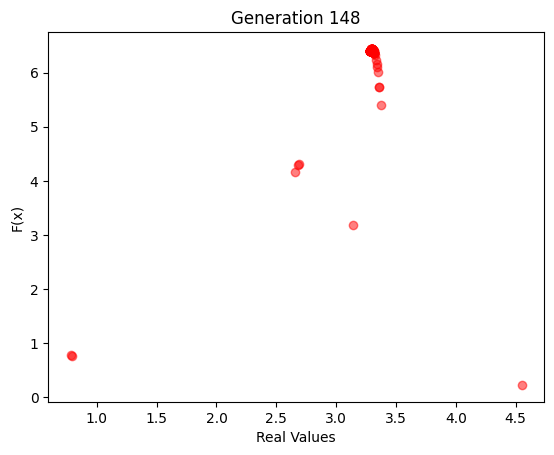

Generation: 149
Max F_values: 6.435822320543684
Time for Generation 149: 0.0037 seconds


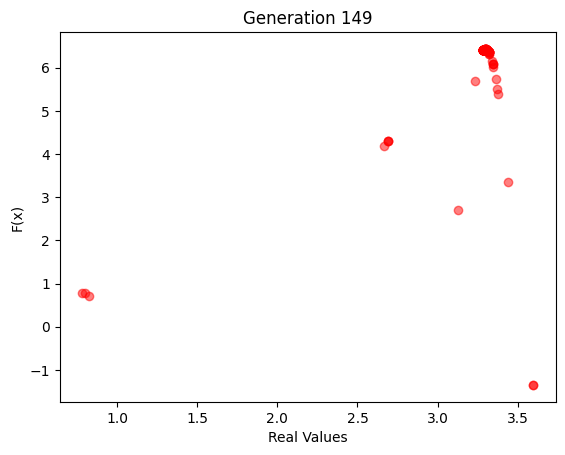

Generation: 150
Max F_values: 6.435822320543684
Time for Generation 150: 0.0042 seconds


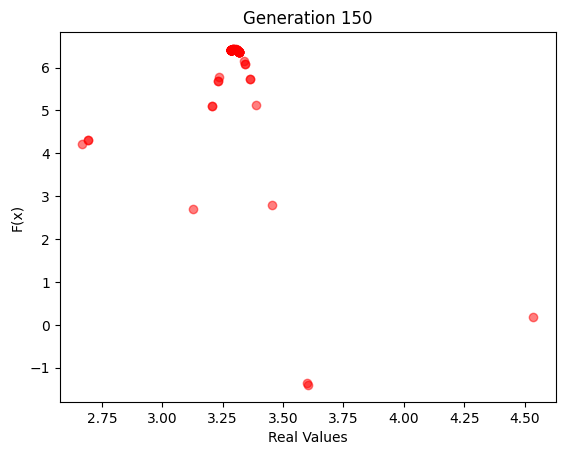

Generation: 151
Max F_values: 6.435822320543684
Time for Generation 151: 0.0046 seconds


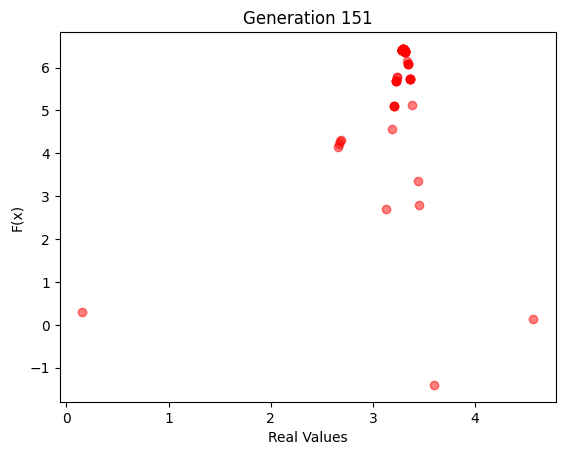

Generation: 152
Max F_values: 6.435822320543684
Time for Generation 152: 0.0042 seconds


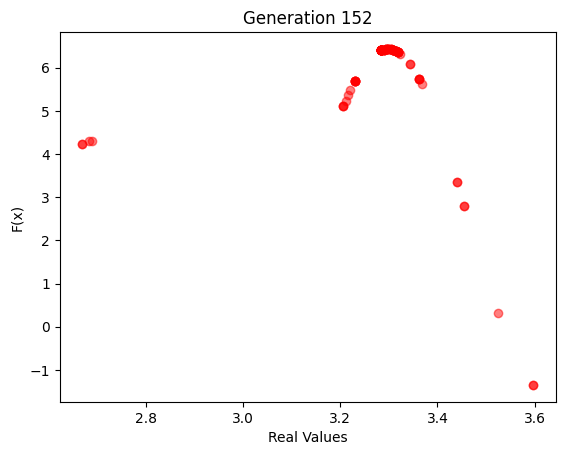

Generation: 153
Max F_values: 6.435822320543684
Time for Generation 153: 0.0044 seconds


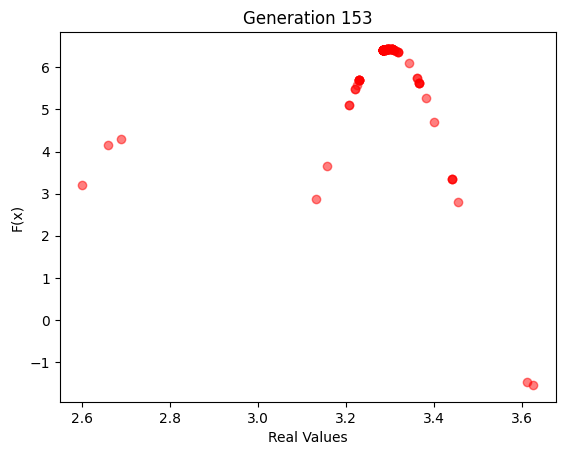

Generation: 154
Max F_values: 6.435822320543684
Time for Generation 154: 0.0047 seconds


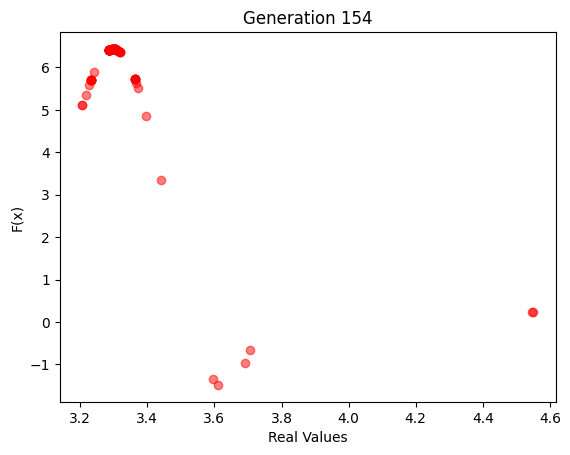

Generation: 155
Max F_values: 6.435822320543684
Time for Generation 155: 0.0042 seconds


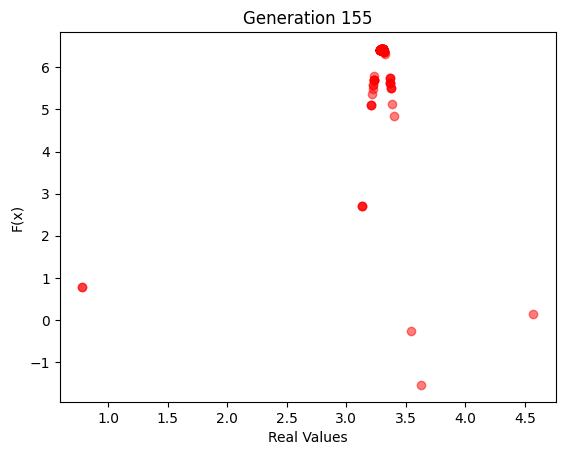

Generation: 156
Max F_values: 6.435822320543684
Time for Generation 156: 0.0059 seconds


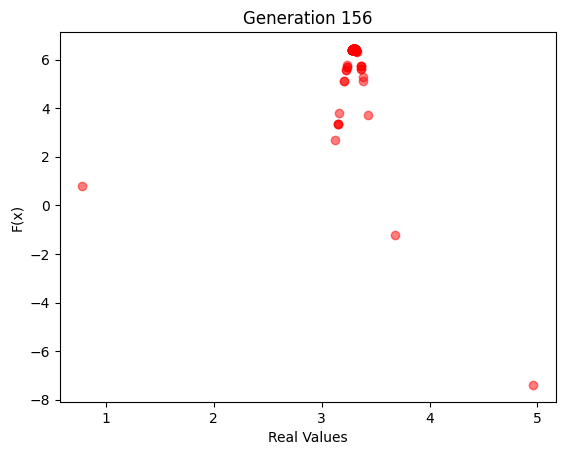

Generation: 157
Max F_values: 6.435822320543684
Time for Generation 157: 0.0036 seconds


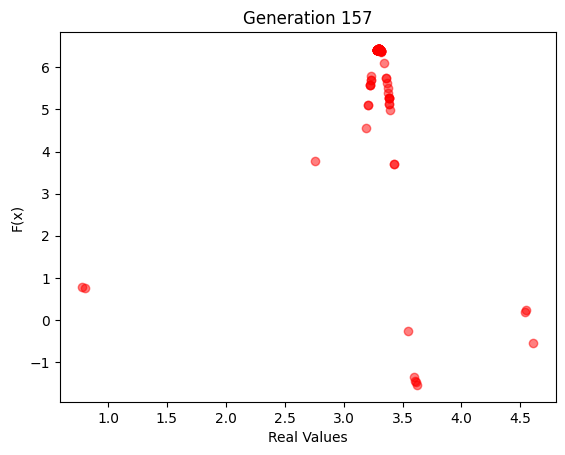

Generation: 158
Max F_values: 6.435822320543684
Time for Generation 158: 0.0062 seconds


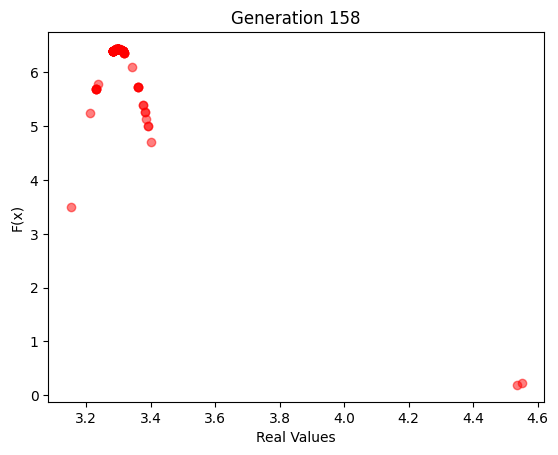

Generation: 159
Max F_values: 6.435822320543684
Time for Generation 159: 0.0052 seconds


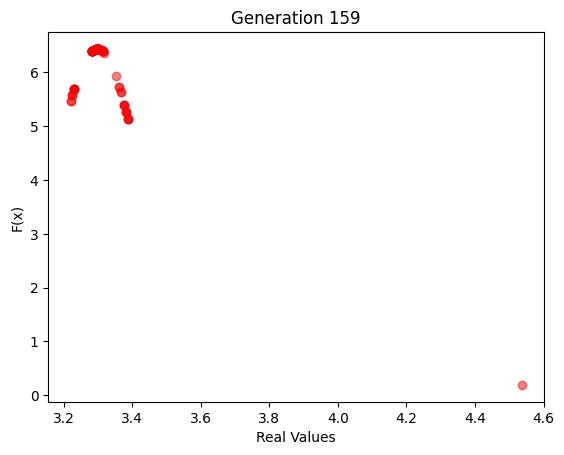

Generation: 160
Max F_values: 6.435822320543684
Time for Generation 160: 0.0040 seconds


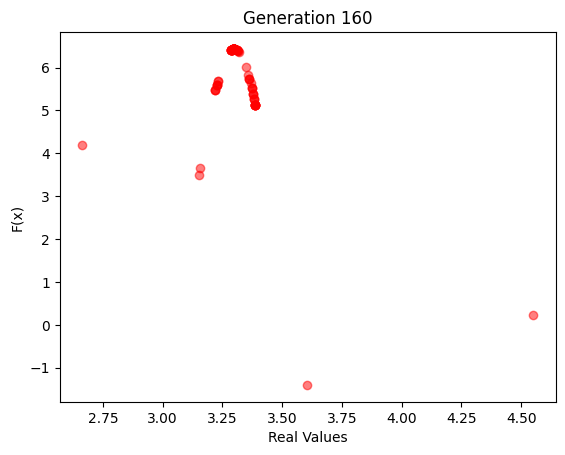

Generation: 161
Max F_values: 6.435822320543684
Time for Generation 161: 0.0055 seconds


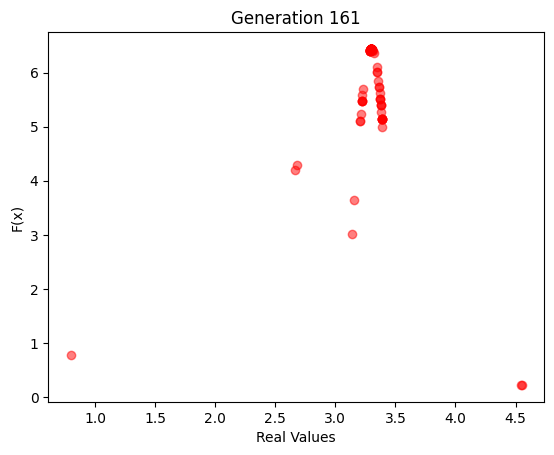

Generation: 162
Max F_values: 6.435822320543684
Time for Generation 162: 0.0052 seconds


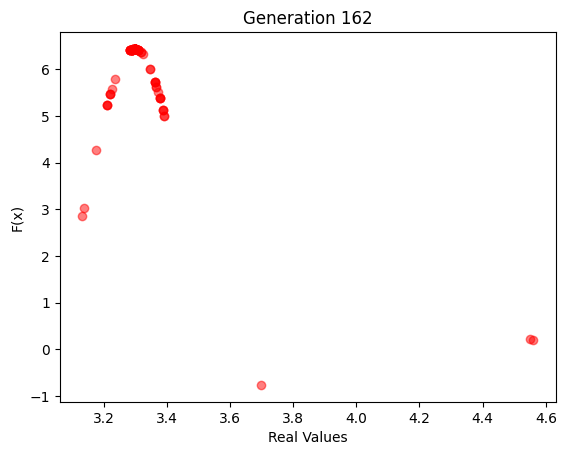

Generation: 163
Max F_values: 6.435822320543684
Time for Generation 163: 0.0054 seconds


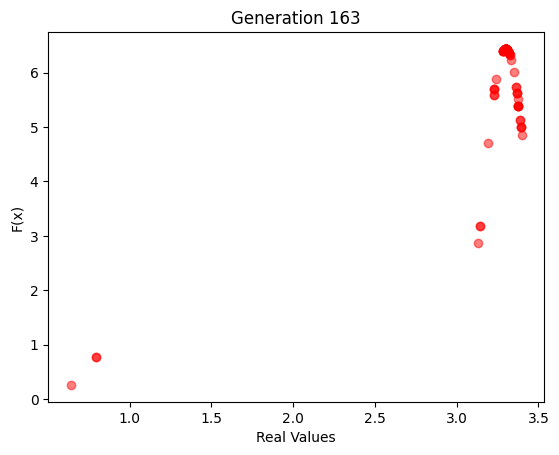

Generation: 164
Max F_values: 6.435822320543684
Time for Generation 164: 0.0044 seconds


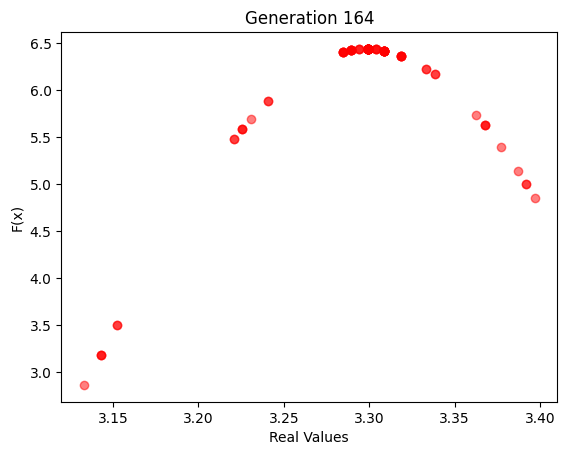

Generation: 165
Max F_values: 6.435822320543684
Time for Generation 165: 0.0051 seconds


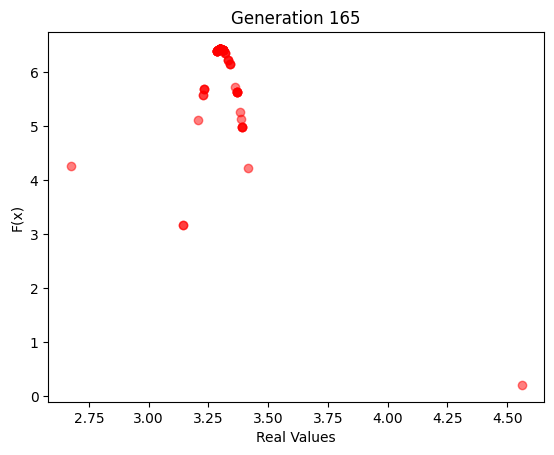

Generation: 166
Max F_values: 6.435822320543684
Time for Generation 166: 0.0066 seconds


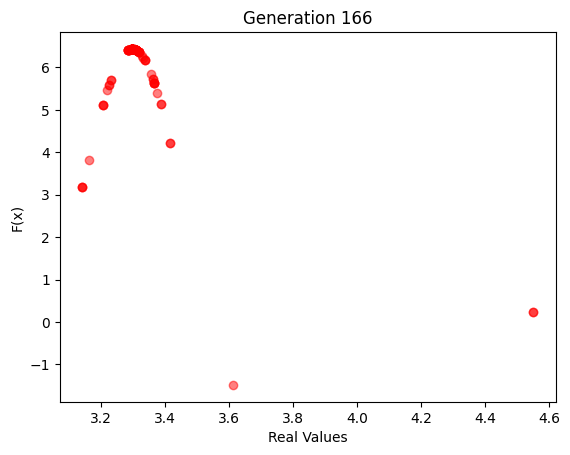

Generation: 167
Max F_values: 6.435822320543684
Time for Generation 167: 0.0041 seconds


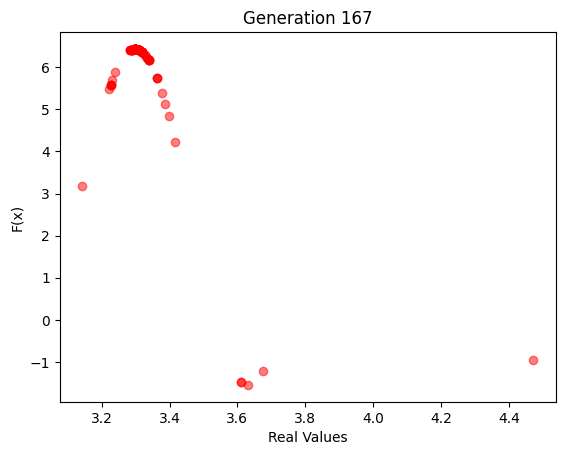

Generation: 168
Max F_values: 6.435822320543684
Time for Generation 168: 0.0041 seconds


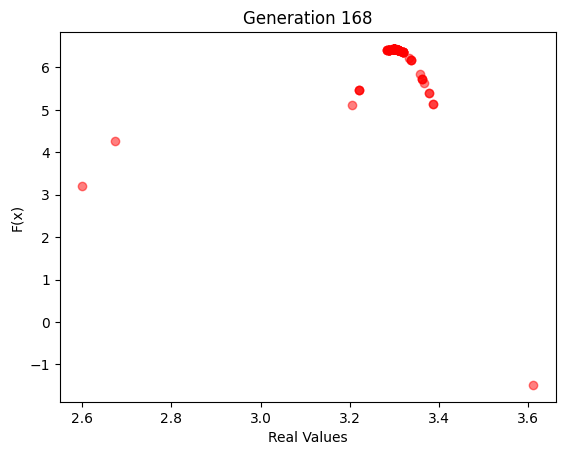

Generation: 169
Max F_values: 6.435822320543684
Time for Generation 169: 0.0043 seconds


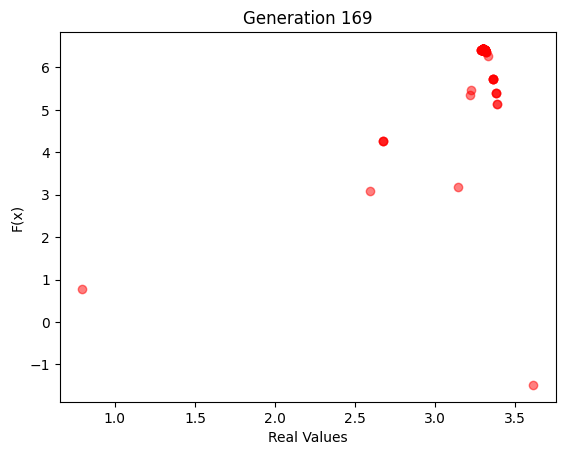

Generation: 170
Max F_values: 6.435822320543684
Time for Generation 170: 0.0055 seconds


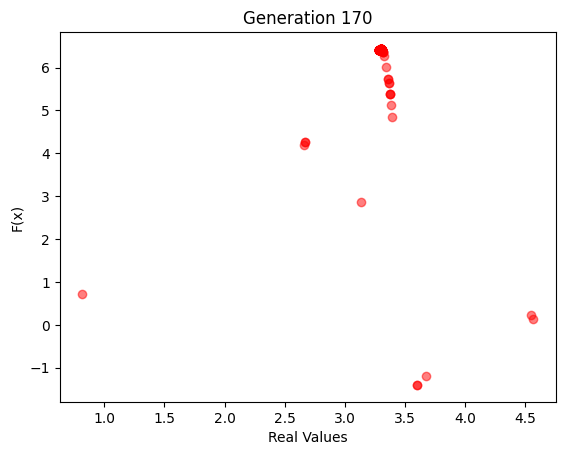

Generation: 171
Max F_values: 6.435822320543684
Time for Generation 171: 0.0052 seconds


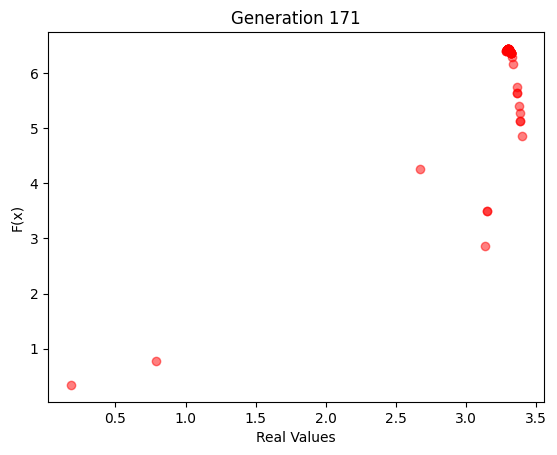

Generation: 172
Max F_values: 6.435822320543684
Time for Generation 172: 0.0056 seconds


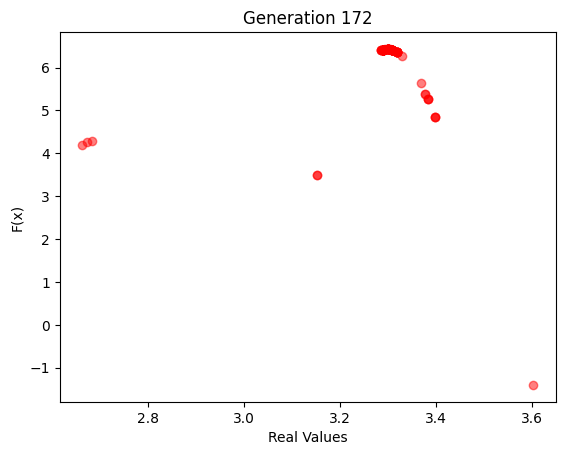

Generation: 173
Max F_values: 6.435822320543684
Time for Generation 173: 0.0042 seconds


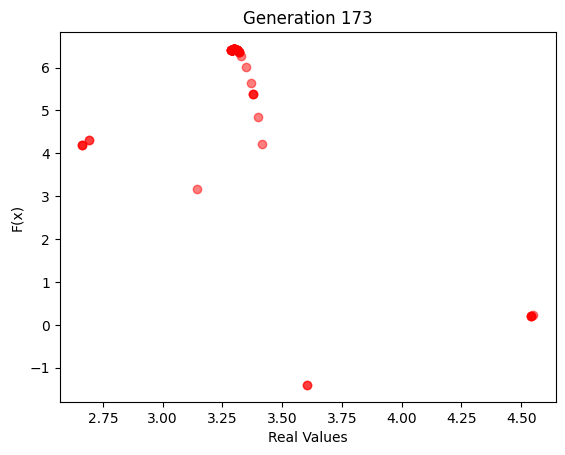

Generation: 174
Max F_values: 6.435822320543684
Time for Generation 174: 0.0042 seconds


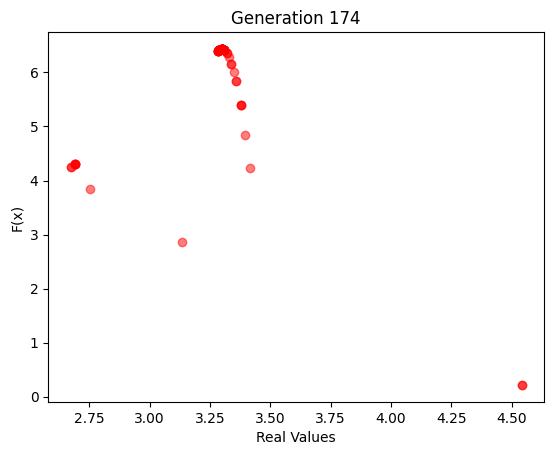

Generation: 175
Max F_values: 6.435822320543684
Time for Generation 175: 0.0044 seconds


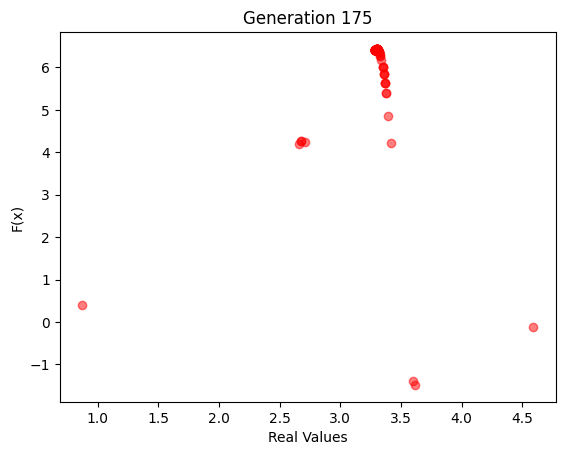

Generation: 176
Max F_values: 6.435822320543684
Time for Generation 176: 0.0047 seconds


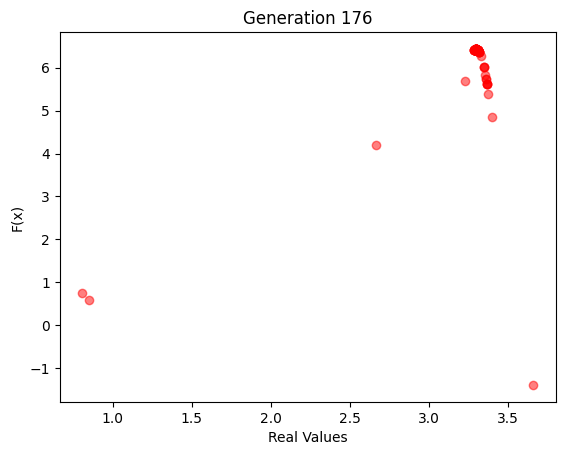

Generation: 177
Max F_values: 6.435822320543684
Time for Generation 177: 0.0039 seconds


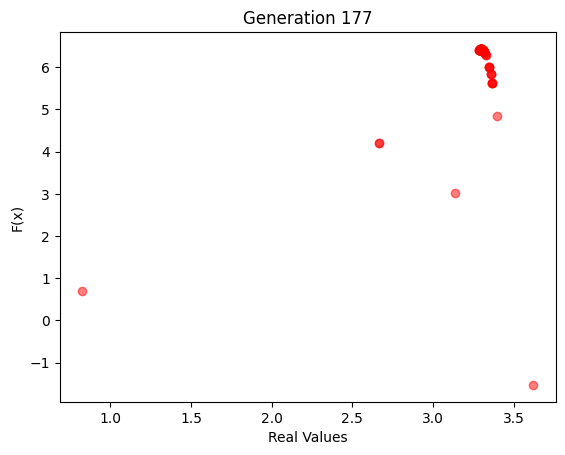

Generation: 178
Max F_values: 6.435822320543684
Time for Generation 178: 0.0061 seconds


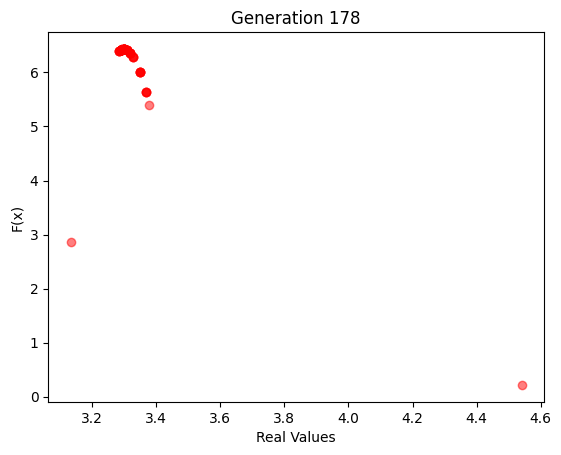

Generation: 179
Max F_values: 6.435822320543684
Time for Generation 179: 0.0036 seconds


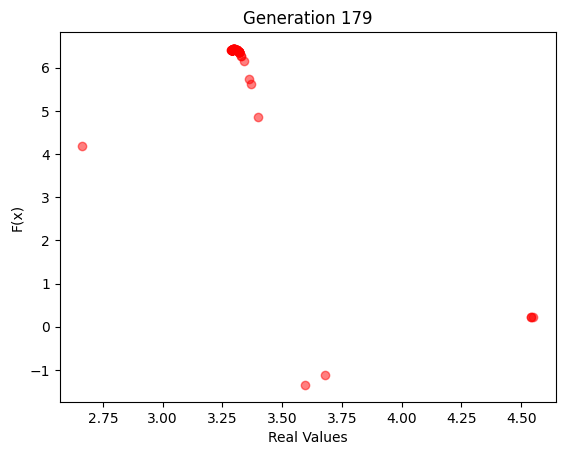

Generation: 180
Max F_values: 6.435822320543684
Time for Generation 180: 0.0059 seconds


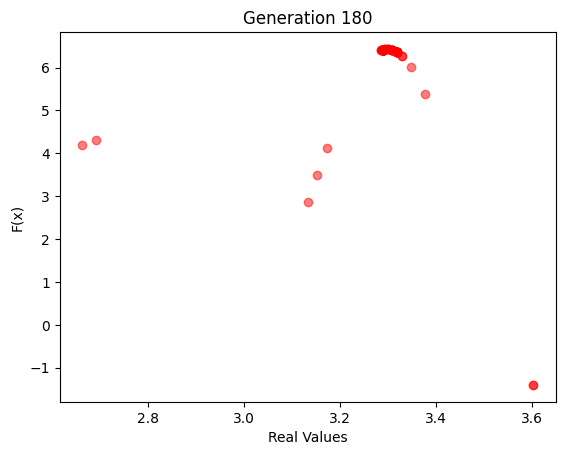

Generation: 181
Max F_values: 6.435822320543684
Time for Generation 181: 0.0049 seconds


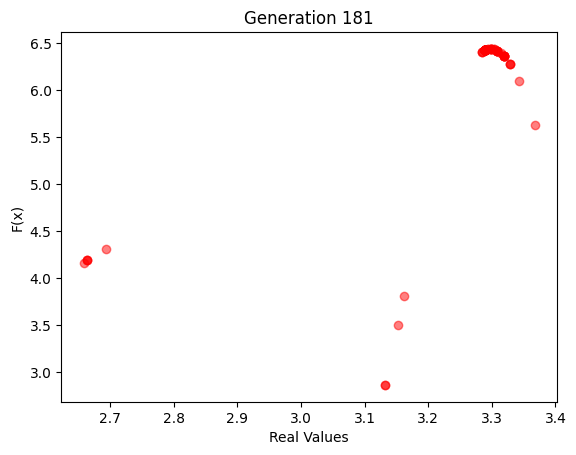

Generation: 182
Max F_values: 6.435822320543684
Time for Generation 182: 0.0038 seconds


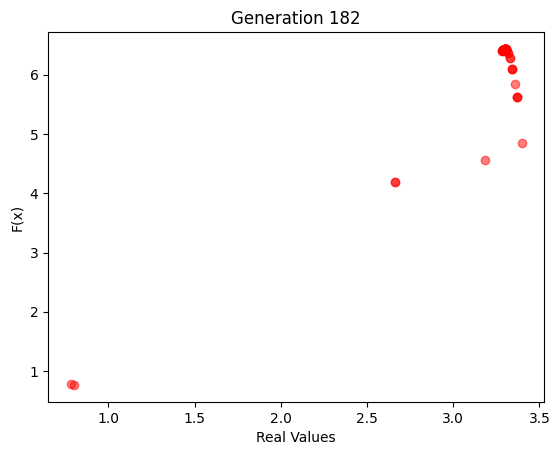

Generation: 183
Max F_values: 6.435822320543684
Time for Generation 183: 0.0037 seconds


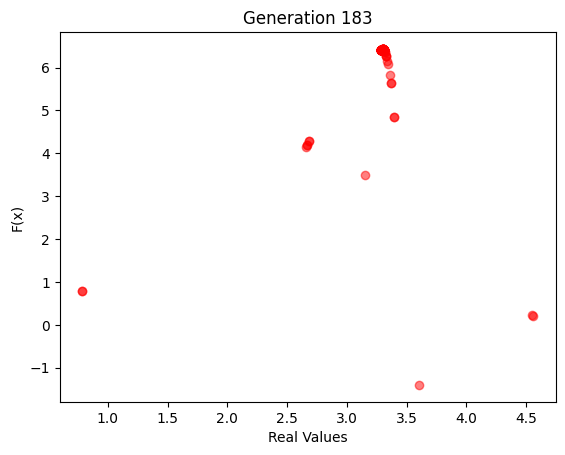

Generation: 184
Max F_values: 6.435822320543684
Time for Generation 184: 0.0036 seconds


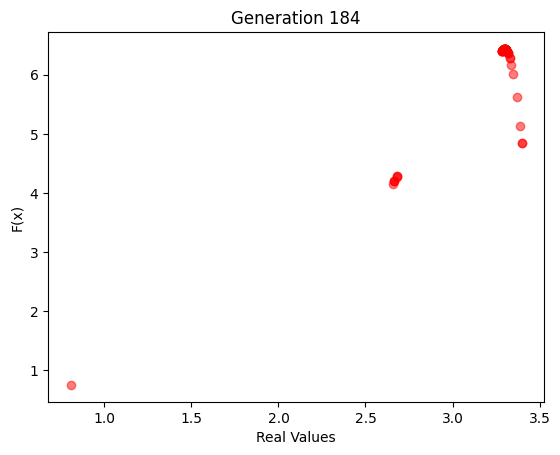

Generation: 185
Max F_values: 6.435822320543684
Time for Generation 185: 0.0038 seconds


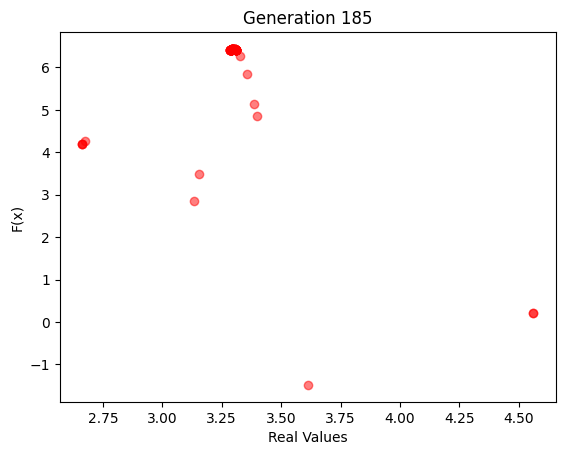

Generation: 186
Max F_values: 6.432903326858257
Time for Generation 186: 0.0057 seconds


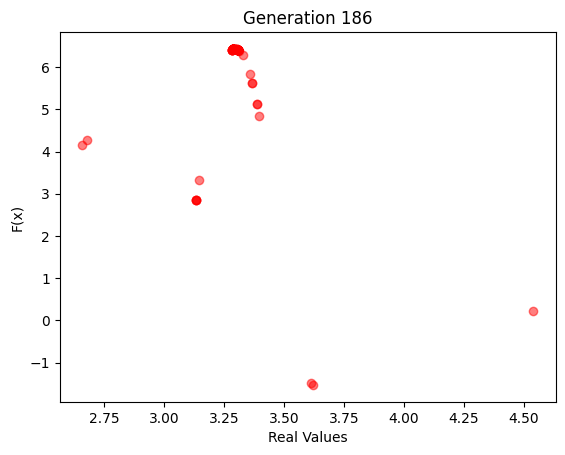

Generation: 187
Max F_values: 6.432903326858257
Time for Generation 187: 0.0061 seconds


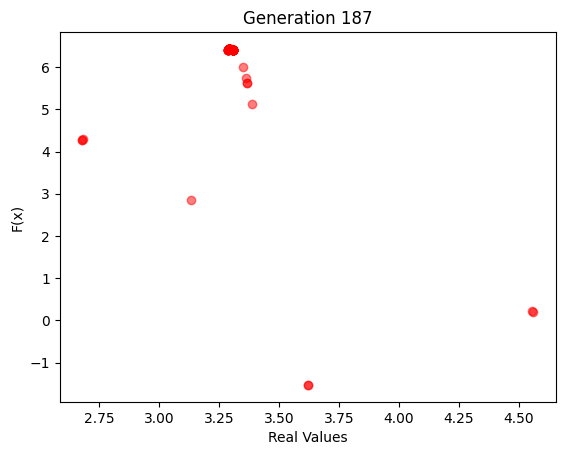

Generation: 188
Max F_values: 6.432903326858257
Time for Generation 188: 0.0044 seconds


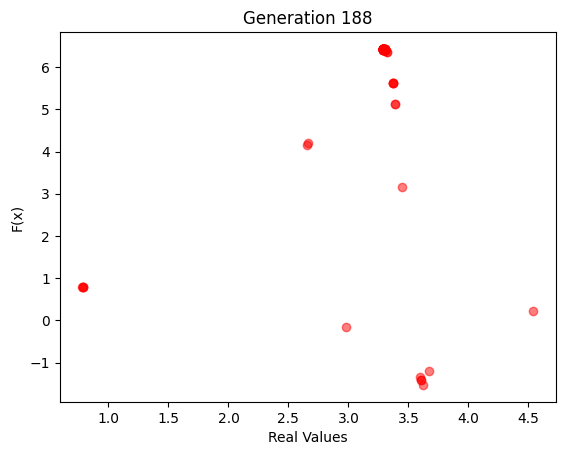

Generation: 189
Max F_values: 6.435822320543684
Time for Generation 189: 0.0044 seconds


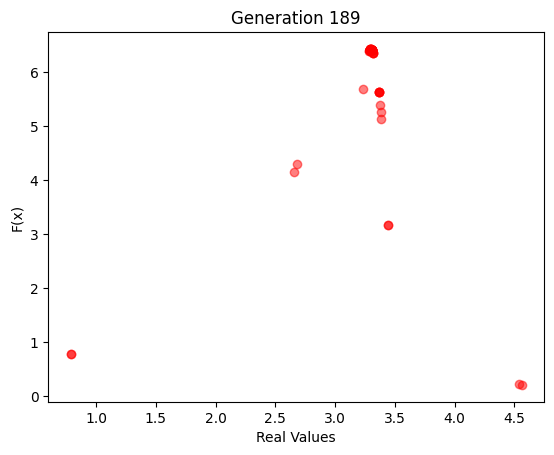

Generation: 190
Max F_values: 6.435822320543684
Time for Generation 190: 0.0036 seconds


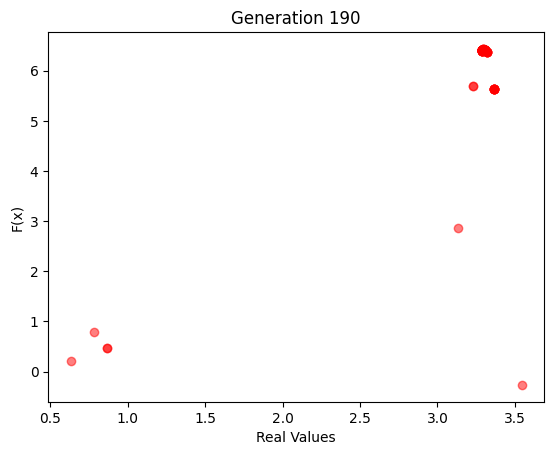

Generation: 191
Max F_values: 6.435822320543684
Time for Generation 191: 0.0047 seconds


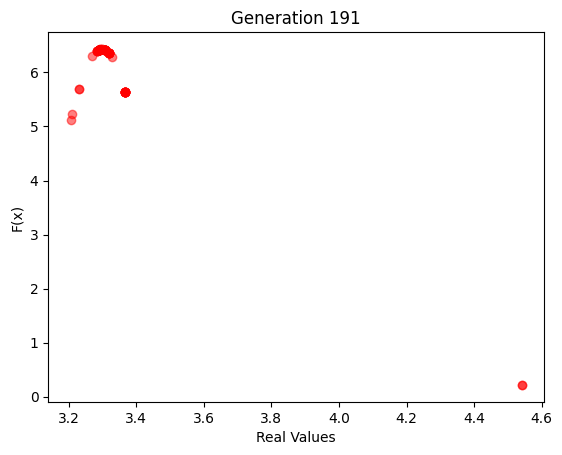

Generation: 192
Max F_values: 6.432903326858257
Time for Generation 192: 0.0041 seconds


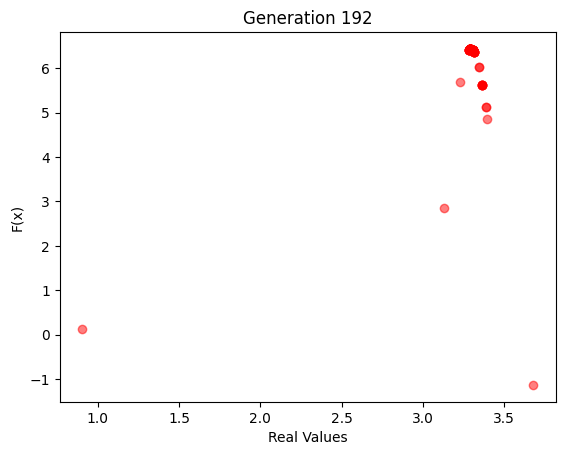

Generation: 193
Max F_values: 6.432903326858257
Time for Generation 193: 0.0054 seconds


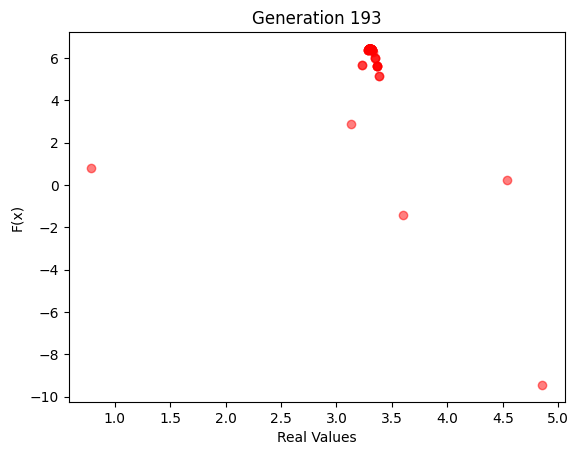

Generation: 194
Max F_values: 6.421816483484863
Time for Generation 194: 0.0057 seconds


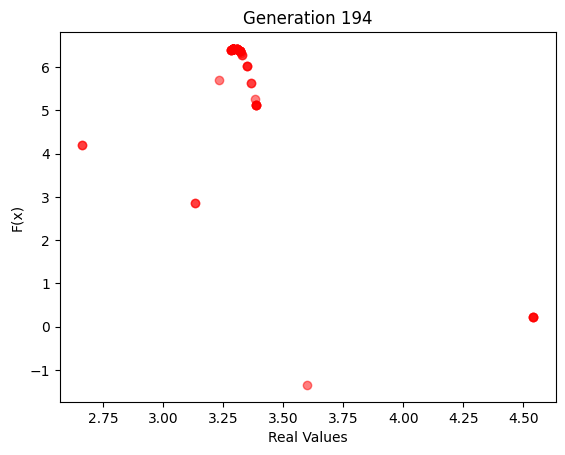

Generation: 195
Max F_values: 6.435822320543684
Time for Generation 195: 0.0042 seconds


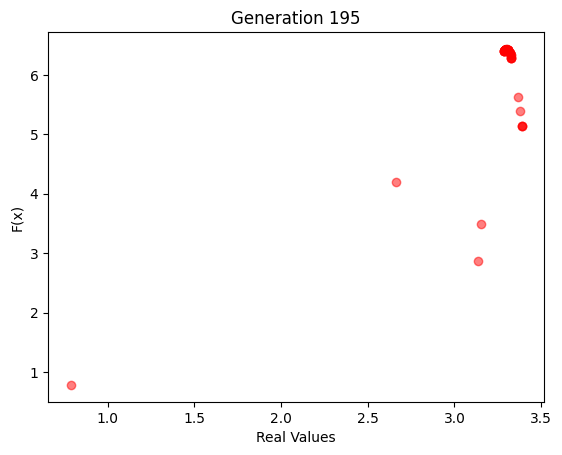

Generation: 196
Max F_values: 6.435822320543684
Time for Generation 196: 0.0044 seconds


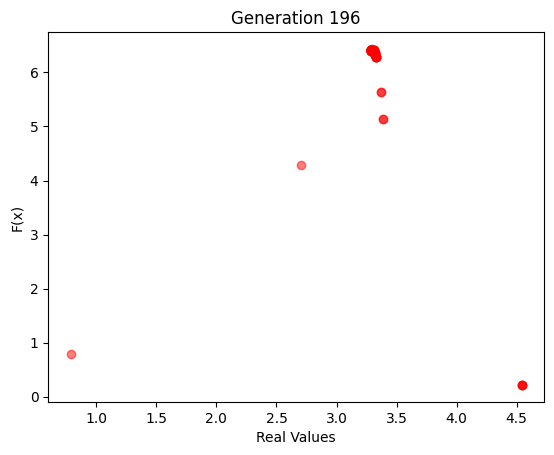

Generation: 197
Max F_values: 6.435822320543684
Time for Generation 197: 0.0045 seconds


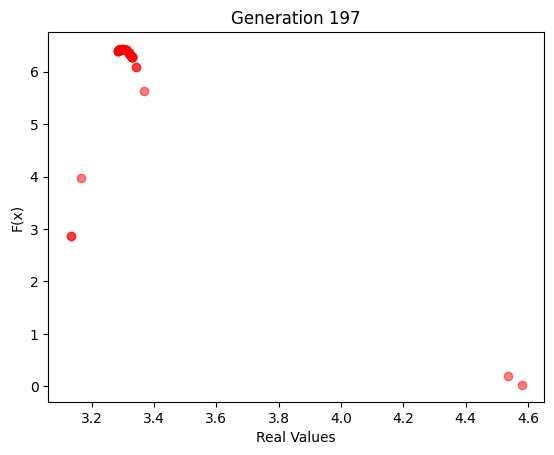

Generation: 198
Max F_values: 6.435822320543684
Time for Generation 198: 0.0044 seconds


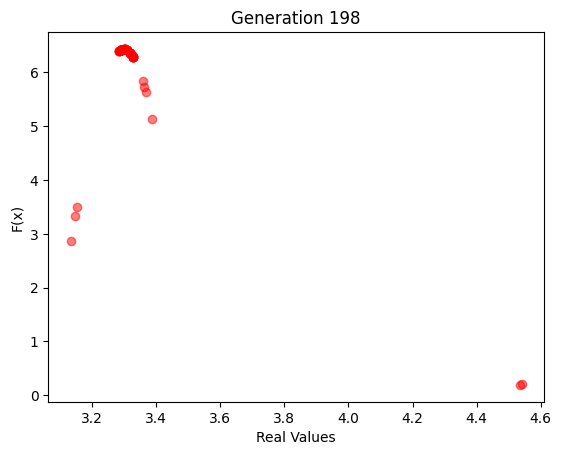

Generation: 199
Max F_values: 6.435822320543684
Time for Generation 199: 0.0034 seconds


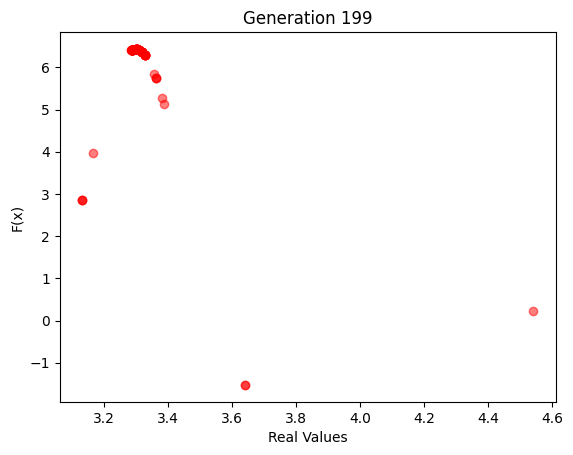

([-23.675642993187143,
  77.49494382590532,
  117.34788066612064,
  204.93293811480302,
  280.04255442872886,
  342.8285143278269,
  379.1112741198265,
  489.0606961056511,
  510.2184915168501,
  514.5274943224771,
  489.06843398062585,
  513.3055799319853,
  526.8562474654851,
  526.770286910031,
  543.5139892930183,
  547.5055069186952,
  555.971786232983,
  568.1036682874521,
  556.5997620389018,
  574.5588177979437,
  553.5835059216774,
  541.2405668810088,
  585.1416391032282,
  580.7266400037797,
  581.1416037995945,
  585.9994359358485,
  576.619555802986,
  589.3383099168508,
  586.6056131274855,
  594.0971548368248,
  596.5392279910967,
  581.914886082505,
  593.130090522761,
  578.7285802615784,
  578.070208376274,
  593.9263204702361,
  587.1136653079355,
  590.7090067316557,
  557.8689963090512,
  563.6050838071479,
  568.8459356464416,
  586.0891201255562,
  570.1551945595596,
  577.7979414236237,
  595.3312942980605,
  581.2055559293676,
  547.422007881294,
  549.69599466

In [51]:
performance = []
time_per_iteration = []
pop = np.random.randint(2, size=(POP_SIZE, DNA_SIZE))
GA(N_GENERATIONS,pop)

## HW3.8 Performance Visualization
Generates a line plot using matplotlib or other tool to visualize the performance of the genetic algorithm over multiple generations.

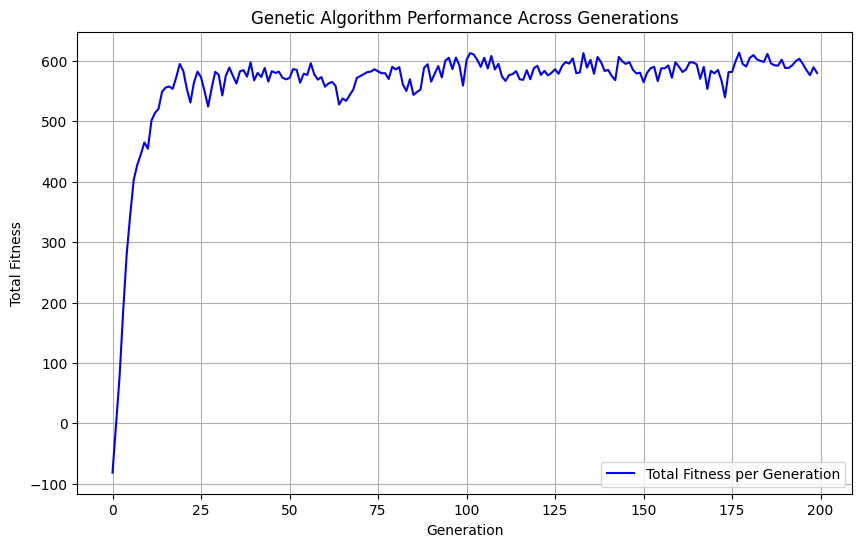

In [48]:
# TODO: Generates a line plot to visualize the genetic algorithm's performance across generations.
def plot_performance(performance):
    plt.figure(figsize=(10, 6))
    plt.plot(performance, label="Total Fitness per Generation", color='b')
    plt.title("Genetic Algorithm Performance Across Generations")
    plt.xlabel("Generation")
    plt.ylabel("Total Fitness")
    plt.legend()
    plt.grid(True)
    plt.show()

# 假設你已經在 GA 函數中計算了每代的 performance 並返回了 performance 列表
plot_performance(performance)

## HW3.9 Discuss1
Increase the mutation rate, follow the above steps, observe the performance, and provide a discussion.

Generation: 0
Max F_values: 6.3952358694713745
Time for Generation 0: 0.0034 seconds


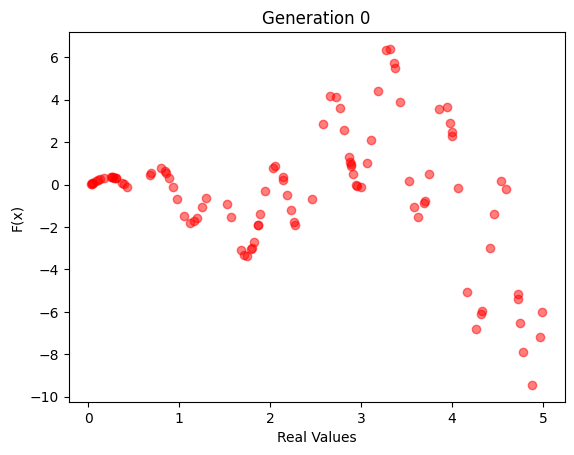

Generation: 1
Max F_values: 6.375404880310326
Time for Generation 1: 0.0036 seconds
Generation: 2
Max F_values: 6.340258949503951
Time for Generation 2: 0.0037 seconds
Generation: 3
Max F_values: 6.421816483484863
Time for Generation 3: 0.0034 seconds
Generation: 4
Max F_values: 6.340258949503951
Time for Generation 4: 0.0037 seconds
Generation: 5
Max F_values: 6.421816483484863
Time for Generation 5: 0.0043 seconds
Generation: 6
Max F_values: 6.430530388062344
Time for Generation 6: 0.0037 seconds
Generation: 7
Max F_values: 6.430530388062344
Time for Generation 7: 0.0037 seconds
Generation: 8
Max F_values: 6.430530388062344
Time for Generation 8: 0.0034 seconds
Generation: 9
Max F_values: 6.421816483484863
Time for Generation 9: 0.0044 seconds
Generation: 10
Max F_values: 6.430530388062344
Time for Generation 10: 0.0036 seconds


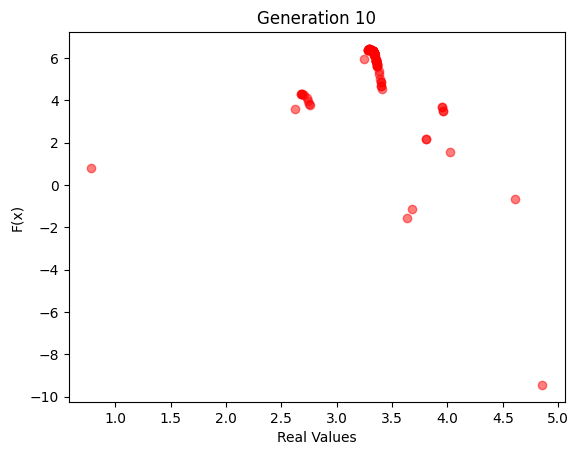

Generation: 11
Max F_values: 6.430530388062344
Time for Generation 11: 0.0041 seconds
Generation: 12
Max F_values: 6.435822320543684
Time for Generation 12: 0.0045 seconds
Generation: 13
Max F_values: 6.435822320543684
Time for Generation 13: 0.0038 seconds
Generation: 14
Max F_values: 6.435822320543684
Time for Generation 14: 0.0036 seconds
Generation: 15
Max F_values: 6.435822320543684
Time for Generation 15: 0.0040 seconds
Generation: 16
Max F_values: 6.435822320543684
Time for Generation 16: 0.0037 seconds
Generation: 17
Max F_values: 6.435822320543684
Time for Generation 17: 0.0034 seconds
Generation: 18
Max F_values: 6.435822320543684
Time for Generation 18: 0.0037 seconds
Generation: 19
Max F_values: 6.435822320543684
Time for Generation 19: 0.0038 seconds
Generation: 20
Max F_values: 6.435822320543684
Time for Generation 20: 0.0037 seconds


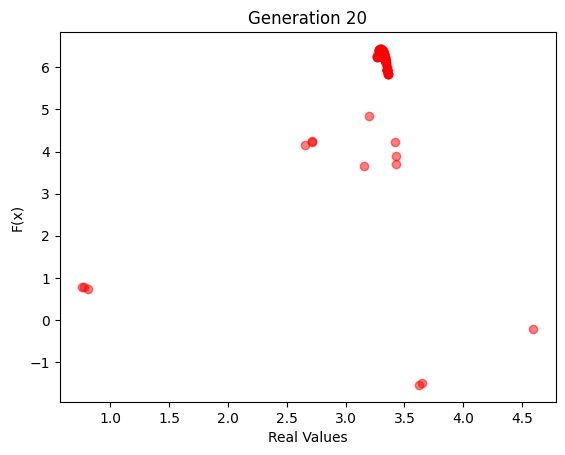

Generation: 21
Max F_values: 6.435822320543684
Time for Generation 21: 0.0081 seconds
Generation: 22
Max F_values: 6.435822320543684
Time for Generation 22: 0.0037 seconds
Generation: 23
Max F_values: 6.435822320543684
Time for Generation 23: 0.0037 seconds
Generation: 24
Max F_values: 6.435822320543684
Time for Generation 24: 0.0044 seconds
Generation: 25
Max F_values: 6.435822320543684
Time for Generation 25: 0.0043 seconds
Generation: 26
Max F_values: 6.435822320543684
Time for Generation 26: 0.0037 seconds
Generation: 27
Max F_values: 6.435822320543684
Time for Generation 27: 0.0039 seconds
Generation: 28
Max F_values: 6.435822320543684
Time for Generation 28: 0.0055 seconds
Generation: 29
Max F_values: 6.435822320543684
Time for Generation 29: 0.0039 seconds
Generation: 30
Max F_values: 6.435822320543684
Time for Generation 30: 0.0039 seconds


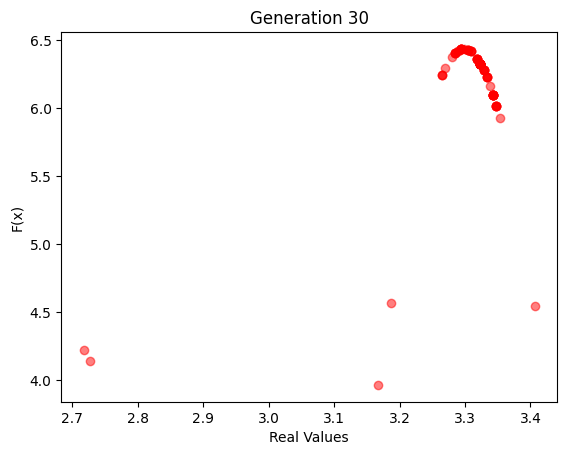

Generation: 31
Max F_values: 6.435822320543684
Time for Generation 31: 0.0052 seconds
Generation: 32
Max F_values: 6.432903326858257
Time for Generation 32: 0.0055 seconds
Generation: 33
Max F_values: 6.435822320543684
Time for Generation 33: 0.0037 seconds
Generation: 34
Max F_values: 6.432903326858257
Time for Generation 34: 0.0036 seconds
Generation: 35
Max F_values: 6.435822320543684
Time for Generation 35: 0.0040 seconds
Generation: 36
Max F_values: 6.430530388062344
Time for Generation 36: 0.0037 seconds
Generation: 37
Max F_values: 6.430530388062344
Time for Generation 37: 0.0036 seconds
Generation: 38
Max F_values: 6.430530388062344
Time for Generation 38: 0.0043 seconds
Generation: 39
Max F_values: 6.430530388062344
Time for Generation 39: 0.0068 seconds
Generation: 40
Max F_values: 6.430530388062344
Time for Generation 40: 0.0083 seconds


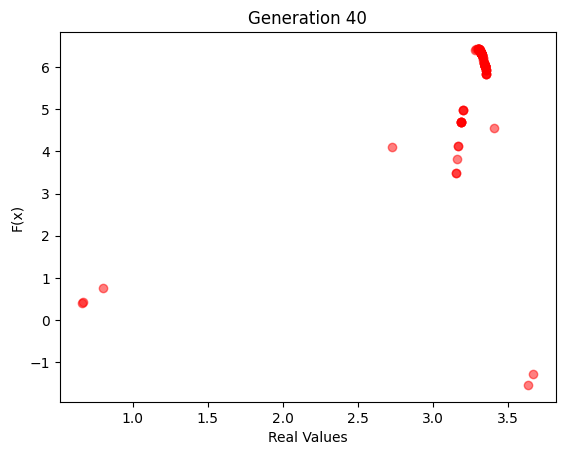

Generation: 41
Max F_values: 6.430530388062344
Time for Generation 41: 0.0052 seconds
Generation: 42
Max F_values: 6.430530388062344
Time for Generation 42: 0.0034 seconds
Generation: 43
Max F_values: 6.435822320543684
Time for Generation 43: 0.0036 seconds
Generation: 44
Max F_values: 6.432903326858257
Time for Generation 44: 0.0036 seconds
Generation: 45
Max F_values: 6.432903326858257
Time for Generation 45: 0.0025 seconds
Generation: 46
Max F_values: 6.432903326858257
Time for Generation 46: 0.0022 seconds
Generation: 47
Max F_values: 6.432903326858257
Time for Generation 47: 0.0038 seconds
Generation: 48
Max F_values: 6.432903326858257
Time for Generation 48: 0.0036 seconds
Generation: 49
Max F_values: 6.435822320543684
Time for Generation 49: 0.0039 seconds
Generation: 50
Max F_values: 6.435822320543684
Time for Generation 50: 0.0035 seconds


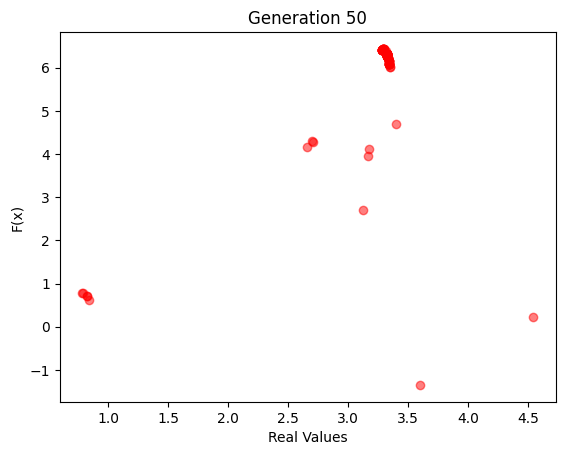

Generation: 51
Max F_values: 6.435822320543684
Time for Generation 51: 0.0053 seconds
Generation: 52
Max F_values: 6.435822320543684
Time for Generation 52: 0.0067 seconds
Generation: 53
Max F_values: 6.435822320543684
Time for Generation 53: 0.0032 seconds
Generation: 54
Max F_values: 6.435822320543684
Time for Generation 54: 0.0036 seconds
Generation: 55
Max F_values: 6.432903326858257
Time for Generation 55: 0.0036 seconds
Generation: 56
Max F_values: 6.432903326858257
Time for Generation 56: 0.0036 seconds
Generation: 57
Max F_values: 6.435822320543684
Time for Generation 57: 0.0035 seconds
Generation: 58
Max F_values: 6.435822320543684
Time for Generation 58: 0.0036 seconds
Generation: 59
Max F_values: 6.435822320543684
Time for Generation 59: 0.0035 seconds
Generation: 60
Max F_values: 6.430530388062344
Time for Generation 60: 0.0046 seconds


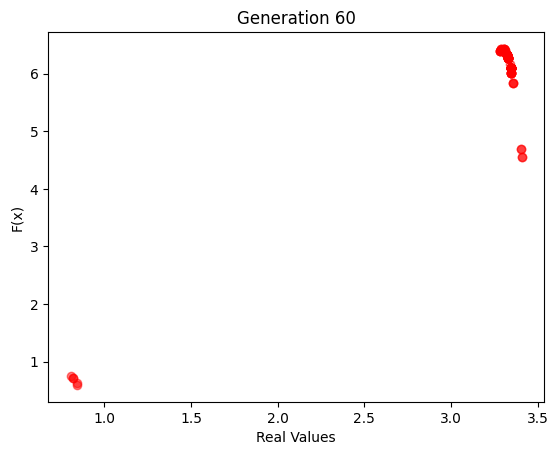

Generation: 61
Max F_values: 6.430530388062344
Time for Generation 61: 0.0051 seconds
Generation: 62
Max F_values: 6.430530388062344
Time for Generation 62: 0.0049 seconds
Generation: 63
Max F_values: 6.430530388062344
Time for Generation 63: 0.0025 seconds
Generation: 64
Max F_values: 6.430530388062344
Time for Generation 64: 0.0035 seconds
Generation: 65
Max F_values: 6.430530388062344
Time for Generation 65: 0.0034 seconds
Generation: 66
Max F_values: 6.430530388062344
Time for Generation 66: 0.0036 seconds
Generation: 67
Max F_values: 6.430530388062344
Time for Generation 67: 0.0039 seconds
Generation: 68
Max F_values: 6.430530388062344
Time for Generation 68: 0.0032 seconds
Generation: 69
Max F_values: 6.432903326858257
Time for Generation 69: 0.0040 seconds
Generation: 70
Max F_values: 6.430530388062344
Time for Generation 70: 0.0065 seconds


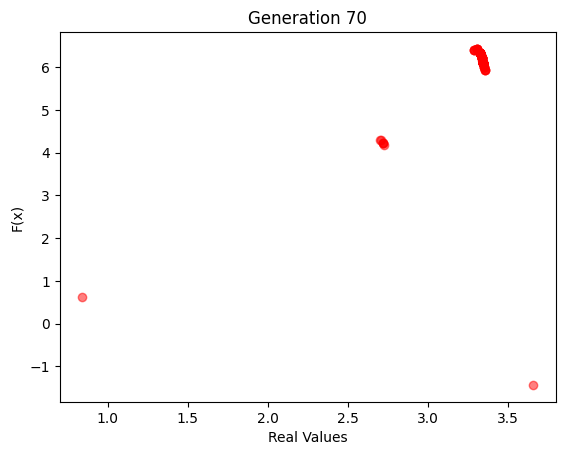

Generation: 71
Max F_values: 6.432903326858257
Time for Generation 71: 0.0057 seconds
Generation: 72
Max F_values: 6.430530388062344
Time for Generation 72: 0.0051 seconds
Generation: 73
Max F_values: 6.432903326858257
Time for Generation 73: 0.0045 seconds
Generation: 74
Max F_values: 6.430530388062344
Time for Generation 74: 0.0042 seconds
Generation: 75
Max F_values: 6.430530388062344
Time for Generation 75: 0.0074 seconds
Generation: 76
Max F_values: 6.432903326858257
Time for Generation 76: 0.0046 seconds
Generation: 77
Max F_values: 6.430530388062344
Time for Generation 77: 0.0037 seconds
Generation: 78
Max F_values: 6.430530388062344
Time for Generation 78: 0.0047 seconds
Generation: 79
Max F_values: 6.430530388062344
Time for Generation 79: 0.0048 seconds
Generation: 80
Max F_values: 6.432903326858257
Time for Generation 80: 0.0035 seconds


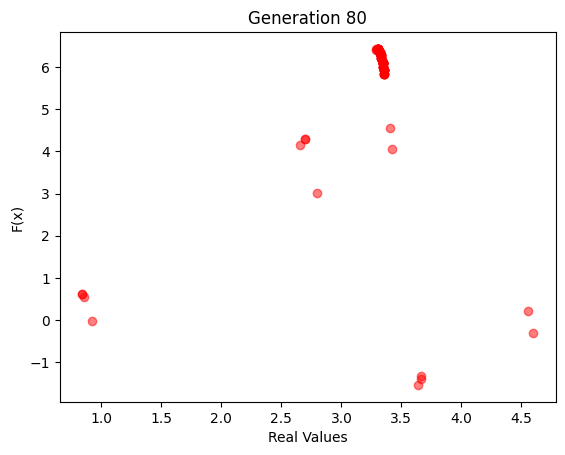

Generation: 81
Max F_values: 6.430530388062344
Time for Generation 81: 0.0044 seconds
Generation: 82
Max F_values: 6.430530388062344
Time for Generation 82: 0.0050 seconds
Generation: 83
Max F_values: 6.430530388062344
Time for Generation 83: 0.0025 seconds
Generation: 84
Max F_values: 6.430530388062344
Time for Generation 84: 0.0036 seconds
Generation: 85
Max F_values: 6.430530388062344
Time for Generation 85: 0.0036 seconds
Generation: 86
Max F_values: 6.430530388062344
Time for Generation 86: 0.0035 seconds
Generation: 87
Max F_values: 6.430530388062344
Time for Generation 87: 0.0035 seconds
Generation: 88
Max F_values: 6.430530388062344
Time for Generation 88: 0.0039 seconds
Generation: 89
Max F_values: 6.430530388062344
Time for Generation 89: 0.0039 seconds
Generation: 90
Max F_values: 6.430530388062344
Time for Generation 90: 0.0037 seconds


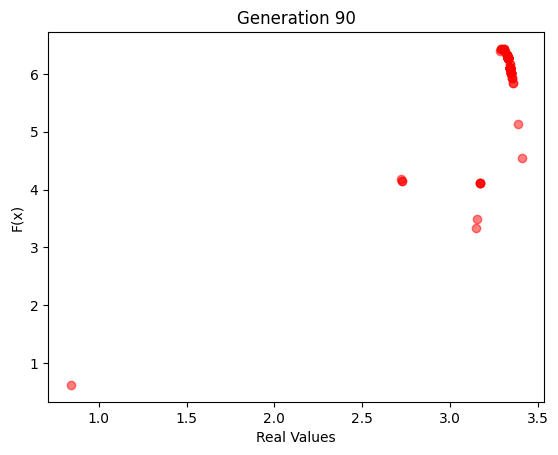

Generation: 91
Max F_values: 6.430530388062344
Time for Generation 91: 0.0062 seconds
Generation: 92
Max F_values: 6.430530388062344
Time for Generation 92: 0.0037 seconds
Generation: 93
Max F_values: 6.430530388062344
Time for Generation 93: 0.0037 seconds
Generation: 94
Max F_values: 6.432903326858257
Time for Generation 94: 0.0034 seconds
Generation: 95
Max F_values: 6.432903326858257
Time for Generation 95: 0.0035 seconds
Generation: 96
Max F_values: 6.430530388062344
Time for Generation 96: 0.0034 seconds
Generation: 97
Max F_values: 6.430530388062344
Time for Generation 97: 0.0035 seconds
Generation: 98
Max F_values: 6.430530388062344
Time for Generation 98: 0.0033 seconds
Generation: 99
Max F_values: 6.430530388062344
Time for Generation 99: 0.0035 seconds
Generation: 100
Max F_values: 6.430530388062344
Time for Generation 100: 0.0036 seconds


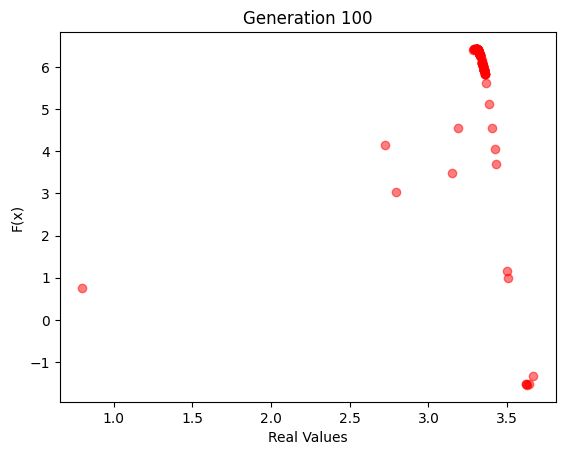

Generation: 101
Max F_values: 6.430530388062344
Time for Generation 101: 0.0053 seconds
Generation: 102
Max F_values: 6.430530388062344
Time for Generation 102: 0.0035 seconds
Generation: 103
Max F_values: 6.430530388062344
Time for Generation 103: 0.0047 seconds
Generation: 104
Max F_values: 6.432903326858257
Time for Generation 104: 0.0032 seconds
Generation: 105
Max F_values: 6.432903326858257
Time for Generation 105: 0.0026 seconds
Generation: 106
Max F_values: 6.432903326858257
Time for Generation 106: 0.0036 seconds
Generation: 107
Max F_values: 6.432903326858257
Time for Generation 107: 0.0036 seconds
Generation: 108
Max F_values: 6.432903326858257
Time for Generation 108: 0.0036 seconds
Generation: 109
Max F_values: 6.435822320543684
Time for Generation 109: 0.0034 seconds
Generation: 110
Max F_values: 6.435822320543684
Time for Generation 110: 0.0035 seconds


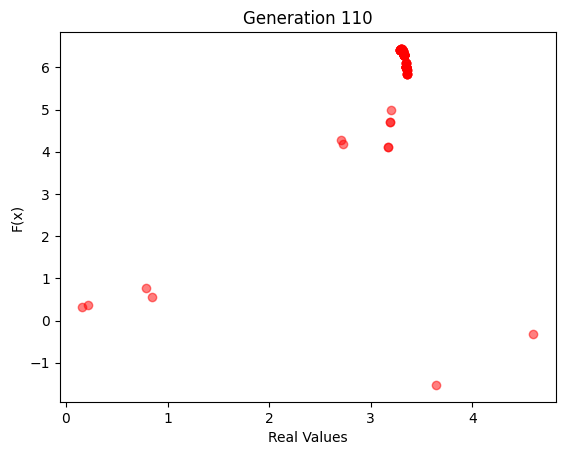

Generation: 111
Max F_values: 6.435822320543684
Time for Generation 111: 0.0047 seconds
Generation: 112
Max F_values: 6.435822320543684
Time for Generation 112: 0.0039 seconds
Generation: 113
Max F_values: 6.435822320543684
Time for Generation 113: 0.0040 seconds
Generation: 114
Max F_values: 6.435822320543684
Time for Generation 114: 0.0037 seconds
Generation: 115
Max F_values: 6.435822320543684
Time for Generation 115: 0.0036 seconds
Generation: 116
Max F_values: 6.435822320543684
Time for Generation 116: 0.0039 seconds
Generation: 117
Max F_values: 6.435822320543684
Time for Generation 117: 0.0036 seconds
Generation: 118
Max F_values: 6.430530388062344
Time for Generation 118: 0.0036 seconds
Generation: 119
Max F_values: 6.430530388062344
Time for Generation 119: 0.0038 seconds
Generation: 120
Max F_values: 6.432903326858257
Time for Generation 120: 0.0038 seconds


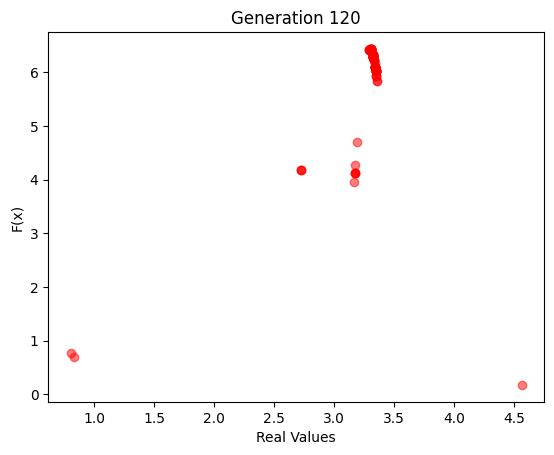

Generation: 121
Max F_values: 6.432903326858257
Time for Generation 121: 0.0048 seconds
Generation: 122
Max F_values: 6.430530388062344
Time for Generation 122: 0.0044 seconds
Generation: 123
Max F_values: 6.435822320543684
Time for Generation 123: 0.0047 seconds
Generation: 124
Max F_values: 6.435822320543684
Time for Generation 124: 0.0053 seconds
Generation: 125
Max F_values: 6.435822320543684
Time for Generation 125: 0.0042 seconds
Generation: 126
Max F_values: 6.435822320543684
Time for Generation 126: 0.0037 seconds
Generation: 127
Max F_values: 6.435822320543684
Time for Generation 127: 0.0037 seconds
Generation: 128
Max F_values: 6.435822320543684
Time for Generation 128: 0.0037 seconds
Generation: 129
Max F_values: 6.432903326858257
Time for Generation 129: 0.0038 seconds
Generation: 130
Max F_values: 6.432903326858257
Time for Generation 130: 0.0036 seconds


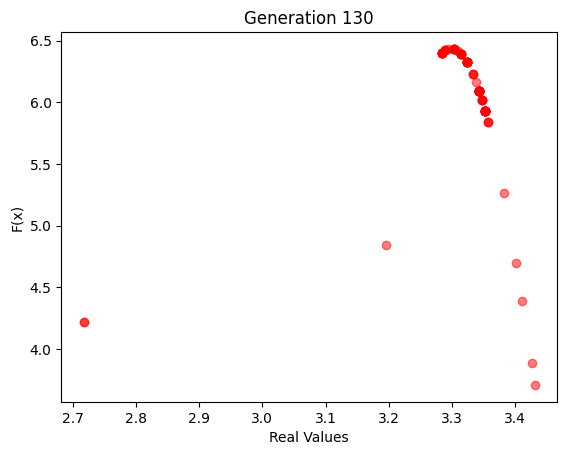

Generation: 131
Max F_values: 6.432903326858257
Time for Generation 131: 0.0044 seconds
Generation: 132
Max F_values: 6.432903326858257
Time for Generation 132: 0.0063 seconds
Generation: 133
Max F_values: 6.432903326858257
Time for Generation 133: 0.0028 seconds
Generation: 134
Max F_values: 6.432903326858257
Time for Generation 134: 0.0041 seconds
Generation: 135
Max F_values: 6.432903326858257
Time for Generation 135: 0.0037 seconds
Generation: 136
Max F_values: 6.432903326858257
Time for Generation 136: 0.0035 seconds
Generation: 137
Max F_values: 6.432903326858257
Time for Generation 137: 0.0041 seconds
Generation: 138
Max F_values: 6.432903326858257
Time for Generation 138: 0.0038 seconds
Generation: 139
Max F_values: 6.432903326858257
Time for Generation 139: 0.0042 seconds
Generation: 140
Max F_values: 6.432903326858257
Time for Generation 140: 0.0038 seconds


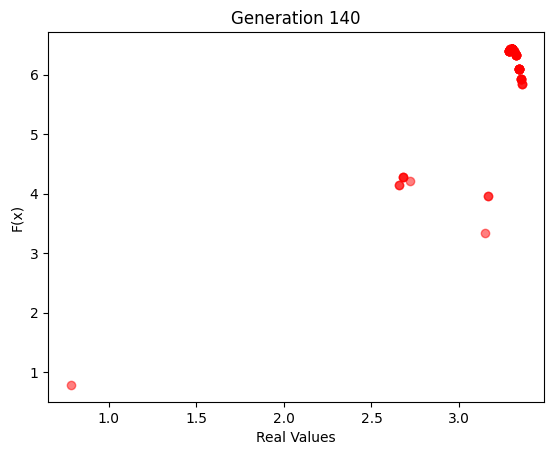

Generation: 141
Max F_values: 6.430530388062344
Time for Generation 141: 0.0053 seconds
Generation: 142
Max F_values: 6.430530388062344
Time for Generation 142: 0.0044 seconds
Generation: 143
Max F_values: 6.430530388062344
Time for Generation 143: 0.0053 seconds
Generation: 144
Max F_values: 6.430530388062344
Time for Generation 144: 0.0036 seconds
Generation: 145
Max F_values: 6.432903326858257
Time for Generation 145: 0.0047 seconds
Generation: 146
Max F_values: 6.430530388062344
Time for Generation 146: 0.0027 seconds
Generation: 147
Max F_values: 6.430530388062344
Time for Generation 147: 0.0034 seconds
Generation: 148
Max F_values: 6.430530388062344
Time for Generation 148: 0.0036 seconds
Generation: 149
Max F_values: 6.430530388062344
Time for Generation 149: 0.0034 seconds
Generation: 150
Max F_values: 6.430530388062344
Time for Generation 150: 0.0034 seconds


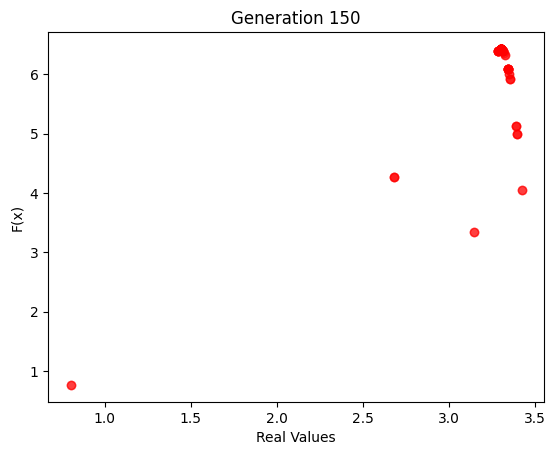

Generation: 151
Max F_values: 6.430530388062344
Time for Generation 151: 0.0041 seconds
Generation: 152
Max F_values: 6.430530388062344
Time for Generation 152: 0.0058 seconds
Generation: 153
Max F_values: 6.430530388062344
Time for Generation 153: 0.0026 seconds
Generation: 154
Max F_values: 6.430530388062344
Time for Generation 154: 0.0036 seconds
Generation: 155
Max F_values: 6.430530388062344
Time for Generation 155: 0.0033 seconds
Generation: 156
Max F_values: 6.430530388062344
Time for Generation 156: 0.0035 seconds
Generation: 157
Max F_values: 6.432903326858257
Time for Generation 157: 0.0035 seconds
Generation: 158
Max F_values: 6.432903326858257
Time for Generation 158: 0.0034 seconds
Generation: 159
Max F_values: 6.430530388062344
Time for Generation 159: 0.0036 seconds
Generation: 160
Max F_values: 6.430530388062344
Time for Generation 160: 0.0035 seconds


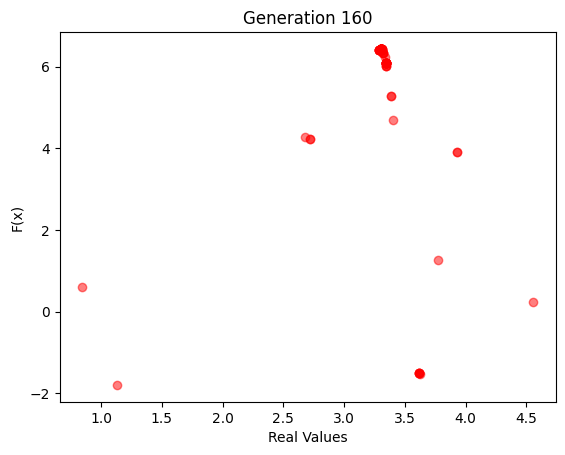

Generation: 161
Max F_values: 6.430530388062344
Time for Generation 161: 0.0042 seconds
Generation: 162
Max F_values: 6.430530388062344
Time for Generation 162: 0.0055 seconds
Generation: 163
Max F_values: 6.430530388062344
Time for Generation 163: 0.0030 seconds
Generation: 164
Max F_values: 6.430530388062344
Time for Generation 164: 0.0037 seconds
Generation: 165
Max F_values: 6.430530388062344
Time for Generation 165: 0.0040 seconds
Generation: 166
Max F_values: 6.430530388062344
Time for Generation 166: 0.0040 seconds
Generation: 167
Max F_values: 6.430530388062344
Time for Generation 167: 0.0073 seconds
Generation: 168
Max F_values: 6.430530388062344
Time for Generation 168: 0.0051 seconds
Generation: 169
Max F_values: 6.430530388062344
Time for Generation 169: 0.0054 seconds
Generation: 170
Max F_values: 6.430530388062344
Time for Generation 170: 0.0033 seconds


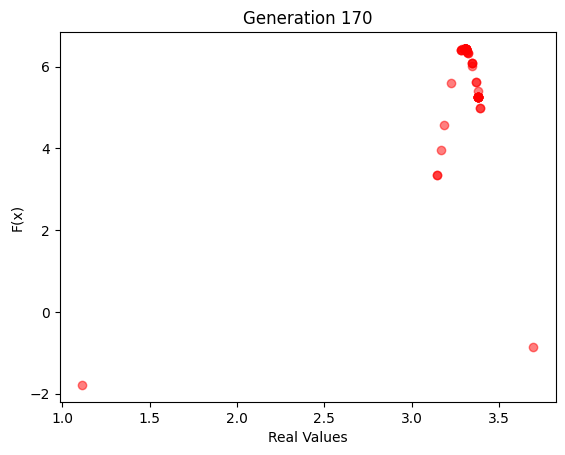

Generation: 171
Max F_values: 6.430530388062344
Time for Generation 171: 0.0061 seconds
Generation: 172
Max F_values: 6.430530388062344
Time for Generation 172: 0.0037 seconds
Generation: 173
Max F_values: 6.430530388062344
Time for Generation 173: 0.0041 seconds
Generation: 174
Max F_values: 6.430530388062344
Time for Generation 174: 0.0036 seconds
Generation: 175
Max F_values: 6.430530388062344
Time for Generation 175: 0.0038 seconds
Generation: 176
Max F_values: 6.435822320543684
Time for Generation 176: 0.0040 seconds
Generation: 177
Max F_values: 6.432903326858257
Time for Generation 177: 0.0041 seconds
Generation: 178
Max F_values: 6.432903326858257
Time for Generation 178: 0.0045 seconds
Generation: 179
Max F_values: 6.432903326858257
Time for Generation 179: 0.0038 seconds
Generation: 180
Max F_values: 6.435822320543684
Time for Generation 180: 0.0029 seconds


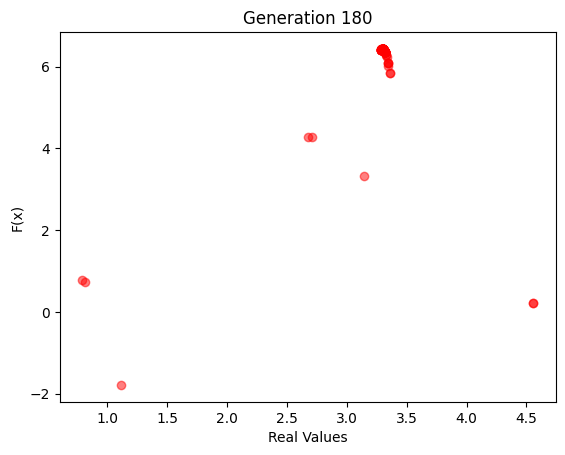

Generation: 181
Max F_values: 6.435822320543684
Time for Generation 181: 0.0071 seconds
Generation: 182
Max F_values: 6.435822320543684
Time for Generation 182: 0.0035 seconds
Generation: 183
Max F_values: 6.435822320543684
Time for Generation 183: 0.0035 seconds
Generation: 184
Max F_values: 6.435822320543684
Time for Generation 184: 0.0051 seconds
Generation: 185
Max F_values: 6.435822320543684
Time for Generation 185: 0.0042 seconds
Generation: 186
Max F_values: 6.430530388062344
Time for Generation 186: 0.0043 seconds
Generation: 187
Max F_values: 6.430530388062344
Time for Generation 187: 0.0051 seconds
Generation: 188
Max F_values: 6.430530388062344
Time for Generation 188: 0.0049 seconds
Generation: 189
Max F_values: 6.435822320543684
Time for Generation 189: 0.0042 seconds
Generation: 190
Max F_values: 6.432903326858257
Time for Generation 190: 0.0037 seconds


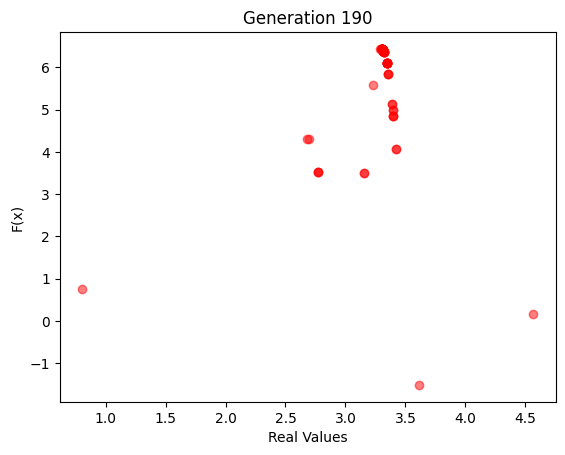

Generation: 191
Max F_values: 6.435822320543684
Time for Generation 191: 0.0061 seconds
Generation: 192
Max F_values: 6.430530388062344
Time for Generation 192: 0.0037 seconds
Generation: 193
Max F_values: 6.430530388062344
Time for Generation 193: 0.0033 seconds
Generation: 194
Max F_values: 6.430530388062344
Time for Generation 194: 0.0035 seconds
Generation: 195
Max F_values: 6.430530388062344
Time for Generation 195: 0.0036 seconds
Generation: 196
Max F_values: 6.435822320543684
Time for Generation 196: 0.0035 seconds
Generation: 197
Max F_values: 6.435822320543684
Time for Generation 197: 0.0035 seconds
Generation: 198
Max F_values: 6.435822320543684
Time for Generation 198: 0.0036 seconds
Generation: 199
Max F_values: 6.435822320543684
Time for Generation 199: 0.0033 seconds


([-40.46539458211636,
  55.41796910743812,
  146.18610096092056,
  187.90308976107292,
  237.42025835255222,
  345.67862602343905,
  385.6595892931383,
  431.7561085838396,
  485.96607938631786,
  501.59186305857077,
  520.6979598528056,
  540.6755873083556,
  543.8249753718313,
  568.7206642218028,
  578.5792169630022,
  602.2589592582717,
  599.3788039032378,
  610.4196439370762,
  588.7149276211215,
  566.1933338968721,
  566.1732675809506,
  576.0181513948937,
  574.0345247727505,
  587.9047520901729,
  599.6622843108581,
  597.7124533046807,
  597.6544813091048,
  581.9745492744154,
  541.3016723321933,
  582.160916795248,
  619.0418570521938,
  605.3796459012251,
  593.8404284387861,
  592.1361339008026,
  581.8042884243885,
  598.6716343704951,
  584.4457985029376,
  579.6877994974889,
  578.6591379984903,
  579.6585140024358,
  561.5313338949408,
  550.5932120375655,
  577.7331378053243,
  570.075750931619,
  542.2335863501152,
  588.3113084915485,
  591.1809137608581,
  595.98

In [49]:
MUTATION_RATE = 0.01 # > 0.003
performance = []
time_per_iteration = []
pop = np.random.randint(2, size=(POP_SIZE, DNA_SIZE))
GA(N_GENERATIONS,pop)

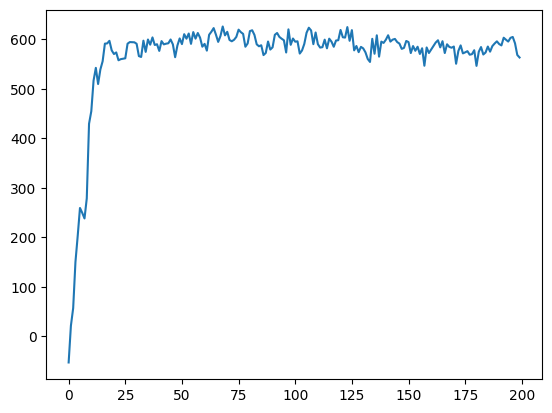

In [45]:
x = np.arange(0, N_GENERATIONS,1)
y = performance
plt.plot(x, y)

# HW 3.10 Discuss2
Based on the time taken for each generation, do you think GA is an efficient algorithm? Please compare it with traditional heuristic algorithms and modern machine learning methods in your explanation.